In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use({'figure.facecolor':'white'})
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib import rc
from matplotlib import cm, ticker
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

#mpl.rcParams['font.family'] = ['times new roman'] # default is sans-serif
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=False)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath,bm}'] #for \text command

import scipy.stats as ss
from tqdm import tqdm
from datetime import datetime
now = datetime.now()
date = now.strftime("%d_%m_%Y_%H:%M")
import torch as th
import seaborn as sns
from mpl_toolkits import mplot3d
import fenics_concrete
import yaml
# local imports
from usecases.demonstrator.Calibration.utils.sampler import random_walk_metropolis

# Initialize random number generator
RANDOM_SEED = 420
rng = np.random.default_rng(RANDOM_SEED)
%load_ext autoreload
%autoreload 2
seed = 420

/tmp/ipykernel_21602/2273200294.py:16: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath,bm}'] #for \text command


## Loading exp data

In [3]:
data_file = '../artificial_hydration_data/artificial_hydration_data.yaml'
#Example 1:
# read file and access artificial data:
with open(data_file) as file:
    hydration_data = yaml.safe_load(file)

# data is given in dictionary
# data[mix ratio: 0/.2/0.5/.8/1][temperature: 20/40/60][time/heat]
# it is assumed that this is hydration data for two distinct mixes
# mix 1: mix ration = 0 and mix 2: mix ratio = 1
# there are 3 intermediate mixes with 20/80, 50/50 and 80/20 ratio between mix 1 and 2
# for each of the 5 mixes there are 3 temperature measurements, each at 20, 40 and 60 degree
# for each temperature there is a list with the time and the heat values

# loop over all data, print lists 
for mix_r in hydration_data:
    for temp in hydration_data[mix_r]:
        print(mix_r,temp,'time:',hydration_data[mix_r][temp]['time'])
        print(mix_r,temp,'heat:',hydration_data[mix_r][temp]['heat'])

0 20 time: [1523.8095238095204, 4952.3809523809505, 8205.489092188598, 11972.78911564625, 15283.446712018129, 18137.461881304233, 20828.390469488288, 22932.2073657049, 24987.098287590896, 27041.989209476887, 29096.880131362883, 31037.61044647744, 33157.73600080426, 35310.47887135149, 37561.07369055996, 39371.33474079287, 41426.225662678866, 43481.11658456486, 45584.93348078148, 48275.86206896551, 51129.87723825162, 54326.374227852066, 57454.37485338963, 61290.17124091015, 65244.279529993815, 68980.44484251381, 72934.55313159747, 77044.33497536946, 81122.98210820378, 85073.63098496104, 87661.27140511374, 90666.66666666667, 95619.04761904762, 102045.50785831573, 108190.4761904762, 115428.57142857143, 122666.66666666664, 127389.16256157636, 132952.38095238095, 141088.43537414967, 147428.57142857145, 153904.7619047619, 158555.00821018062, 164952.38095238095, 171047.61904761902, 175336.61740558292, 184380.95238095243, 189714.2857142857, 193523.80952380953, 198857.14285714287, 206476.1904761

In [4]:
hydration_data_test = hydration_data.pop(0.5)
hydration_data_train = hydration_data

In [5]:
hydration_data[0][20]['heat']

[1.2106537530266905,
 2.663438256658594,
 4.427533725354579,
 10.957907417788874,
 18.417045368702702,
 27.087930438101637,
 35.90393492288797,
 43.91452665227405,
 51.79451090781146,
 60.392836269516636,
 68.66464294660005,
 76.06573313135897,
 84.97502866889431,
 93.37122341630987,
 102.42045553296884,
 110.67671370126078,
 118.4043225706414,
 126.37137847541123,
 134.43794483644672,
 142.8388041364998,
 151.7817881097501,
 160.34383361760837,
 168.79703956392615,
 176.8511671179284,
 184.91518917752535,
 192.4548024406086,
 199.16327723374565,
 205.69365092618,
 212.10529055147913,
 218.10136094180515,
 220.7135104187789,
 226.39225181598067,
 232.9297820823245,
 240.95766886532525,
 245.27845036319616,
 253.26876513317194,
 259.80629539951576,
 264.4670141580888,
 269.24939467312345,
 276.2216868044705,
 280.1452784503632,
 283.77723970944317,
 287.97635945085227,
 289.588377723971,
 291.7675544794189,
 295.15977051253003,
 298.30508474576277,
 301.9370460048426,
 302.6634382566586

$$p(\boldsymbol{b}|\boldsymbol{x};\boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{b}|\boldsymbol{W}.\boldsymbol{x} + \boldsymbol{\mathcal{B}}, \boldsymbol{\Sigma})$$

 $$\text{Parameters to be inferred }\boldsymbol{\phi} = \{\boldsymbol{W},\boldsymbol{\mathcal{B}},\boldsymbol{\Sigma} \}$$

In [5]:
class Prior_(object):
    def __init__(self,x):
        if isinstance(x,np.ndarray):
            pass
        else:
            x = np.array([x])
        self.x = x
        #self.sigma = sigma
        self.cov = None
    def _b_mean(self,x,phi):
        assert phi.ndim == 2
        b_vec = th.matmul(phi[:,:-1],x) + phi[:,-1]
        return b_vec
    def logeval(self,b,phi :list):
        phi_mean = phi[0]
        phi_sd_diag = phi[1]
        phi_ = th.tensor(phi_mean,requires_grad=True)
        mean = self._b_mean(th.from_numpy(self.x),phi_)
        assert mean.shape[0] == phi_sd_diag.shape[0]
        phi_sd_diag_ = th.tensor(phi_sd_diag,requires_grad=True) # diagonal entries of cov
        
        #self.cov = th.diag(phi_sd_diag_) @ th.diag(phi_sd_diag_).mT
        self.cov = th.diag(1e-07+th.exp(phi_sd_diag_))
        dist = th.distributions.MultivariateNormal(mean,self.cov)
        val = dist.log_prob(th.from_numpy(b))
        val.backward()
        grad_phi = phi_.grad
        grad_sigma = phi_sd_diag_.grad
        # returing falttened gradients
        return [val.detach().numpy(), grad_phi.detach().numpy() ,grad_sigma.detach().numpy()] # negative as later grad ascent needs to performed to find arg max logp(D|phi)
    def sample(self,phi:list,samples=100):
        phi_mean = phi[0]
        phi_sd_diag = phi[1]
        phi_sd_diag = th.from_numpy(phi_sd_diag)
        mean = self._b_mean(th.from_numpy(self.x),th.from_numpy(phi_mean))
        #cov = th.diag(phi_sd_diag) @ th.diag(phi_sd_diag).mT
        cov = th.diag(1e-07+th.exp(phi_sd_diag))
        dist = th.distributions.MultivariateNormal(mean,cov)
        samples = dist.sample([samples,])
        
        return samples.detach().numpy()
        
        

In [5]:
phi_test = np.random.rand(4,2)
x_test = 0.2
pr = Prior_(x =x_test)

In [8]:
b_test = pr._b_mean(th.from_numpy(np.array([x_test])),th.from_numpy(phi_test))
phi_sd = 0.01*np.ones(4)
phi = [phi_test, phi_sd]
pr.logeval(b_test.numpy(),phi)

[array(-3.69575433),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([-0.49999995, -0.49999995, -0.49999995, -0.49999995])]

In [103]:
pr.cov

tensor([[1.0101, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0101, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0101, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0101]], dtype=torch.float64,
       grad_fn=<DiagBackward0>)

In [ ]:
class ForwardBase:
    def __init__(self, inp_obs, inp_unobs):
        self.inp_obs = inp_obs
        self.inp_unobs =inp_unobs
    def forward(self):
        raise NotImplementedError ("The forward method needs to be overloaded or defined for a specific solver")

In [6]:
def forward_model(inp_latents: list, inp_obs: dict) -> list:
    parameter = fenics_concrete.Parameters()  # using the current default values

    # -- latents -----
    # parameter['B1'] = 2.916E-4  # in 1/s (le 0, < 0.1)
    # parameter['B2'] = 0.0024229  # - (le 0, smaller 1)
    # parameter['eta'] = 5.554  # something about diffusion (should be larger 0)
    # parameter['T_ref'] = 25  # reference temperature in degree celsius
    # parameter['Q_pot'] = 500e3 # potential heat per weight of binder in J/kg
    
    # -- adding scaling back the values
    parameter['B1'] = inp_latents[0]*1e-04  # in 1/s (le 0, < 0.1)
    parameter['B2'] = inp_latents[1]*1e-03  # - (le 0, smaller 1)
    parameter['eta'] = inp_latents[2]  # something about diffusion (should be larger 0)
    parameter['Q_pot'] = inp_latents[3]*1e05  # potential heat per weight of binder in J/kg

    # -- observed inputs
    parameter['igc'] = 8.3145  # ideal gas constant in [J/K/mol], CONSTANT!!!
    parameter['zero_C'] = 273.15  # in Kelvin, CONSTANT!!!
    parameter['E_act'] = 47002  # activation energy in Jmol^-1 (no relevant limits) (Depends only on simulated temp, if that is not change no need to infer E_act)
    parameter['alpha_max'] = 0.875  # also possible to approximate based on equation with w/c (larger 0 and max 1)
    parameter['T_ref'] = 25  # reference temperature in degree celsius

    # this is the minimal time step used in the simulation
    # using a larger value will increase the speed but decrease the accuracy
    dt = 300 # value in seconds

    # this is the simulated temperature, needs to be adjusted depending on the temperature of the experimental data
    T = inp_obs['T_rxn'] # can be 20,40,60 as pert the exp values
    # this is the list of measured time data as given by the experiments
    #time_list = [0,5000,10000,20000,100000]
    time_list = inp_obs['time_list']

    # initiate material problem, for this the "fenics_concrete" conda package needs to be installed
    # use: 'mamba install -c etamsen fenics_concrete"
    problem = fenics_concrete.ConcreteThermoMechanical()

    # get the hydration function
    # this might change in the future to make it more easily accessible but for now it should work like this
    hydration_fkt = problem.get_heat_of_hydration_ftk()
    # the results are a heat list and a degree of hydration list, which you can ignore for now
    heat_list, doh_list= hydration_fkt(T, time_list, dt, parameter)

    return heat_list

In [6]:
ratio = 0
inp_obs = {
    'T_rxn' : list(hydration_data[ratio].keys())[0], # selecting the first temp value i.e 20
    'time_list' : hydration_data[ratio][20]['time']
}

inp_latents = np.array([2.916, 2.4229, 5.554, 5])

In [7]:
Q_y = forward_model(inp_latents=inp_latents, inp_obs = inp_obs)

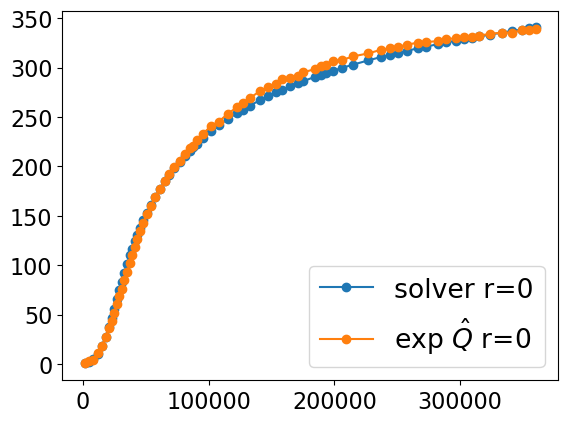

In [8]:
ratio =0
plt.plot(inp_obs['time_list'],Q_y, '-o', label = 'solver r=0')
plt.plot(hydration_data[ratio][20]['time'],hydration_data[ratio][20]['heat'], '-o', label = 'exp $\hat{Q}$ r=0')

plt.legend()

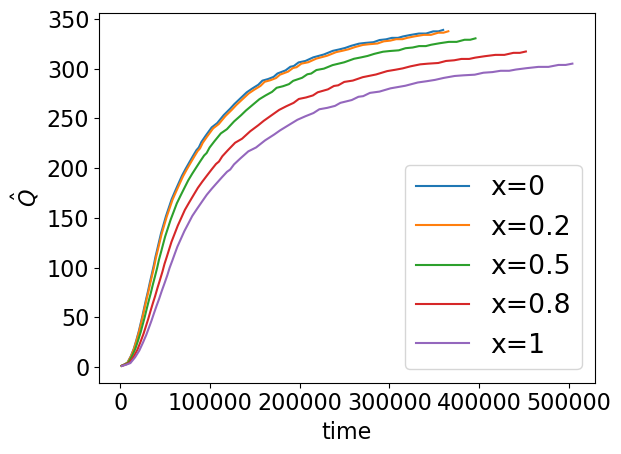

In [56]:
for ratio in hydration_data.keys():
    plt.plot(hydration_data[ratio][20]['time'],hydration_data[ratio][20]['heat'], label = 'x='+ str(ratio))
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('$\hat{Q}$')

## Defining Probabilistic model

In [8]:
class likelihood(object):
    def __init__(self,obs : list,sigma : float,solver :callable, **kwargs):
        self.obs = obs
        self._sigma = sigma
        self.solver = solver
        self.inp_obs_solver = kwargs['inp_obs']

    def logeval(self,b ) -> float:
        assert isinstance(b,np.ndarray)
        y_c = self.solver(b,self.inp_obs_solver)
        cov = np.diag((self._sigma*y_c)+ 1e-14)
        val = ss.multivariate_normal.logpdf(self.obs,y_c,cov)
        #val = ss.norm.logpdf(y_c,self.obs,np.sqrt(self._ssigma))
        return val

In [ ]:
lkl_tmp = likelihood(obs= np.array(hydration_data[ratio][20]['heat']),sigma=1e-04,solver=forward_model, inp_obs = inp_obs)

In [ ]:
#inp_latents_test  = np.array([2.916E-4, 0.0024229, 5.554, 500e3])
lkl_tmp.logeval(inp_latents)

In [9]:
class posterior(object):
    def __init__(self, prior, likelihood):

        self._prior = prior
        self._likelihood = likelihood

    def logeval(self,b, phi):

        #return self._prior.LogEvaluate(x)[0] + self._likelihood.LogEvaluate(x),self._prior.LogEvaluate(x)[1]
        return self._prior.logeval(b,phi)[0] + self._likelihood.logeval(b)

In [ ]:
pos = posterior(pr,lkl_tmp)
pos.logeval(inp_latents_test,phi)

In [10]:
# defining target
def log_h(b,phi :list,obs_data :dict, i):
    """
    This needs to be overloaded
    Parameters
    ----------
    b :
    phi :
    obs_data :
    i : Index of the observed datapair

    Returns
    -------

    """
    # defining data



    # defining the prior
    ratio = list(obs_data.keys())[i] # the ratio here
    prior_tmp = Prior_(np.array([float(ratio)]))

    # defining the likelihood
    inp_obs = {
    'T_rxn' : list(obs_data[ratio].keys())[0], # selecting the first temp value i.e 20
    'time_list' : obs_data[ratio][20]['time']
    }
    lkl_tmp = likelihood(obs= obs_data[ratio][20]['heat'],sigma=1e-04,solver=forward_model, inp_obs = inp_obs)

    #phi = np.array([0.9,1]) # true value, should return this

    pos = posterior(prior_tmp,lkl_tmp)
    return pos.logeval(b,phi)

In [16]:
# testing the target
#phi_mean = np.hstack((np.zeros((4,1)),inp_latents_test.reshape(-1,1)))
b_opt  = np.load('./Results/b_opt_deterministic12_09_2022_14:22.npy')

In [17]:
b_opt[:,0] = b_opt[:,0]*1e04
b_opt[:,1] = b_opt[:,1]*1e03
b_opt[:,3] = b_opt[:,3]*1e-05

In [18]:
b_opt = np.delete(b_opt,2,0)

In [14]:
phi_mean = np.hstack((np.zeros((4,1)),b_opt[0,:].reshape(-1,1)))
#phi_sd = 0.1*np.ones(4)*b_opt[0,:]
phi_sd = -1*np.ones(4)
phi_test = [phi_mean,phi_sd]
log_h(b_opt[0,:],phi = phi_test,obs_data=hydration_data,i=0)

-7901.916984500861

In [16]:
# sampling to check
rw = random_walk_metropolis(target_logprob=log_h)

In [19]:
x_init = b_opt[0,:]
#stepsize = 

In [ ]:
b_samples = rw.run(N=300,cov_proposal=0.00005*np.diag(x_init),x0=np.random.normal(1,0.05,4)*x_init,burnin = 50, phi = phi_test, obs_data = hydration_data,i=0)

In [ ]:
plt.plot(b_samples[:,3])

In [ ]:
np.power(b_opt,2)

In [16]:
def E_step(samples, cov_scaling, x_init, **kwargs):
    """
    TODO:Try EMCEE and SMC too here.
    Parameters
    ----------
    x_init : [2,N]
    obs_data :
    phi :

    Returns
    -------

    """
   
    dim = len(kwargs['obs_data'])
    assert x_init.shape[0] == dim
    q_b = []
    rw = random_walk_metropolis(log_h)
    acc = []
    for i in range(dim):
        # setting cov as pecentage of the mean value
        kwargs['i'] = i # adding i to the kwargs
        cov = cov_scaling*np.diag(x_init[i,:])
        q_b_i = rw.run(samples,cov,x_init[i,:],**kwargs)
        q_b.append(q_b_i)
        acc.append(rw.acceptance_ratio)
    acceptance = np.min(acc)
    return q_b, acceptance

In [24]:
q_b, ac = E_step(2,0.00001,x_init =np.random.normal(1,0.05,4)*b_opt,burnin= None, phi = phi_test, obs_data = hydration_data_train)

100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.44it/s]


Acceptance ratio: 0.0 and cov scale: 1.0


100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.57it/s]


Acceptance ratio: 0.5 and cov scale: 1.0


100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.70it/s]


Acceptance ratio: 0.5 and cov scale: 1.0


100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]

Acceptance ratio: 1.0 and cov scale: 1.0


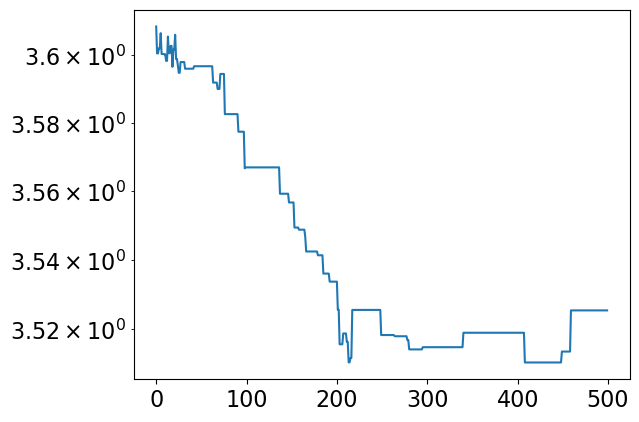

In [37]:
# diagnostics
plt.semilogy(q_b[0][:,2])

In [ ]:
q_b[]

##  Grad estimation 

In [17]:
def grad_expectation(samples,phi:list,x, verbose =False)-> list:
    if isinstance(x,np.ndarray):
        pass
    else:
        x = np.array([x])
    assert isinstance(samples,np.ndarray)
        
    prior_tmp = Prior_(x)
    #samples = B_samples[:,:]
    Jac_temp_phi = np.ndarray((phi[0].shape[0],phi[0].shape[1],samples.shape[0])) #D1: dim of para, D2: dimention of samples
    Jac_temp_sigma = np.ndarray((phi[1].shape[0],samples.shape[0]))
    for i in range(0, samples.shape[0]):
        jac_phi, jac_Sigma = prior_tmp.logeval(samples[i,:], phi=phi)[1:3]
        Jac_temp_phi[:,:,i]=jac_phi
        Jac_temp_sigma[:,i]=jac_Sigma
    if verbose:
        
        print("The sd of the phi and sigma gradeints are \n {} and {} resp.".format(np.std(Jac_temp_phi,axis=2), np.std(Jac_temp_sigma,axis=1)))
        print("The mean of the phi and sigma gradeints are \n {} and {} resp.".format(np.mean(Jac_temp_phi,axis=2), np.mean(Jac_temp_sigma,axis=1)))
    
    #Jac_grad_mean = np.mean(Jac_approx,axis=2)
    return np.mean(Jac_temp_phi,axis=2), np.mean(Jac_temp_sigma,axis=1)

In [18]:
b,c = grad_expectation(q_b_N[1],phi_test,x=np.array([0.2]),verbose=True)

NameError: name 'q_b_N' is not defined

In [19]:
def df_dphi(q_list:list,phi:list,x_N,**kwargs)-> list:
    """
    COmputing grad foer the ELBO check eq 9 in the document. This needs grad approx for a given q_i from the above function
    Parameters
    ----------
    q_list : list
    samples of the q_i from the E step for a given phi
    phi : np.ndarray
    x_N :

    Returns
    -------

    """
    assert isinstance(q_list,list), "samples must be passed as a list"
    grad_phi_total = np.zeros(phi[0].shape)
    grad_sigma_total = np.zeros(phi[1].shape)
    #gradient = np.zeros(phi.shape)
    for i,val in enumerate(q_list):
        gradient_phi, gradient_sigma = grad_expectation(val,phi,x_N[i],**kwargs)
        grad_phi_total = grad_phi_total+ gradient_phi
        grad_sigma_total = grad_sigma_total + gradient_sigma
        
    return [grad_phi_total/len(q_list), grad_sigma_total/len(q_list)]  # normalizing by number of training data points


In [39]:
phi_test

[array([[-0.66933392,  2.35040943],
        [ 0.01772298,  5.41448282],
        [ 0.02124264,  3.713981  ],
        [-0.41693184,  4.26386979]]),
 array([-2.4950871 , -2.41963803, -2.41293984, -2.43903026])]

In [41]:
df_dphi(q_b_N,phi_test,np.array(list(hydration_data.keys())),verbose=True)

The sd of the phi and sigma gradeints are 
 [[0.         0.00558418]
 [0.         0.02135255]
 [0.         0.01558395]
 [0.         0.00882053]] and [2.65152905e-04 3.91217190e-04 1.37188802e-05 2.89774804e-04] resp.
The mean of the phi and sigma gradeints are 
 [[ 0.         -0.57697213]
 [ 0.          0.20714802]
 [ 0.         -0.00644948]
 [ 0.         -0.37749656]] and [-0.4862679  -0.49807064 -0.4999867  -0.49377964] resp.
The sd of the phi and sigma gradeints are 
 [[0.00132576 0.00662882]
 [0.00456279 0.02281393]
 [0.00479348 0.02396742]
 [0.00303932 0.0151966 ]] and [3.59705905e-04 3.98407760e-04 6.31100469e-05 5.04762935e-04] resp.
The mean of the phi and sigma gradeints are 
 [[ 0.13158901  0.65794506]
 [-0.04177758 -0.20888789]
 [-0.00629973 -0.03149864]
 [ 0.07511351  0.37556754]] and [-0.48214312 -0.49803558 -0.4999293  -0.49383633] resp.
The sd of the phi and sigma gradeints are 
 [[0.00593388 0.00741734]
 [0.01915869 0.02394837]
 [0.00930909 0.01163636]
 [0.00638623 0.00

[array([[-1.15706930e-03, -1.57461266e-04],
        [-3.36506507e-03,  1.29529157e-02],
        [-2.17991496e-02, -3.25043166e-02],
        [-1.44549976e-05,  2.99532497e-04]]),
 array([-0.49003561, -0.49877151, -0.49991347, -0.49358296])]

In [20]:
import copy
def M_step(gradient,start,learn_rate:list,q_list,x_N,**kwargs):
    """

    Parameters
    ----------
    gradient : callable
    Pass the arguments kwargs of teh grad func here
    start : the phi value goes here
    learn_rate :
    n_iter :
    tol :

    Returns
    -------

    """

    vector = copy.deepcopy(start)
    grad = gradient(q_list = q_list, phi=vector,x_N=x_N,**kwargs)
    assert len(grad) == len(learn_rate)
    print("gradient ascent is being performed")
    for i,v in enumerate(grad): 
        # -- normal grad ascent
        diff = learn_rate[i]*v
        vector[i] = vector[i] + diff
        # -- trying adam steps here
        
        
        
        #vector[i] = vector[i] + learn_rate*mhat/
        
    #diff = learn_rate*(grad) # since it is a gradeint ascent here
    #print(diff)
    #vector = vector + diff
    return vector,grad

In [ ]:
M_step(df_dphi,phi_test,0.001,q_b,np.array(list(hydration_data.keys())),verbose=True)

In [22]:
def EM_run(E_,M_,data, b_init, phi_init,steps = 20, verbose = True):
    gradients = []
    parameters = []
    
    cov_scale = 0.000001
    learning_rate_init = [0.05,0.05]
    # cache for adaGRAD
    G = [np.zeros(phi_init[0].shape),np.zeros(phi_init[1].shape)]
    eps = 1e-08
    
    for i in range(steps):
        
    # E - step
        if i == 0: # returns coeff samples for N datasets
            q_b_N, a_r = E_(400,cov_scale,b_init,burnin = 100,phi = phi_init,obs_data = data)      
        elif i>(steps-20):
            q_b_N, a_r = E_(250,cov_scale,b_init,burnin = 40,phi = phi_init,obs_data = data)
        else :
            q_b_N, a_r = E_(90,cov_scale,b_init,burnin = 20,phi = phi_init,obs_data = data)
        
        # Adjusting the proposal in MCMCM after each EM iteration
        if a_r<0.2:
            cov_scale = 0.9*cov_scale
        if a_r>0.5:
            cov_scale = 1.1*cov_scale
        print(f"The cov scale is {cov_scale}")

    # M - step     
        # computing the grads
        grad = df_dphi(q_list=q_b_N,phi=phi_init,x_N=np.array(list(data.keys())))
        for n,v in enumerate(grad): #iterating over {phis} and {diag(sigma)}
        # ADAGRAD -- update the learning rate
        # https://optimization.cbe.cornell.edu/index.php?title=AdaGrad
            G[n]+=grad[n]**2
            learning_rate = learning_rate_init[n]/(np.sqrt(G[n]) + eps)
            
            diff = learning_rate*grad[n]
            phi_init[n] = phi_init[n] + diff # perfroming grad ascent
            if verbose:
                print(f"The leanring rate rho_t of ADAGRAD : {learning_rate}")
    
            #phi_next, grad = M_(df_dphi,phi_init,learning_rate,q_b_N,np.array(list(data.keys())))
        if verbose:
            print(f"For {i}th iteration of the EM algorigthm")
            print("The phi and gradients of phi are \n {} and \n {} resp.".format(phi_init, grad))
            
               
        gradients.append(grad)
        parameters.append(phi_init.copy())
        b_init = np.dstack(q_b_N)[-1,:,:].T # starting the next E step from samples from previous iteration
    
#         if np.linalg.norm(grad[-1,:])<1:
#             break
    return  q_b_N, gradients, parameters

In [23]:
q_b_N, grad, parameters = EM_run(E_step,M_step,hydration_data_train,b_init=np.random.normal(1,0.02,4)*b_opt,phi_init=phi_test,steps=220)

100%|███████████████████████████████████████████████| 400/400 [01:00<00:00,  6.59it/s]


Acceptance ratio: 0.185 and cov scale: 1.0


100%|███████████████████████████████████████████████| 400/400 [01:01<00:00,  6.55it/s]


Acceptance ratio: 0.175 and cov scale: 1.0


100%|███████████████████████████████████████████████| 400/400 [01:13<00:00,  5.43it/s]


Acceptance ratio: 0.16 and cov scale: 1.0


100%|███████████████████████████████████████████████| 400/400 [01:21<00:00,  4.93it/s]


Acceptance ratio: 0.205 and cov scale: 1.0
The cov scale is 9e-07
The leanring rate rho_t of ADAGRAD : [[0.0712535  0.06196579]
 [0.17399159 0.10437983]
 [0.50531644 0.25121737]
 [0.10575975 0.08892356]]
The leanring rate rho_t of ADAGRAD : [0.17729449 0.10992558 0.10148951 0.12481786]
For 0th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.05      ,  2.16665841],
       [ 0.05      ,  6.33614865],
       [-0.04999999,  3.52562839],
       [-0.05      ,  4.13829007]]), array([-1.05, -1.05, -1.05, -1.05])] and 
 [array([[-0.70171986, -0.80689689],
       [ 0.2873702 ,  0.47901974],
       [-0.09894789, -0.19903081],
       [-0.47276962, -0.56228066]]), array([-0.28201664, -0.45485319, -0.49266173, -0.4005837 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:13<00:00,  6.59it/s]


Acceptance ratio: 0.1 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:13<00:00,  6.51it/s]


Acceptance ratio: 0.12222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.44it/s]


Acceptance ratio: 0.15555555555555556 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.94it/s]


Acceptance ratio: 0.06666666666666667 and cov scale: 1.0
The cov scale is 8.1e-07
The leanring rate rho_t of ADAGRAD : [[0.05410082 0.04905992]
 [0.16257393 0.09826413]
 [0.4662917  0.24547765]
 [0.08408723 0.0748011 ]]
The leanring rate rho_t of ADAGRAD : [0.11252    0.07444619 0.07128459 0.08379932]
For 1th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.08253865,  2.13611459],
       [ 0.06781415,  6.35301198],
       [-0.03073264,  3.53625539],
       [-0.08032537,  4.11125265]]), array([-1.08863997, -1.08678803, -1.08558992, -1.08705599])] and 
 [array([[-0.60144467, -0.6225821 ],
       [ 0.1095757 ,  0.1716123 ],
       [ 0.0413204 ,  0.04329112],
       [-0.36064186, -0.36145757]]), array([-0.34340539, -0.49415594, -0.49926535, -0.44219918])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:13<00:00,  6.54it/s]


Acceptance ratio: 0.15555555555555556 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.41it/s]


Acceptance ratio: 0.17777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.22it/s]


Acceptance ratio: 0.13333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.87it/s]


Acceptance ratio: 0.16666666666666666 and cov scale: 1.0
The cov scale is 7.29e-07
The leanring rate rho_t of ADAGRAD : [[0.04677591 0.04398455]
 [0.16125594 0.09791676]
 [0.46535012 0.24517928]
 [0.07529745 0.07008977]]
The leanring rate rho_t of ADAGRAD : [0.08603694 0.05974936 0.05805302 0.06643117]
For 2th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.10766113,  2.11396722],
       [ 0.07416794,  6.35721248],
       [-0.02755675,  3.53379094],
       [-0.10258164,  4.09378821]]), array([-1.12086304, -1.11661495, -1.11460625, -1.1175339 ])] and 
 [array([[-0.53708168, -0.50352621],
       [ 0.03940189,  0.04289868],
       [ 0.00682473, -0.01005163],
       [-0.29557791, -0.24917234]]), array([-0.37452594, -0.49920071, -0.49982465, -0.45878936])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:13<00:00,  6.51it/s]


Acceptance ratio: 0.1111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.41it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.37it/s]


Acceptance ratio: 0.2 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.85it/s]


Acceptance ratio: 0.15555555555555556 and cov scale: 1.0
The cov scale is 6.561000000000001e-07
The leanring rate rho_t of ADAGRAD : [[0.04257145 0.04138589]
 [0.16118316 0.09756653]
 [0.46376281 0.24516696]
 [0.07050619 0.06826955]]
The leanring rate rho_t of ADAGRAD : [0.07120667 0.05130991 0.05020787 0.05643621]
For 3th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.12837894,  2.0970356 ],
       [ 0.07266583,  6.35298732],
       [-0.0234305 ,  3.53429213],
       [-0.12013252,  4.08246729]]), array([-1.14892681, -1.14223448, -1.1397067 , -1.14390979])] and 
 [array([[-0.48665968, -0.40911573],
       [-0.00931926, -0.04330549],
       [ 0.00889733,  0.00204431],
       [-0.2489268 , -0.16582677]]), array([-0.39411716, -0.49930947, -0.4999306 , -0.46735757])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.35it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.26it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.40it/s]


Acceptance ratio: 0.15555555555555556 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.69it/s]


Acceptance ratio: 0.13333333333333333 and cov scale: 1.0
The cov scale is 5.9049e-07
The leanring rate rho_t of ADAGRAD : [[0.03982079 0.03993787]
 [0.16077468 0.09599352]
 [0.46326156 0.24512464]
 [0.06747409 0.06758002]]
The leanring rate rho_t of ADAGRAD : [0.06158751 0.04569329 0.04487041 0.0498166 ]
For 4th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.14606021,  2.08392528],
       [ 0.06910841,  6.34404515],
       [-0.02110643,  3.53522118],
       [-0.13463769,  4.07537888]]), array([-1.17402299, -1.16498019, -1.16214068, -1.16740603])] and 
 [array([[-0.44402086, -0.32826786],
       [-0.02212675, -0.09315388],
       [ 0.00501675,  0.0037901 ],
       [-0.21497397, -0.1048892 ]]), array([-0.40748815, -0.49779117, -0.49997267, -0.47165481])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.37it/s]


Acceptance ratio: 0.14444444444444443 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.21it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.38it/s]


Acceptance ratio: 0.05555555555555555 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.90it/s]


Acceptance ratio: 0.14444444444444443 and cov scale: 1.0
The cov scale is 5.314410000000001e-07
The leanring rate rho_t of ADAGRAD : [[0.03786849 0.03909771]
 [0.1602168  0.0938574 ]
 [0.46244692 0.24483281]
 [0.06542339 0.06738411]]
The leanring rate rho_t of ADAGRAD : [0.05478907 0.04160483 0.04093867 0.04503702]
For 5th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.16152393,  2.07372347],
       [ 0.06494674,  6.33355583],
       [-0.01814255,  3.53766025],
       [-0.14687096,  4.07157447]]), array([-1.1968587 , -1.185653  , -1.18260837, -1.18877669])] and 
 [array([[-0.40835349, -0.26093101],
       [-0.02597525, -0.11175807],
       [ 0.00640914,  0.00996218],
       [-0.18698621, -0.05645861]]), array([-0.41679325, -0.49688482, -0.49995994, -0.47451314])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.15it/s]


Acceptance ratio: 0.15555555555555556 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.09it/s]


Acceptance ratio: 0.15555555555555556 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.22it/s]


Acceptance ratio: 0.13333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.63it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0
The cov scale is 4.782969000000001e-07
The leanring rate rho_t of ADAGRAD : [[0.03641195 0.03861264]
 [0.15946082 0.09147581]
 [0.46021634 0.24452582]
 [0.06399164 0.06735949]]
The leanring rate rho_t of ADAGRAD : [0.04969192 0.03845222 0.03788737 0.04137744]
For 6th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.17525771,  2.06587184],
       [ 0.06009526,  6.32236374],
       [-0.01323754,  3.54016336],
       [-0.15727405,  4.07022297]]), array([-1.21791871, -1.20474544, -1.20154983, -1.2085195 ])] and 
 [array([[-0.3771776 , -0.20334371],
       [-0.03042426, -0.12235021],
       [ 0.01065804,  0.01023658],
       [-0.16256951, -0.02006397]]), array([-0.42381159, -0.49652381, -0.49994108, -0.47713948])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.07it/s]


Acceptance ratio: 0.15555555555555556 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.05it/s]


Acceptance ratio: 0.16666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.21it/s]


Acceptance ratio: 0.18888888888888888 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.75it/s]


Acceptance ratio: 0.15555555555555556 and cov scale: 1.0
The cov scale is 4.304672100000001e-07
The leanring rate rho_t of ADAGRAD : [[0.03528192 0.03834398]
 [0.15853659 0.08898712]
 [0.4584656  0.24443941]
 [0.06291139 0.06735829]]
The leanring rate rho_t of ADAGRAD : [0.04571302 0.03592449 0.03543071 0.0384693 ]
For 7th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.18761754,  2.05998385],
       [ 0.05471977,  6.31078016],
       [-0.00888041,  3.54149244],
       [-0.16642243,  4.0705207 ]]), array([-1.237523  , -1.22257465, -1.21926127, -1.22693329])] and 
 [array([[-0.35031633, -0.15355708],
       [-0.03390696, -0.13017147],
       [ 0.00950374,  0.00543727],
       [-0.14541695,  0.00442015]]), array([-0.42885571, -0.4962967 , -0.49988976, -0.47866188])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.39it/s]


Acceptance ratio: 0.16666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.16it/s]


Acceptance ratio: 0.16666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.18it/s]


Acceptance ratio: 0.16666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.73it/s]


Acceptance ratio: 0.12222222222222222 and cov scale: 1.0
The cov scale is 3.874204890000001e-07
The leanring rate rho_t of ADAGRAD : [[0.03437884 0.03820715]
 [0.15783891 0.08647621]
 [0.45743567 0.24442701]
 [0.06204226 0.06732877]]
The leanring rate rho_t of ADAGRAD : [0.04250833 0.03384257 0.0333976  0.03609081]
For 8th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-1.98857773e-01,  2.05576363e+00],
       [ 5.00341370e-02,  6.29898641e+00],
       [-5.53082518e-03,  3.54199617e+00],
       [-1.74704861e-01,  4.07200103e+00]]), array([-1.25591419, -1.23934865, -1.235955  , -1.24424179])] and 
 [array([[-0.32695209, -0.11045618],
       [-0.02968616, -0.13638142],
       [ 0.00732252,  0.00206087],
       [-0.13349656,  0.02198658]]), array([-0.43264891, -0.49564778, -0.4998481 , -0.47958215])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.18it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.35it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.04it/s]


Acceptance ratio: 0.14444444444444443 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.54it/s]


Acceptance ratio: 0.18888888888888888 and cov scale: 1.0
The cov scale is 3.486784401000001e-07
The leanring rate rho_t of ADAGRAD : [[0.03363816 0.03814907]
 [0.1570769  0.08380833]
 [0.45687575 0.24430413]
 [0.06130384 0.06725408]]
The leanring rate rho_t of ADAGRAD : [0.03986632 0.03208943 0.03167822 0.03410051]
For 9th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.09180657e-01,  2.05300761e+00],
       [ 4.51269418e-02,  6.28666263e+00],
       [-3.05766752e-03,  3.54358142e+00],
       [-1.82396108e-01,  4.07435542e+00]]), array([-1.27326663, -1.2552328 , -1.25179122, -1.26061652])] and 
 [array([[-0.30688013, -0.07224352],
       [-0.03124072, -0.1470472 ],
       [ 0.0054132 ,  0.00648883],
       [-0.1254611 ,  0.0350074 ]]), array([-0.4352657 , -0.49499649, -0.49990859, -0.48019022])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.15it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.25it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.09it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.62it/s]


Acceptance ratio: 0.2 and cov scale: 1.0
The cov scale is 3.486784401000001e-07
The leanring rate rho_t of ADAGRAD : [[0.03301512 0.03812964]
 [0.15661529 0.08142836]
 [0.4567869  0.24430395]
 [0.06065614 0.06715027]]
The leanring rate rho_t of ADAGRAD : [0.03764308 0.03058752 0.03019963 0.03240111]
For 10th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.18759387e-01,  2.05141197e+00],
       [ 4.12964788e-02,  6.27483162e+00],
       [-2.07167472e-03,  3.54352099e+00],
       [-1.89645127e-01,  4.07713247e+00]]), array([-1.28973056, -1.2703504 , -1.26688854, -1.27620392])] and 
 [array([[-2.90131613e-01, -4.18476969e-02],
       [-2.44577850e-02, -1.45293479e-01],
       [ 2.15853998e-03, -2.47383253e-04],
       [-1.19510058e-01,  4.13557427e-02]]), array([-0.43736926, -0.49424087, -0.4999176 , -0.48107595])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.12it/s]


Acceptance ratio: 0.17777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.20it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.08it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.65it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0
The cov scale is 3.138105960900001e-07
The leanring rate rho_t of ADAGRAD : [[0.03248588 0.03812782]
 [0.15527929 0.07830906]
 [0.45630904 0.24425493]
 [0.06007685 0.06702703]]
The leanring rate rho_t of ADAGRAD : [0.03574129 0.02928469 0.02891025 0.03092725]
For 11th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.27676123e-01,  2.05092417e+00],
       [ 3.47795511e-02,  6.26112513e+00],
       [ 2.14800874e-04,  3.54452257e+00],
       [-1.96538855e-01,  4.08016035e+00]]), array([-1.3054222 , -1.28478758, -1.28134261, -1.29111253])] and 
 [array([[-0.27448032, -0.01279369],
       [-0.04196907, -0.17503068],
       [ 0.0050108 ,  0.00410057],
       [-0.11474848,  0.04517407]]), array([-0.43903399, -0.49299411, -0.4999635 , -0.48205449])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.10it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.90it/s]


Acceptance ratio: 0.12222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.08it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.64it/s]


Acceptance ratio: 0.2 and cov scale: 1.0
The cov scale is 2.824295364810001e-07
The leanring rate rho_t of ADAGRAD : [[0.03202651 0.03812668]
 [0.15414069 0.07567591]
 [0.4557097  0.24392817]
 [0.05956262 0.06685981]]
The leanring rate rho_t of ADAGRAD : [0.03409118 0.0281339  0.02777302 0.02963574]
For 12th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.36054899e-01,  2.05131119e+00],
       [ 2.87356744e-02,  6.24826826e+00],
       [ 2.77663357e-03,  3.54710798e+00],
       [-2.03066876e-01,  4.08369002e+00]]), array([-1.32043924, -1.29866646, -1.29522834, -1.30541068])] and 
 [array([[-0.26162002,  0.0101509 ],
       [-0.03921013, -0.16989376],
       [ 0.00562163,  0.01059907],
       [-0.10959929,  0.05279196]]), array([-0.44049655, -0.49331493, -0.49997179, -0.48246292])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.03it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.18it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.06it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.63it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0
The cov scale is 2.824295364810001e-07
The leanring rate rho_t of ADAGRAD : [[0.03162332 0.03811606]
 [0.15296754 0.07301514]
 [0.45537921 0.24334693]
 [0.05909866 0.06665097]]
The leanring rate rho_t of ADAGRAD : [0.03264324 0.02711101 0.02676037 0.02849256]
For 13th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.43963739e-01,  2.05249095e+00],
       [ 2.25785840e-02,  6.23512635e+00],
       [ 4.68051680e-03,  3.55055763e+00],
       [-2.09295446e-01,  4.08763888e+00]]), array([-1.33485636, -1.31202629, -1.30860686, -1.31916398])] and 
 [array([[-0.25009519,  0.03095173],
       [-0.04025096, -0.17998887],
       [ 0.00418087,  0.01417585],
       [-0.10539274,  0.05924698]]), array([-0.44165688, -0.49278249, -0.49993778, -0.482698  ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.18888888888888888 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.02it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.04it/s]


Acceptance ratio: 0.17777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.49it/s]


Acceptance ratio: 0.16666666666666666 and cov scale: 1.0
The cov scale is 2.5418658283290006e-07
The leanring rate rho_t of ADAGRAD : [[0.03126162 0.03809262]
 [0.15236454 0.07092871]
 [0.45516435 0.2429609 ]
 [0.0586803  0.06642226]]
The leanring rate rho_t of ADAGRAD : [0.03135909 0.02619099 0.02585097 0.02746939]
For 14th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.51504468e-01,  2.05424444e+00],
       [ 1.81433564e-02,  6.22325897e+00],
       [ 6.21628037e-03,  3.55337282e+00],
       [-2.15234311e-01,  4.09177747e+00]]), array([-1.34874256, -1.3249413 , -1.3215308 , -1.33244274])] and 
 [array([[-0.24121365,  0.04603234],
       [-0.02910932, -0.16731428],
       [ 0.00337409,  0.01158698],
       [-0.10120712,  0.06230724]]), array([-0.44281262, -0.49310897, -0.49994037, -0.483402  ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.00it/s]


Acceptance ratio: 0.14444444444444443 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.05it/s]


Acceptance ratio: 0.2 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.02it/s]


Acceptance ratio: 0.2 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.50it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0
The cov scale is 2.2876792454961005e-07
The leanring rate rho_t of ADAGRAD : [[0.03093145 0.03805364]
 [0.15186448 0.06896188]
 [0.45497544 0.2428673 ]
 [0.0582753  0.06620501]]
The leanring rate rho_t of ADAGRAD : [0.03021235 0.02536004 0.02502838 0.0265471 ]
For 15th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.58752062e-01,  2.05650581e+00],
       [ 1.40957729e-02,  6.21156598e+00],
       [ 4.77590277e-03,  3.55476061e+00],
       [-2.21098587e-01,  4.09581809e+00]]), array([-1.3621402 , -1.33743595, -1.33404361, -1.34529024])] and 
 [array([[-0.23431149,  0.05942562],
       [-0.0266526 , -0.16955723],
       [-0.00316584,  0.00571422],
       [-0.10063055,  0.06103199]]), array([-0.44344938, -0.49269049, -0.49994483, -0.4839513 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.12it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.01it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.07it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.71it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0
The cov scale is 2.2876792454961005e-07
The leanring rate rho_t of ADAGRAD : [[0.03063004 0.03799881]
 [0.15116972 0.06688902]
 [0.45497497 0.24264202]
 [0.0578829  0.06601049]]
The leanring rate rho_t of ADAGRAD : [0.02917824 0.02460443 0.02427965 0.02570963]
For 16th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.65715153e-01,  2.05918900e+00],
       [ 9.31852329e-03,  6.19939913e+00],
       [ 4.84815165e-03,  3.55691367e+00],
       [-2.26891222e-01,  4.09964808e+00]]), array([-1.37510983, -1.34955025, -1.34618196, -1.35774996])] and 
 [array([[-2.27328803e-01,  7.06126209e-02],
       [-3.16018953e-02, -1.81896081e-01],
       [ 1.58797494e-04,  8.87337807e-03],
       [-1.00075077e-01,  5.80207928e-02]]), array([-0.44449663, -0.49236282, -0.49993901, -0.4846322 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.28it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.14it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.05it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.55it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0
The cov scale is 2.2876792454961005e-07
The leanring rate rho_t of ADAGRAD : [[0.03035101 0.03792876]
 [0.15071794 0.06504569]
 [0.45466389 0.24205833]
 [0.05752975 0.06580396]]
The leanring rate rho_t of ADAGRAD : [0.0282404  0.02391309 0.02359432 0.02494428]
For 17th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.72448712e-01,  2.06222350e+00],
       [ 5.45581066e-03,  6.18774188e+00],
       [ 6.69679825e-03,  3.56037969e+00],
       [-2.32405992e-01,  4.10360025e+00]]), array([-1.38768466, -1.36131962, -1.35797778, -1.36985903])] and 
 [array([[-0.22185613,  0.08000535],
       [-0.02562875, -0.17921629],
       [ 0.00406596,  0.01431895],
       [-0.09585944,  0.06005982]]), array([-0.44527809, -0.4921727 , -0.49994354, -0.48544495])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.03it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.16it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.96it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.59it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0
The cov scale is 2.2876792454961005e-07
The leanring rate rho_t of ADAGRAD : [[0.03008897 0.03784681]
 [0.15042087 0.06319878]
 [0.45464553 0.24178133]
 [0.05719582 0.06559132]]
The leanring rate rho_t of ADAGRAD : [0.02738503 0.02327967 0.02296392 0.02424254]
For 18th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.79004796e-01,  2.06550851e+00],
       [ 2.31809651e-03,  6.17591165e+00],
       [ 6.24752647e-03,  3.56277105e+00],
       [-2.37785390e-01,  4.10761654e+00]]), array([-1.39989738, -1.37275149, -1.36945851, -1.38163539])] and 
 [array([[-0.21788993,  0.08679747],
       [-0.02085957, -0.18719077],
       [-0.00098818,  0.00989061],
       [-0.09405231,  0.06123196]]), array([-0.44596335, -0.49106686, -0.49994625, -0.48577256])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.27it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.98it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.02it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.52it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0
The cov scale is 2.2876792454961005e-07
The leanring rate rho_t of ADAGRAD : [[0.02984371 0.03775154]
 [0.15026392 0.06148072]
 [0.45452634 0.24156409]
 [0.05686664 0.06540408]]
The leanring rate rho_t of ADAGRAD : [0.02660036 0.02269489 0.02238153 0.02359609]
For 19th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.85375858e-01,  2.06905398e+00],
       [ 3.45668816e-05,  6.16433246e+00],
       [ 5.10270171e-03,  3.56489011e+00],
       [-2.43142081e-01,  4.11139193e+00]]), array([-1.41178069, -1.38388799, -1.3806476 , -1.393105  ])] and 
 [array([[-0.21348092,  0.09391574],
       [-0.01519679, -0.18833855],
       [-0.00251872,  0.00877224],
       [-0.09419742,  0.05772411]]), array([-0.44673496, -0.49070498, -0.49992526, -0.48608075])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.11it/s]


Acceptance ratio: 0.2 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.17it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.05it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.49it/s]


Acceptance ratio: 0.2 and cov scale: 1.0
The cov scale is 2.2876792454961005e-07
The leanring rate rho_t of ADAGRAD : [[0.02960933 0.03765211]
 [0.15021208 0.05992858]
 [0.45452383 0.24132944]
 [0.05655864 0.0652241 ]]
The leanring rate rho_t of ADAGRAD : [0.02587688 0.02215297 0.02184127 0.02299735]
For 20th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.91629941e-01,  2.07268059e+00],
       [-1.27870053e-03,  6.15316839e+00],
       [ 4.93646091e-03,  3.56709343e+00],
       [-2.48338913e-01,  4.11509868e+00]]), array([-1.42336263, -1.39474921, -1.39156716, -1.40429709])] and 
 [array([[-0.21122   ,  0.09631913],
       [-0.00874276, -0.18628968],
       [-0.00036575,  0.00912993],
       [-0.09188396,  0.05683098]]), array([-0.44757877, -0.49028291, -0.4999508 , -0.4866685 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.29it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.03it/s]


Acceptance ratio: 0.17777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.05it/s]


Acceptance ratio: 0.2 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.57it/s]


Acceptance ratio: 0.2 and cov scale: 1.0
The cov scale is 2.0589113209464905e-07
The leanring rate rho_t of ADAGRAD : [[0.02938453 0.0375488 ]
 [0.15021173 0.05868301]
 [0.45388349 0.2412745 ]
 [0.05625264 0.06506519]]
The leanring rate rho_t of ADAGRAD : [0.02520705 0.02164712 0.02133839 0.02244108]
For 21th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-2.97779470e-01,  2.07638185e+00],
       [-1.38590375e-03,  6.14302733e+00],
       [ 2.28332660e-03,  3.56816027e+00],
       [-2.53533014e-01,  4.11858681e+00]]), array([-1.43466537, -1.4053732 , -1.40223472, -1.41522777])] and 
 [array([[-0.2092778 ,  0.09857198],
       [-0.00071368, -0.17281079],
       [-0.00584541,  0.00442168],
       [-0.09233524,  0.0536098 ]]), array([-0.44839579, -0.49078046, -0.49992301, -0.48708369])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.94it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.98it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.08it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.58it/s]


Acceptance ratio: 0.16666666666666666 and cov scale: 1.0
The cov scale is 1.8530201888518414e-07
The leanring rate rho_t of ADAGRAD : [[0.02917001 0.03743852]
 [0.1502114  0.05734591]
 [0.45378585 0.24076336]
 [0.05595171 0.06491513]]
The leanring rate rho_t of ADAGRAD : [0.02458468 0.02117709 0.02086876 0.02192287]
For 22th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.03810084e-01,  2.08021117e+00],
       [-1.28084509e-03,  6.13241472e+00],
       [ 1.24624278e-03,  3.57141314e+00],
       [-2.58697918e-01,  4.12198067e+00]]), array([-1.44570744, -1.41573598, -1.41266705, -1.42591084])] and 
 [array([[-0.20674016,  0.10228271],
       [ 0.00069941, -0.18506305],
       [-0.0022854 ,  0.01351066],
       [-0.09231002,  0.05228153]]), array([-0.44914432, -0.4893392 , -0.49990203, -0.48730246])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.17it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.87it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.98it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.59it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 1.8530201888518414e-07
The leanring rate rho_t of ADAGRAD : [[0.02896362 0.03732428]
 [0.15020505 0.05603896]
 [0.45377713 0.23988658]
 [0.05568189 0.06474251]]
The leanring rate rho_t of ADAGRAD : [0.02400464 0.02073754 0.02042884 0.02143801]
For 23th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.09747518e-01,  2.08411431e+00],
       [-8.21265702e-04,  6.12180080e+00],
       [ 9.36338864e-04,  3.57567637e+00],
       [-2.63602410e-01,  4.12562457e+00]]), array([-1.4565045 , -1.42587023, -1.42287924, -1.43636833])] and 
 [array([[-0.2049963 ,  0.10457376],
       [ 0.00305968, -0.18940252],
       [-0.00068294,  0.01777185],
       [-0.08808056,  0.05628293]]), array([-0.44979085, -0.48869096, -0.49989064, -0.48780137])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.10it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.95it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.90it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.49it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0
The cov scale is 1.8530201888518414e-07
The leanring rate rho_t of ADAGRAD : [[0.02876624 0.03720761]
 [0.15016291 0.05465893]
 [0.45305312 0.2396934 ]
 [0.05541767 0.06458422]]
The leanring rate rho_t of ADAGRAD : [0.02346151 0.020324   0.02001561 0.02098322]
For 24th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.15574743e-01,  2.08806456e+00],
       [-2.00555794e-03,  6.11077287e+00],
       [-1.88699945e-03,  3.57768262e+00],
       [-2.68467515e-01,  4.12911877e+00]]), array([-1.46708045, -1.43580566, -1.43288507, -1.44661268])] and 
 [array([[-0.20257163,  0.10616785],
       [-0.00788672, -0.20175897],
       [-0.0062318 ,  0.00837008],
       [-0.08778978,  0.05410307]]), array([-0.45077879, -0.48885241, -0.49990175, -0.4882165 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.14it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.01it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.03it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.41it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0
The cov scale is 1.8530201888518414e-07
The leanring rate rho_t of ADAGRAD : [[0.02857647 0.0370882 ]
 [0.15015922 0.05338991]
 [0.45304564 0.23915392]
 [0.05516758 0.06443984]]
The leanring rate rho_t of ADAGRAD : [0.02295187 0.01993513 0.01962646 0.02055531]
For 25th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.21308561e-01,  2.09206707e+00],
       [-2.35616797e-03,  6.10006132e+00],
       [-2.17426473e-03,  3.58103535e+00],
       [-2.73212308e-01,  4.13246024e+00]]), array([-1.47744534, -1.44553985, -1.44269668, -1.45665887])] and 
 [array([[-0.20064824,  0.10791867],
       [-0.00233492, -0.20062872],
       [-0.00063408,  0.01401911],
       [-0.0860069 ,  0.05185403]]), array([-0.45159228, -0.48829333, -0.49991729, -0.48873926])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.23it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.02it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.56it/s]


Acceptance ratio: 0.18888888888888888 and cov scale: 1.0
The cov scale is 1.6677181699666574e-07
The leanring rate rho_t of ADAGRAD : [[0.02839389 0.03696926]
 [0.15015847 0.0522025 ]
 [0.45287403 0.2389583 ]
 [0.05492682 0.06430798]]
The leanring rate rho_t of ADAGRAD : [0.02247201 0.01956779 0.01925917 0.02015158]
For 26th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.26951661e-01,  2.09606830e+00],
       [-2.51437294e-03,  6.08957488e+00],
       [-3.55035878e-03,  3.58305726e+00],
       [-2.77878523e-01,  4.13565718e+00]]), array([-1.48761607, -1.45509414, -1.45232437, -1.46651991])] and 
 [array([[-0.19874351,  0.10823141],
       [-0.00105359, -0.20088021],
       [-0.00303858,  0.00846134],
       [-0.0849533 ,  0.04971293]]), array([-0.45259523, -0.48826613, -0.49990142, -0.48934324])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.92it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.58it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0
The cov scale is 1.6677181699666574e-07
The leanring rate rho_t of ADAGRAD : [[0.02821411 0.03685841]
 [0.15004722 0.05135872]
 [0.45287204 0.23873462]
 [0.0547106  0.064172  ]]
The leanring rate rho_t of ADAGRAD : [0.02201931 0.01921835 0.01891169 0.01977024]
For 27th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.32569197e-01,  2.09993733e+00],
       [-5.90043930e-04,  6.08062143e+00],
       [-3.69850142e-03,  3.58522018e+00],
       [-2.82310695e-01,  4.13890698e+00]]), array([-1.49760162, -1.46450119, -1.46177944, -1.47620098])] and 
 [array([[-0.19910375,  0.10496988],
       [ 0.01282482, -0.17433145],
       [-0.00032712,  0.00905993],
       [-0.08101123,  0.05064202]]), array([-0.45349084, -0.4894829 , -0.49995919, -0.48967924])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.05it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.98it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.42it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 1.6677181699666574e-07
The leanring rate rho_t of ADAGRAD : [[0.02804139 0.03674747]
 [0.14988253 0.05051231]
 [0.45246261 0.23839247]
 [0.05451371 0.06404087]]
The leanring rate rho_t of ADAGRAD : [0.02159121 0.01888809 0.01858238 0.01940884]
For 28th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.38093235e-01,  2.10381381e+00],
       [ 1.75197962e-03,  6.07158132e+00],
       [-1.57285977e-03,  3.58789614e+00],
       [-2.86548702e-01,  4.14210180e+00]]), array([-1.50741309, -1.47373065, -1.47106958, -1.48571745])] and 
 [array([[-0.19699585,  0.10548994],
       [ 0.01562573, -0.1789685 ],
       [ 0.00469794,  0.01122503],
       [-0.07774204,  0.04988728]]), array([-0.45441973, -0.48863855, -0.49994314, -0.4903162 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.10it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.69it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.98it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.51it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 1.6677181699666574e-07
The leanring rate rho_t of ADAGRAD : [[0.02787537 0.036632  ]
 [0.14982077 0.04949101]
 [0.45205525 0.23763299]
 [0.05433751 0.0638871 ]]
The leanring rate rho_t of ADAGRAD : [0.02118605 0.01857649 0.01826975 0.01906625]
For 29th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.43526098e-01,  2.10777443e+00],
       [ 3.18720464e-03,  6.06157773e+00],
       [ 5.48345567e-04,  3.59188409e+00],
       [-2.90565517e-01,  4.14556463e+00]]), array([-1.51705384, -1.48277538, -1.4802027 , -1.49507045])] and 
 [array([[-0.19489835,  0.10811904],
       [ 0.00957961, -0.20212944],
       [ 0.00469236,  0.01678199],
       [-0.07392342,  0.05420236]]), array([-0.45505177, -0.48689141, -0.49990409, -0.49055223])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.88it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.92it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.58it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0
The cov scale is 1.6677181699666574e-07
The leanring rate rho_t of ADAGRAD : [[0.02771306 0.03651761]
 [0.14979913 0.04842238]
 [0.45172212 0.23757097]
 [0.05416803 0.06374812]]
The leanring rate rho_t of ADAGRAD : [0.02080209 0.01828075 0.01797238 0.01874049]
For 30th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.48913904e-01,  2.11172263e+00],
       [ 4.03694695e-03,  6.05124351e+00],
       [-1.37085413e-03,  3.59302634e+00],
       [-2.94511505e-01,  4.14886093e+00]]), array([-1.52652992, -1.49166162, -1.48918717, -1.50427368])] and 
 [array([[-0.19441396,  0.1081176 ],
       [ 0.00567255, -0.21341831],
       [-0.00424863,  0.00480801],
       [-0.07284716,  0.05170814]]), array([-0.4555349 , -0.48609806, -0.49990453, -0.49108834])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.95it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.90it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.97it/s]


Acceptance ratio: 0.2 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.53it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0
The cov scale is 1.6677181699666574e-07
The leanring rate rho_t of ADAGRAD : [[0.02755612 0.03640625]
 [0.14978823 0.04741273]
 [0.4517014  0.2371426 ]
 [0.05399748 0.06362112]]
The leanring rate rho_t of ADAGRAD : [0.02043651 0.0179984  0.01768913 0.01843064]
For 31th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.54227506e-01,  2.11562456e+00],
       [ 4.64001764e-03,  6.04108635e+00],
       [-1.84971890e-03,  3.59602761e+00],
       [-2.98476152e-01,  4.15201540e+00]]), array([-1.53586258, -1.50041549, -1.49802906, -1.51332824])] and 
 [array([[-0.19282835,  0.10717751],
       [ 0.00402616, -0.21422861],
       [-0.00106014,  0.012656  ],
       [-0.07342283,  0.04958208]]), array([-0.45666583, -0.48636917, -0.49984819, -0.49127778])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.88it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.97it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.46it/s]


Acceptance ratio: 0.17777777777777778 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02740301 0.0362967 ]
 [0.14974851 0.04641054]
 [0.45075087 0.23700465]
 [0.05382405 0.06350724]]
The leanring rate rho_t of ADAGRAD : [0.02008849 0.0177301  0.01741891 0.01813553]
For 32th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.59491015e-01,  2.11950046e+00],
       [ 5.79144285e-03,  6.03086035e+00],
       [-5.09171608e-03,  3.59773278e+00],
       [-3.02480245e-01,  4.15500564e+00]]), array([-1.54505066, -1.5090166 , -1.50673527, -1.52223986])] and 
 [array([[-0.19207777,  0.10678377],
       [ 0.00768906, -0.22033793],
       [-0.00719244,  0.00719465],
       [-0.07439226,  0.04708515]]), array([-0.45738055, -0.48511351, -0.49981407, -0.49138967])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.00it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.99it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.55it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02725422 0.03619078]
 [0.14971087 0.04548584]
 [0.45046295 0.2369231 ]
 [0.05365199 0.06342374]]
The leanring rate rho_t of ADAGRAD : [0.01975636 0.01747291 0.01716063 0.01785368]
For 33th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.36469433,  2.12331737],
       [ 0.00691243,  6.02092914],
       [-0.00687856,  3.59904437],
       [-0.30647504,  4.1575689 ]]), array([-1.55410522, -1.51750212, -1.5153136 , -1.53102069])] and 
 [array([[-0.19091787,  0.10546645],
       [ 0.00748768, -0.21833615],
       [-0.00396668,  0.00553593],
       [-0.07445752,  0.04041483]]), array([-0.45831089, -0.48563908, -0.49988423, -0.49182205])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.83it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.95it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.52it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02711026 0.03608557]
 [0.14970817 0.0445113 ]
 [0.45034802 0.23652407]
 [0.05349752 0.06333793]]
The leanring rate rho_t of ADAGRAD : [0.01943912 0.01722733 0.01691345 0.01758434]
For 34th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.69826784e-01,  2.12712724e+00],
       [ 7.21263060e-03,  6.01063456e+00],
       [-5.74915196e-03,  3.60194505e+00],
       [-3.10266477e-01,  4.16016889e+00]]), array([-1.56302953, -1.52585559, -1.52376944, -1.53967299])] and 
 [array([[-0.18931767,  0.10557861],
       [ 0.00200524, -0.23128015],
       [ 0.00250785,  0.01226378],
       [-0.07087128,  0.04104937]]), array([-0.45909035, -0.48489615, -0.49994769, -0.4920459 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.13it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.87it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.48it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02697268 0.03597778]
 [0.14961081 0.04343782]
 [0.45032588 0.23621805]
 [0.05335643 0.0632497 ]]
The leanring rate rho_t of ADAGRAD : [0.01913553 0.01699215 0.01667666 0.01732653]
For 35th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.74857595e-01,  2.13098893e+00],
       [ 5.40968750e-03,  5.99971985e+00],
       [-5.25344116e-03,  3.60448766e+00],
       [-3.13895378e-01,  4.16280713e+00]]), array([-1.57183162, -1.5340892 , -1.53210672, -1.54820335])] and 
 [array([[-0.18651506,  0.10733547],
       [-0.01205089, -0.25127212],
       [ 0.00110078,  0.01076384],
       [-0.06801245,  0.04171159]]), array([-0.45998681, -0.48455382, -0.49993672, -0.49232927])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.95it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.83it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.92it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.49it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02683856 0.03587606]
 [0.1495827  0.04252551]
 [0.44988214 0.23619917]
 [0.05321737 0.06316674]]
The leanring rate rho_t of ADAGRAD : [0.01884459 0.01676551 0.01644953 0.01707973]
For 36th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.79837518e-01,  2.13474612e+00],
       [ 4.44050956e-03,  5.98952623e+00],
       [-7.47256191e-03,  3.60511988e+00],
       [-3.17502905e-01,  4.16536717e+00]]), array([-1.58051746, -1.54222829, -1.54033068, -1.5566126 ])] and 
 [array([[-0.185551  ,  0.10472705],
       [-0.00647921, -0.2397059 ],
       [-0.00493267,  0.00267664],
       [-0.06778851,  0.04052834]]), array([-0.46091977, -0.48546625, -0.49995107, -0.49235291])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.03it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.90it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.91it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.50it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02670915 0.03577606]
 [0.14953443 0.04166017]
 [0.44948672 0.23585716]
 [0.05308985 0.06309324]]
The leanring rate rho_t of ADAGRAD : [0.01856551 0.01654742 0.01623142 0.01684282]
For 37th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.84741755e-01,  2.13847682e+00],
       [ 3.17038273e-03,  5.97949082e+00],
       [-5.37667528e-03,  3.60780958e+00],
       [-3.20962253e-01,  4.16777857e+00]]), array([-1.58909062, -1.55026675, -1.54844601, -1.5649115 ])] and 
 [array([[-0.18361639,  0.10427929],
       [-0.00849388, -0.24088745],
       [ 0.00466284,  0.01140392],
       [-0.06516025,  0.03821951]]), array([-0.46177881, -0.48578308, -0.49997646, -0.49272581])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.73it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.92it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.95it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.43it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02658435 0.03567524]
 [0.14949732 0.04082776]
 [0.44929683 0.2358461 ]
 [0.05296539 0.06302645]]
The leanring rate rho_t of ADAGRAD : [0.01829782 0.01633786 0.01602176 0.01661535]
For 38th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.89569551e-01,  2.14222793e+00],
       [ 2.05653283e-03,  5.96954564e+00],
       [-6.82991333e-03,  3.60829377e+00],
       [-3.24383889e-01,  4.17007851e+00]]), array([-1.59755069, -1.55819906, -1.55645647, -1.57310116])] and 
 [array([[-0.18160288,  0.10514593],
       [-0.00745063, -0.24358866],
       [-0.00323447,  0.00205301],
       [-0.06460137,  0.03649164]]), array([-0.4623537 , -0.48551713, -0.49997422, -0.49289763])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.04it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.70it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.95it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.52it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02646242 0.03558193]
 [0.14945522 0.04009351]
 [0.44785783 0.23479325]
 [0.05286334 0.0629349 ]]
The leanring rate rho_t of ADAGRAD : [0.01804025 0.01613511 0.01582006 0.01639649]
For 39th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.94352933e-01,  2.14584176e+00],
       [ 8.70023162e-04,  5.96010575e+00],
       [-2.83139010e-03,  3.61301299e+00],
       [-3.27486202e-01,  4.17277250e+00]]), array([-1.60591063, -1.56605162, -1.56436531, -1.58119001])] and 
 [array([[-0.18076135,  0.10156362],
       [-0.0079389 , -0.23544703],
       [ 0.00892811,  0.02009949],
       [-0.05868553,  0.04280603]]), array([-0.4634053 , -0.48667529, -0.49992453, -0.49332799])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.15it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.93it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.49it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02634489 0.03548794]
 [0.1493867  0.03935504]
 [0.44644261 0.23467065]
 [0.05275793 0.06286427]]
The leanring rate rho_t of ADAGRAD : [0.01779254 0.01594011 0.01562579 0.01618583]
For 40th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-3.99060178e-01,  2.14947363e+00],
       [-6.43941147e-04,  5.95055352e+00],
       [-6.80315868e-03,  3.61139742e+00],
       [-3.30642225e-01,  4.17514068e+00]]), array([-1.61416797, -1.57380165, -1.57217701, -1.58917911])] and 
 [array([[-0.17867772,  0.10234092],
       [-0.01013453, -0.24271927],
       [-0.00889648, -0.00688445],
       [-0.05982083,  0.03767134]]), array([-0.46409025, -0.48619695, -0.49992342, -0.49358624])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.03it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.57it/s]


Acceptance ratio: 0.2 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.90it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.50it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02622948 0.0354003 ]
 [0.14937475 0.03878733]
 [0.44367297 0.2328046 ]
 [0.05266713 0.06277938]]
The leanring rate rho_t of ADAGRAD : [0.01755392 0.01575127 0.01543854 0.015983  ]
For 41th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.03735128e-01,  2.15298537e+00],
       [-1.17361000e-05,  5.94209144e+00],
       [-1.24232868e-03,  3.61769033e+00],
       [-3.33574442e-01,  4.17773824e+00]]), array([-1.62232922, -1.58147523, -1.5798943 , -1.59706984])] and 
 [array([[-0.17823265,  0.09920102],
       [ 0.00423234, -0.21816602],
       [ 0.01253362,  0.02703086],
       [-0.05567452,  0.04137604]]), array([-0.4649243 , -0.48717208, -0.49987224, -0.49369533])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.03it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.05it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.41it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02611697 0.03531709]
 [0.14937466 0.03824864]
 [0.44047584 0.23215914]
 [0.05257354 0.0627167 ]]
The leanring rate rho_t of ADAGRAD : [0.01732386 0.01556843 0.01525786 0.0157874 ]
For 42th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.08361379e-01,  2.15641164e+00],
       [-6.75817213e-05,  5.93378731e+00],
       [-7.23402483e-03,  3.61396964e+00],
       [-3.36553856e-01,  4.17997206e+00]]), array([-1.63039764, -1.58907138, -1.58752143, -1.60486837])] and 
 [array([[-0.17713587,  0.0970143 ],
       [-0.00037386, -0.21710924],
       [-0.01360278, -0.01602644],
       [-0.05667135,  0.03561757]]), array([-0.46574035, -0.4879202 , -0.49988128, -0.49397159])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.23it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.95it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.91it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.59it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 1.5009463529699918e-07
The leanring rate rho_t of ADAGRAD : [[0.02600941 0.03523449]
 [0.14924273 0.03766542]
 [0.43372314 0.228125  ]
 [0.05249595 0.06262553]]
The leanring rate rho_t of ADAGRAD : [0.0171017  0.01539163 0.0150835  0.01559864]
For 43th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.12894431e-01,  2.15982919e+00],
       [-2.16857065e-03,  5.92508901e+00],
       [ 1.48748546e-03,  3.62325018e+00],
       [-3.39269277e-01,  4.18266699e+00]]), array([-1.63837936, -1.59658542, -1.59505882, -1.61257702])] and 
 [array([[-0.17428508,  0.0969947 ],
       [-0.01407766, -0.23093584],
       [ 0.02010847,  0.04068179],
       [-0.05172629,  0.04303244]]), array([-0.4667205 , -0.48819014, -0.49971133, -0.49418765])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.97it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.94it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.89it/s]


Acceptance ratio: 0.13333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.52it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0
The cov scale is 1.3508517176729925e-07
The leanring rate rho_t of ADAGRAD : [[0.02590591 0.03514909]
 [0.14904352 0.03704698]
 [0.42724915 0.2271888 ]
 [0.05241232 0.06255921]]
The leanring rate rho_t of ADAGRAD : [0.0168874  0.01522123 0.01491492 0.01541639]
For 44th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.17350576e-01,  2.16330838e+00],
       [-4.75111438e-03,  5.91606558e+00],
       [-7.11923738e-03,  3.61872498e+00],
       [-3.42090435e-01,  4.18496751e+00]]), array([-1.64627013, -1.60400485, -1.60251348, -1.62019791])] and 
 [array([[-0.17201267,  0.0989836 ],
       [-0.01732745, -0.24356727],
       [-0.02014451, -0.01991822],
       [-0.05382623,  0.03677348]]), array([-0.46725807, -0.48743964, -0.49981224, -0.4943369 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.98it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.81it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.03it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.44it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.3508517176729925e-07
The leanring rate rho_t of ADAGRAD : [[0.02580544 0.03506782]
 [0.14885311 0.03644348]
 [0.42432368 0.22480705]
 [0.05233297 0.06249578]]
The leanring rate rho_t of ADAGRAD : [0.01668017 0.01505656 0.01475188 0.01524023]
For 45th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.21749766e-01,  2.16670656e+00],
       [-7.27772688e-03,  5.90707743e+00],
       [-1.27809353e-03,  3.62594599e+00],
       [-3.44840700e-01,  4.18721849e+00]]), array([-1.65407902, -1.6113397 , -1.60988609, -1.62773489])] and 
 [array([[-0.17047527,  0.09690323],
       [-0.01697386, -0.24663251],
       [ 0.01376577,  0.03212092],
       [-0.05255321,  0.03601819]]), array([-0.46815453, -0.48715303, -0.49977418, -0.49454511])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.01it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.75it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.92it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.54it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0
The cov scale is 1.3508517176729925e-07
The leanring rate rho_t of ADAGRAD : [[0.02570694 0.03498955]
 [0.14885301 0.0359326 ]
 [0.42398768 0.22480634]
 [0.05226951 0.06241732]]
The leanring rate rho_t of ADAGRAD : [0.01647996 0.01489745 0.014594   0.01506987]
For 46th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.26114371e-01,  2.17004522e+00],
       [-7.21935118e-03,  5.89873471e+00],
       [-3.26748102e-03,  3.62582038e+00],
       [-3.47302436e-01,  4.18972314e+00]]), array([-1.66180269, -1.61858931, -1.61718185, -1.63519009])] and 
 [array([[-0.16978314,  0.09541875],
       [ 0.00039217, -0.23217691],
       [-0.00469209, -0.00055875],
       [-0.04709697,  0.04012748]]), array([-0.46867031, -0.48663458, -0.49991496, -0.49470859])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.94it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.90it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.95it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.54it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.3508517176729925e-07
The leanring rate rho_t of ADAGRAD : [[0.0256111  0.03491221]
 [0.14885244 0.03542919]
 [0.42388525 0.22458561]
 [0.0522038  0.06236191]]
The leanring rate rho_t of ADAGRAD : [0.01628638 0.0147435  0.0144411  0.01490491]
For 47th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.30427883e-01,  2.17336780e+00],
       [-7.08182327e-03,  5.89039452e+00],
       [-2.16848147e-03,  3.62803556e+00],
       [-3.49808692e-01,  4.19182949e+00]]), array([-1.66944386, -1.62575897, -1.62440055, -1.64256791])] and 
 [array([[-0.16842353,  0.0951695 ],
       [ 0.00092392, -0.2354045 ],
       [ 0.00259268,  0.00986344],
       [-0.04800908,  0.03377614]]), array([-0.46917553, -0.48629273, -0.4998722 , -0.49499266])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.89it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.79it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.96it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.52it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0
The cov scale is 1.3508517176729925e-07
The leanring rate rho_t of ADAGRAD : [[0.0255168  0.0348412 ]
 [0.14879677 0.03502327]
 [0.42357704 0.22458544]
 [0.05213778 0.0623143 ]]
The leanring rate rho_t of ADAGRAD : [0.01609881 0.01459349 0.0142929  0.01474515]
For 48th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.34714525e-01,  2.17655530e+00],
       [-5.71447130e-03,  5.88284752e+00],
       [-4.07482975e-03,  3.62809736e+00],
       [-3.52322626e-01,  4.19378286e+00]]), array([-1.67701031, -1.6328734 , -1.63154525, -1.64986907])] and 
 [array([[-0.16799291,  0.09148644],
       [ 0.00918939, -0.21548544],
       [-0.00450059,  0.00027518],
       [-0.04821713,  0.03134707]]), array([-0.47000046, -0.48750747, -0.49987736, -0.49515684])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.78it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.86it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.81it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.46it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0
The cov scale is 1.3508517176729925e-07
The leanring rate rho_t of ADAGRAD : [[0.0254261  0.0347739 ]
 [0.14878747 0.03458599]
 [0.42351255 0.22458543]
 [0.05207199 0.06228718]]
The leanring rate rho_t of ADAGRAD : [0.01591683 0.01444771 0.01414917 0.01459021]
For 49th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.38926666e-01,  2.17966149e+00],
       [-6.27358967e-03,  5.87497115e+00],
       [-3.20233072e-03,  3.62809228e+00],
       [-3.54833569e-01,  4.19525781e+00]]), array([-1.68450706, -1.639923  , -1.63861834, -1.6570982 ])] and 
 [array([[-1.65662129e-01,  8.93252683e-02],
       [-3.75783240e-03, -2.27733018e-01],
       [ 2.06014918e-03, -2.26232542e-05],
       [-4.82206085e-02,  2.36799208e-02]]), array([-0.47099508, -0.48793915, -0.49989442, -0.49547814])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.13it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.94it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.53it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0
The cov scale is 1.3508517176729925e-07
The leanring rate rho_t of ADAGRAD : [[0.0253387  0.03470595]
 [0.14877153 0.03415729]
 [0.4228901  0.22430039]
 [0.05201499 0.06225158]]
The leanring rate rho_t of ADAGRAD : [0.01574045 0.01430623 0.01400967 0.01444011]
For 50th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.43068761e-01,  2.18278577e+00],
       [-7.00552118e-03,  5.86712308e+00],
       [-4.92485029e-04,  3.63061062e+00],
       [-3.57172360e-01,  4.19694823e+00]]), array([-1.69192993, -1.64690312, -1.64562209, -1.66425187])] and 
 [array([[-0.16346912,  0.09002171],
       [-0.00491984, -0.22976252],
       [ 0.00640792,  0.01122754],
       [-0.04496379,  0.02715462]]), array([-0.47157978, -0.48790747, -0.49992291, -0.49540258])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.02it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.95it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.08it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.53it/s]


Acceptance ratio: 0.2 and cov scale: 1.0
The cov scale is 1.3508517176729925e-07
The leanring rate rho_t of ADAGRAD : [[0.02525263 0.03464182]
 [0.14876915 0.03376261]
 [0.42169016 0.22417575]
 [0.05195524 0.06222155]]
The leanring rate rho_t of ADAGRAD : [0.01556942 0.01416899 0.01387422 0.01429452]
For 51th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.47186426e-01,  2.18582380e+00],
       [-6.72319166e-03,  5.85954411e+00],
       [-4.25641928e-03,  3.62894403e+00],
       [-3.59568184e-01,  4.19850104e+00]]), array([-1.69928072, -1.65381228, -1.65255802, -1.67133406])] and 
 [array([[-0.16305887,  0.08769825],
       [ 0.00189777, -0.22447825],
       [-0.00892583, -0.00743429],
       [-0.04611322,  0.02495613]]), array([-0.47212977, -0.48762538, -0.49991431, -0.49544806])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.89it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.88it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.96it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.57it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 1.3508517176729925e-07
The leanring rate rho_t of ADAGRAD : [[0.02516918 0.03457862]
 [0.14876884 0.03336252]
 [0.41994454 0.22322253]
 [0.05190603 0.06218723]]
The leanring rate rho_t of ADAGRAD : [0.01540347 0.01403581 0.01374264 0.01415317]
For 52th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.51247927e-01,  2.18884273e+00],
       [-6.62009541e-03,  5.85186958e+00],
       [ 2.88364563e-04,  3.63355005e+00],
       [-3.61743970e-01,  4.20016135e+00]]), array([-1.70656142, -1.66065152, -1.65942788, -1.67834816])] and 
 [array([[-0.16136805,  0.08730619],
       [ 0.000693  , -0.23003448],
       [ 0.01082234,  0.02063419],
       [-0.04191778,  0.02669852]]), array([-0.47266608, -0.4872705 , -0.49989378, -0.4955851 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  6.00it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.99it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.97it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.50it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0
The cov scale is 1.3508517176729925e-07
The leanring rate rho_t of ADAGRAD : [[0.02508837 0.03451656]
 [0.14876457 0.03298578]
 [0.41935466 0.22322032]
 [0.05186052 0.0621429 ]]
The leanring rate rho_t of ADAGRAD : [0.01524235 0.01390626 0.0136147  0.01401602]
For 53th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.55251254e-01,  2.19183713e+00],
       [-6.24153472e-03,  5.84437674e+00],
       [-2.36085978e-03,  3.63377288e+00],
       [-3.63837379e-01,  4.20204906e+00]]), array([-1.71377444, -1.66742916, -1.66623454, -1.68529202])] and 
 [array([[-0.15956904,  0.08675246],
       [ 0.0025447 , -0.2271536 ],
       [-0.00631738,  0.00099824],
       [-0.04036616,  0.03037703]]), array([-0.47322269, -0.48738109, -0.49994948, -0.49542293])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.92it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.09it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.85it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.51it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 1.3508517176729925e-07
The leanring rate rho_t of ADAGRAD : [[0.02500924 0.03445966]
 [0.1487259  0.03265108]
 [0.41934549 0.22290582]
 [0.05181539 0.06210149]]
The leanring rate rho_t of ADAGRAD : [0.01508573 0.01378    0.01349027 0.01388277]
For 54th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.59219467e-01,  2.19470687e+00],
       [-5.10146265e-03,  5.83727204e+00],
       [-2.03018248e-03,  3.63642611e+00],
       [-3.65922668e-01,  4.20387398e+00]]), array([-1.72092361, -1.67415164, -1.67297906, -1.69217019])] and 
 [array([[-0.15866988,  0.08327833],
       [ 0.00766559, -0.21759465],
       [ 0.00078856,  0.01190293],
       [-0.04024458,  0.02938598]]), array([-0.47390245, -0.48784336, -0.49995449, -0.49544628])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.03it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.90it/s]


Acceptance ratio: 0.18888888888888888 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.57it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02493262 0.03440231]
 [0.14867752 0.03234083]
 [0.4190823  0.22283944]
 [0.0517709  0.06206579]]
The leanring rate rho_t of ADAGRAD : [0.01493354 0.01365684 0.01336919 0.01375334]
For 55th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.63130113e-01,  2.19759036e+00],
       [-3.82630869e-03,  5.83039569e+00],
       [-3.80136819e-03,  3.63764626e+00],
       [-3.67994388e-01,  4.20556928e+00]]), array([-1.7280079 , -1.68082165, -1.67966308, -1.69898191])] and 
 [array([[-0.15684855,  0.0838167 ],
       [ 0.00857664, -0.21262126],
       [-0.00422634,  0.00547544],
       [-0.04001708,  0.02731464]]), array([-0.47438802, -0.48840045, -0.49995693, -0.49527784])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.01it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.96it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.46it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.0248572  0.03434895]
 [0.14860601 0.03203674]
 [0.41894538 0.22272648]
 [0.05172589 0.06203611]]
The leanring rate rho_t of ADAGRAD : [0.01478552 0.01353703 0.01325131 0.01362749]
For 56th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.67016242e-01,  2.20037394e+00],
       [-2.27567985e-03,  5.82355522e+00],
       [-5.07939248e-03,  3.63923806e+00],
       [-3.70078735e-01,  4.20711522e+00]]), array([-1.73503036, -1.68742996, -1.6862882 , -1.70573027])] and 
 [array([[-0.15633817,  0.0810384 ],
       [ 0.0104345 , -0.21351954],
       [-0.00305057,  0.0071469 ],
       [-0.040296  ,  0.02492   ]]), array([-0.47495472, -0.48816558, -0.49995929, -0.4952018 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.01it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.80it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:17<00:00,  5.09it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.59it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02478389 0.03429732]
 [0.14845168 0.03176338]
 [0.41866367 0.22272616]
 [0.05168108 0.06201618]]
The leanring rate rho_t of ADAGRAD : [0.01464149 0.01342016 0.01313648 0.01350494]
For 57th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.70853577e-01,  2.20311436e+00],
       [ 2.41102062e-06,  5.81703733e+00],
       [-6.91269820e-03,  3.63932329e+00],
       [-3.72159612e-01,  4.20838255e+00]]), array([-1.74199237, -1.69398592, -1.69285622, -1.71242092])] and 
 [array([[-0.15483182,  0.07990187],
       [ 0.01534567, -0.20520132],
       [-0.00437895,  0.00038267],
       [-0.04026382,  0.02043545]]), array([-0.47549908, -0.48851541, -0.49998293, -0.4954222 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.90it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.96it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.55it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02471359 0.03424701]
 [0.14839929 0.03149482]
 [0.4181972  0.22192441]
 [0.05164246 0.06198632]]
The leanring rate rho_t of ADAGRAD : [0.01450122 0.01330595 0.0130246  0.01338558]
For 58th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.74616891e-01,  2.20582178e+00],
       [ 1.33074609e-03,  5.81054920e+00],
       [-4.55307544e-03,  3.64356192e+00],
       [-3.74092196e-01,  4.20993409e+00]]), array([-1.74889678, -1.70049515, -1.69936789, -1.71905387])] and 
 [array([[-0.15227709,  0.0790556 ],
       [ 0.00895109, -0.20600623],
       [ 0.00564237,  0.01909944],
       [-0.03742238,  0.0250303 ]]), array([-0.47612603, -0.48919705, -0.49995207, -0.49552967])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.79it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.98it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.58it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02464535 0.03419919]
 [0.14837512 0.03123322]
 [0.41818464 0.22189828]
 [0.05161319 0.06194735]]
The leanring rate rho_t of ADAGRAD : [0.01436456 0.01319449 0.01291552 0.01326934]
For 59th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.78329976e-01,  2.20846311e+00],
       [ 2.23313851e-03,  5.80411812e+00],
       [-4.94049314e-03,  3.64432919e+00],
       [-3.75775428e-01,  4.21170660e+00]]), array([-1.75574508, -1.70695347, -1.70582541, -1.72562885])] and 
 [array([[-0.15066066,  0.07723377],
       [ 0.00608183, -0.20590512],
       [-0.00092643,  0.00345776],
       [-0.03261245,  0.02861319]]), array([-0.4767495 , -0.48947069, -0.49998085, -0.4955015 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.06it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.96it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.46it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02457935 0.03415131]
 [0.14832108 0.03095095]
 [0.41795467 0.2218627 ]
 [0.05158616 0.06192067]]
The leanring rate rho_t of ADAGRAD : [0.01423145 0.0130864  0.01280916 0.0131561 ]
For 60th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.81986873e-01,  2.21110795e+00],
       [ 3.58244572e-03,  5.79741125e+00],
       [-3.28250930e-03,  3.64522459e+00],
       [-3.77393319e-01,  4.21317402e+00]]), array([-1.76253599, -1.71334043, -1.71222904, -1.73214707])] and 
 [array([[-0.14877926,  0.07744482],
       [ 0.0090972 , -0.21669346],
       [ 0.0039669 ,  0.00403582],
       [-0.03136288,  0.02369849]]), array([-0.47717598, -0.48806148, -0.49992585, -0.49545264])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.98it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.74it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.88it/s]


Acceptance ratio: 0.4444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.49it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02451546 0.03410417]
 [0.14830761 0.03066449]
 [0.41792286 0.22164813]
 [0.05155724 0.06190957]]
The leanring rate rho_t of ADAGRAD : [0.01410163 0.01298079 0.01270538 0.0130456 ]
For 61th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.85589557e-01,  2.21373418e+00],
       [ 4.25629447e-03,  5.79062426e+00],
       [-3.89939100e-03,  3.64302615e+00],
       [-3.79067371e-01,  4.21412084e+00]]), array([-1.76927413, -1.71967976, -1.718581  , -1.73861398])] and 
 [array([[-0.14695559,  0.07700596],
       [ 0.00454359, -0.22133069],
       [-0.00147607, -0.00991861],
       [-0.03246977,  0.0152935 ]]), array([-0.4778271 , -0.48836193, -0.49994245, -0.4957158 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.02it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.07it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.90it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.44it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02445353 0.03405998]
 [0.14828326 0.03042007]
 [0.41587407 0.22079506]
 [0.05153442 0.06188403]]
The leanring rate rho_t of ADAGRAD : [0.01397496 0.01287714 0.01260407 0.01293782]
For 62th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.89141213e-01,  2.21627855e+00],
       [ 5.16219827e-03,  5.78432396e+00],
       [ 1.04545664e-03,  3.64740871e+00],
       [-3.80554834e-01,  4.21555674e+00]]), array([-1.77596088, -1.72598562, -1.72488241, -1.74502774])] and 
 [array([[-0.14524105,  0.07470261],
       [ 0.00610928, -0.20711008],
       [ 0.01189025,  0.01984899],
       [-0.02886349,  0.02320319]]), array([-0.47848057, -0.48969432, -0.49995059, -0.49573726])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.02it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.91it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.59it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02439482 0.03401499]
 [0.14808888 0.0301307 ]
 [0.41572197 0.22079506]
 [0.05151569 0.0618485 ]]
The leanring rate rho_t of ADAGRAD : [0.01385132 0.01277569 0.01250515 0.01283274]
For 63th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.92603821e-01,  2.21884756e+00],
       [ 2.60284230e-03,  5.77744381e+00],
       [-3.06680909e-04,  3.64741756e+00],
       [-3.81902640e-01,  4.21725098e+00]]), array([-1.7825971 , -1.73224973, -1.73113464, -1.75138756])] and 
 [array([[-1.41940281e-01,  7.55259904e-02],
       [-1.72825672e-02, -2.28343401e-01],
       [-3.25250440e-03,  4.00646835e-05],
       [-2.61630254e-02,  2.73933090e-02]]), array([-0.47910421, -0.49031478, -0.49997283, -0.49559372])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.86it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.68it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.96it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.57it/s]


Acceptance ratio: 0.4 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02433826 0.033972  ]
 [0.14805801 0.02989656]
 [0.41564342 0.2207466 ]
 [0.05149412 0.06182843]]
The leanring rate rho_t of ADAGRAD : [0.01373066 0.01267627 0.01240851 0.0127301 ]
For 64th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.96006851e-01,  2.22136071e+00],
       [ 1.58198136e-03,  5.77122264e+00],
       [ 6.65291495e-04,  3.64846508e+00],
       [-3.83349624e-01,  4.21852463e+00]]), array([-1.78918239, -1.73847505, -1.73733866, -1.75769877])] and 
 [array([[-0.13982225,  0.07397703],
       [-0.00689501, -0.20808993],
       [ 0.00233848,  0.00474538],
       [-0.02809998,  0.02059968]]), array([-0.47960408, -0.49110033, -0.49998059, -0.49577087])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.78it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.93it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.52it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02428276 0.03393227]
 [0.14802135 0.02967563]
 [0.41419302 0.22033003]
 [0.05146591 0.06182192]]
The leanring rate rho_t of ADAGRAD : [0.01361286 0.01257898 0.01231408 0.01262984]
For 65th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-4.99381508e-01,  2.22377799e+00],
       [ 4.69421264e-04,  5.76515519e+00],
       [-3.50810115e-03,  3.64539483e+00],
       [-3.85004260e-01,  4.21924998e+00]]), array([-1.79571795, -1.74465817, -1.74349523, -1.7639616 ])] and 
 [array([[-0.13897337,  0.07123826],
       [-0.00751621, -0.2044591 ],
       [-0.01007596, -0.01393478],
       [-0.03215013,  0.01173303]]), array([-0.48010199, -0.49154422, -0.49996214, -0.49587555])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.99it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.92it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.40it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02422903 0.03389379]
 [0.14801546 0.0294767 ]
 [0.41285057 0.21975105]
 [0.0514404  0.06181578]]
The leanring rate rho_t of ADAGRAD : [0.01349787 0.0124838  0.01222179 0.0125318 ]
For 66th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.02705828e-01,  2.22615877e+00],
       [ 2.32470957e-05,  5.75937551e+00],
       [ 5.14246485e-04,  3.64901723e+00],
       [-3.86578264e-01,  4.21995464e+00]]), array([-1.80220309, -1.75079733, -1.74960555, -1.77017959])] and 
 [array([[-0.13720402,  0.07024262],
       [-0.00301438, -0.19607598],
       [ 0.00974287,  0.01648407],
       [-0.03059859,  0.01139923]]), array([-0.48045644, -0.49177   , -0.49995305, -0.49617696])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.17it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.92it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.86it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.53it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02417716 0.03385476]
 [0.14801513 0.02927997]
 [0.4123547  0.21955239]
 [0.05141966 0.06180803]]
The leanring rate rho_t of ADAGRAD : [0.01338559 0.01239099 0.01213153 0.01243598]
For 67th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.05975744e-01,  2.22855739e+00],
       [ 1.27777103e-04,  5.75360853e+00],
       [-1.93562187e-03,  3.64689164e+00],
       [-3.87998061e-01,  4.22074665e+00]]), array([-1.80863878, -1.7568827 , -1.75567079, -1.77635079])] and 
 [array([[-0.13524813,  0.07085021],
       [ 0.00070621, -0.19696   ],
       [-0.00594117, -0.00968145],
       [-0.02761196,  0.01281401]]), array([-0.4807929 , -0.49111229, -0.49995633, -0.49623764])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.92it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.85it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.56it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02412642 0.03381852]
 [0.14798261 0.02910583]
 [0.41067355 0.21896089]
 [0.05140345 0.06179615]]
The leanring rate rho_t of ADAGRAD : [0.01327584 0.01230017 0.01204326 0.01234237]
For 68th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.09213329e-01,  2.23087037e+00],
       [ 1.17592514e-03,  5.74816346e+00],
       [ 2.57471732e-03,  3.65055939e+00],
       [-3.89253302e-01,  4.22172681e+00]]), array([-1.81502862, -1.76292532, -1.76169156, -1.78247406])] and 
 [array([[-0.13419251,  0.06839393],
       [ 0.00708291, -0.18707843],
       [ 0.01098278,  0.01675069],
       [-0.0244194 ,  0.01586134]]), array([-0.4813129 , -0.49126292, -0.499929  , -0.49611795])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.95it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.97it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.95it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.47it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02407688 0.03378536]
 [0.14786946 0.0289581 ]
 [0.41049849 0.21877057]
 [0.05139183 0.06178118]]
The leanring rate rho_t of ADAGRAD : [0.01316852 0.0122111  0.01195688 0.01225084]
For 69th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.12415988e-01,  2.23308409e+00],
       [ 3.13081523e-03,  5.74313207e+00],
       [ 1.11494526e-03,  3.64847512e+00],
       [-3.90316712e-01,  4.22282732e+00]]), array([-1.82137334, -1.76893159, -1.76766921, -1.7885522 ])] and 
 [array([[-0.13301802,  0.06552308],
       [ 0.01322038, -0.1737471 ],
       [-0.0035561 , -0.00952718],
       [-0.02069219,  0.01781292]]), array([-0.48181038, -0.49186972, -0.49993323, -0.49614052])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.78it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.77it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.46it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02402903 0.0337517 ]
 [0.1478682  0.02878377]
 [0.40849771 0.21801735]
 [0.05138239 0.06176347]]
The leanring rate rho_t of ADAGRAD : [0.01306363 0.01212403 0.01187234 0.01216136]
For 70th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.15566664e-01,  2.23531537e+00],
       [ 3.33730856e-03,  5.73765404e+00],
       [ 6.04554604e-03,  3.65262063e+00],
       [-3.91274887e-01,  4.22402451e+00]]), array([-1.82767157, -1.77489212, -1.77360462, -1.794584  ])] and 
 [array([[-0.13111955,  0.06610869],
       [ 0.00139647, -0.1903166 ],
       [ 0.01207008,  0.01901457],
       [-0.01864793,  0.01938346]]), array([-0.48211899, -0.49162949, -0.49993646, -0.49598116])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.87it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.94it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.87it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.47it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02398292 0.03371742]
 [0.14784893 0.02861362]
 [0.40480771 0.21750341]
 [0.05136804 0.06175176]]
The leanring rate rho_t of ADAGRAD : [0.01296111 0.01203891 0.01178956 0.01207377]
For 71th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.18662756e-01,  2.23756825e+00],
       [ 4.14442088e-03,  5.73222543e+00],
       [-6.59784231e-04,  3.64918949e+00],
       [-3.92456302e-01,  4.22499794e+00]]), array([-1.83392333, -1.7808064 , -1.77949859, -1.8005744 ])] and 
 [array([[-0.12909573,  0.06681628],
       [ 0.00545903, -0.18972121],
       [-0.01656424, -0.01577509],
       [-0.02299902,  0.01576361]]), array([-0.48234763, -0.49126336, -0.49993162, -0.49614983])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  6.00it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.89it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.93it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.48it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02393804 0.0336841 ]
 [0.14778371 0.02843817]
 [0.40259122 0.21594888]
 [0.05135452 0.06174263]]
The leanring rate rho_t of ADAGRAD : [0.01286082 0.01195583 0.0117085  0.01198812]
For 72th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.21720133e-01,  2.23979042e+00],
       [ 5.62934572e-03,  5.72669699e+00],
       [ 4.56535785e-03,  3.65515674e+00],
       [-3.93603721e-01,  4.22585781e+00]]), array([-1.84013132, -1.78667048, -1.78535167, -1.8065195 ])] and 
 [array([[-0.12772044,  0.06597096],
       [ 0.01004796, -0.19440223],
       [ 0.01297878,  0.02763269],
       [-0.02234309,  0.01392678]]), array([-0.48270582, -0.49047954, -0.49989939, -0.49591589])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  6.00it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.90it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.98it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.51it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02389468 0.03365225]
 [0.14778366 0.02824622]
 [0.40257718 0.21594877]
 [0.05135047 0.06171407]]
The leanring rate rho_t of ADAGRAD : [0.01276263 0.01187439 0.01162907 0.01190425]
For 73th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.24728363e-01,  2.24196442e+00],
       [ 5.67145103e-03,  5.72089738e+00],
       [ 4.98292696e-03,  3.65510619e+00],
       [-3.94231766e-01,  4.22737825e+00]]), array([-1.84629785, -1.7924964 , -1.7911659 , -1.8124236 ])] and 
 [array([[-0.12589542,  0.06460199],
       [ 0.00028491, -0.20532331],
       [ 0.00103724, -0.00023406],
       [-0.01223056,  0.02463676]]), array([-0.48317116, -0.49062828, -0.49997358, -0.49596611])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.11it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.88it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.58it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02385293 0.03362008]
 [0.14778164 0.02804851]
 [0.40256563 0.2159425 ]
 [0.05134265 0.0617037 ]]
The leanring rate rho_t of ADAGRAD : [0.01266653 0.0117947  0.01155123 0.01182207]
For 74th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.27682535e-01,  2.24415001e+00],
       [ 5.40988208e-03,  5.71499184e+00],
       [ 4.60414657e-03,  3.65472502e+00],
       [-3.95104072e-01,  4.22829514e+00]]), array([-1.8524223 , -1.7982794 , -1.79694136, -1.81828828])] and 
 [array([[-0.12384941,  0.06500837],
       [-0.00176997, -0.21054729],
       [-0.00094092, -0.00176513],
       [-0.01698989,  0.01485961]]), array([-0.48351426, -0.49030511, -0.49998695, -0.49607831])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.95it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.80it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.45it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02381315 0.03358878]
 [0.14778123 0.02787496]
 [0.40171671 0.21547541]
 [0.05133603 0.06168894]]
The leanring rate rho_t of ADAGRAD : [0.01257242 0.01171634 0.01147494 0.01174157]
For 75th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.30569138e-01,  2.24630703e+00],
       [ 5.52829600e-03,  5.70943838e+00],
       [ 7.84956216e-03,  3.65801189e+00],
       [-3.95906737e-01,  4.22938867e+00]]), array([-1.85850602, -1.80403318, -1.80267853, -1.82411359])] and 
 [array([[-0.12121887,  0.06421855],
       [ 0.00080128, -0.19922775],
       [ 0.00807887,  0.01525401],
       [-0.01563552,  0.01772641]]), array([-0.48389397, -0.49108998, -0.4999733 , -0.4961279 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.10it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.02it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.91it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.45it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02377444 0.03356054]
 [0.14776295 0.02774592]
 [0.40113597 0.21528302]
 [0.05132912 0.06167809]]
The leanring rate rho_t of ADAGRAD : [0.01248019 0.01163892 0.01140014 0.01166266]
For 76th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.33418851e-01,  2.24835706e+00],
       [ 6.31459682e-03,  5.70463292e+00],
       [ 5.16199896e-03,  3.65589949e+00],
       [-3.96727352e-01,  4.23032622e+00]]), array([-1.86455118, -1.80977179, -1.8083783 , -1.82990041])] and 
 [array([[-0.11986455,  0.06108461],
       [ 0.00532137, -0.17319513],
       [-0.00669988, -0.00981221],
       [-0.01598731,  0.01520074]]), array([-0.48438031, -0.49305378, -0.49997434, -0.4961835 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.04it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.69it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.97it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.57it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02373637 0.03353417]
 [0.14772814 0.02762257]
 [0.4004437  0.21479169]
 [0.05132198 0.06166927]]
The leanring rate rho_t of ADAGRAD : [0.01238984 0.01156303 0.01132678 0.01158526]
For 77th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.53624725,  2.25033865],
       [ 0.0073999 ,  5.69992348],
       [ 0.00809823,  3.65927561],
       [-0.39756119,  4.23117195]]), array([-1.87055658, -1.81547215, -1.81404123, -1.8356513 ])] and 
 [array([[-0.11915893,  0.05909157],
       [ 0.00734663, -0.17049254],
       [ 0.00733245,  0.01571811],
       [-0.01624717,  0.01371393]]), array([-0.48470382, -0.49298078, -0.49995892, -0.4963971 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.88it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.91it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.50it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.023699   0.03350919]
 [0.14770976 0.02749893]
 [0.39987919 0.21468742]
 [0.05131622 0.06165967]]
The leanring rate rho_t of ADAGRAD : [0.01230132 0.01148854 0.01125482 0.0115094 ]
For 78th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.39051928e-01,  2.25226847e+00],
       [ 8.18863839e-03,  5.69519797e+00],
       [ 5.44425889e-03,  3.65771783e+00],
       [-3.98310097e-01,  4.23205395e+00]]), array([-1.87652281, -1.82113866, -1.81966842, -1.84136403])] and 
 [array([[-0.11834579,  0.05759069],
       [ 0.00533978, -0.17184313],
       [-0.00663694, -0.00725603],
       [-0.01459398,  0.01430443]]), array([-0.48500694, -0.49323156, -0.49998068, -0.49635318])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.90it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.42it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02366318 0.03348469]
 [0.14766214 0.02738393]
 [0.39983873 0.21448954]
 [0.05130704 0.06165576]]
The leanring rate rho_t of ADAGRAD : [0.01221452 0.01141544 0.01118422 0.01143502]
For 79th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.54180009,  2.25417984],
       [ 0.00945814,  5.69062996],
       [ 0.00615545,  3.65986407],
       [-0.39925619,  4.23261685]]), array([-1.88245205, -1.82677005, -1.82526023, -1.84703893])] and 
 [array([[-0.11613667,  0.05708196],
       [ 0.00859734, -0.16681366],
       [ 0.0017787 ,  0.01000629],
       [-0.0184398 ,  0.00912969]]), array([-0.48542532, -0.49331403, -0.49997327, -0.49627333])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.20it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.66it/s]


Acceptance ratio: 0.2 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.82it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.57it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02362787 0.03346197]
 [0.14728243 0.02729521]
 [0.39964079 0.21448711]
 [0.05129995 0.06164839]]
The leanring rate rho_t of ADAGRAD : [0.01212944 0.01134372 0.01111493 0.01136207]
For 80th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.44530536e-01,  2.25602144e+00],
       [ 1.30415559e-02,  5.68660830e+00],
       [ 4.58231852e-03,  3.66010242e+00],
       [-4.00086938e-01,  4.23339000e+00]]), array([-1.88834336, -1.83236587, -1.83081711, -1.85267804])] and 
 [array([[-0.11556039,  0.05503569],
       [ 0.02433024, -0.14733955],
       [-0.00393637,  0.00111123],
       [-0.01619396,  0.01254125]]), array([-0.48570332, -0.4932961 , -0.49994734, -0.49631099])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.83it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.90it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.87it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.52it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02359369 0.03344049]
 [0.14715269 0.0272019 ]
 [0.39961131 0.21434518]
 [0.05129334 0.06164205]]
The leanring rate rho_t of ADAGRAD : [0.01204604 0.01127316 0.01104691 0.01129052]
For 81th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.47218833e-01,  2.25781282e+00],
       [ 1.51397730e-02,  5.68247765e+00],
       [ 5.18952444e-03,  3.66192102e+00],
       [-4.00890041e-01,  4.23410746e+00]]), array([-1.89419669, -1.83793425, -1.83634023, -1.85828044])] and 
 [array([[-0.11394135,  0.05356914],
       [ 0.01425878, -0.15185152],
       [ 0.00151949,  0.00848446],
       [-0.01565707,  0.01163913]]), array([-0.48591381, -0.49395086, -0.49996904, -0.4962033 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.86it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.92it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.82it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.59it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02356074 0.03341954]
 [0.14699233 0.02710723]
 [0.39920588 0.21434518]
 [0.05128616 0.0616352 ]]
The leanring rate rho_t of ADAGRAD : [0.01196425 0.01120398 0.01098012 0.01122036]
For 82th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.49860525e-01,  2.25958225e+00],
       [ 1.74733613e-02,  5.67830976e+00],
       [ 2.93778336e-03,  3.66191493e+00],
       [-4.01726567e-01,  4.23485287e+00]]), array([-1.90001319, -1.84346481, -1.84182997, -1.86384557])] and 
 [array([[-1.12122667e-01,  5.29458870e-02],
       [ 1.58755780e-02, -1.53755525e-01],
       [-5.64055095e-03, -2.84036971e-05],
       [-1.63109435e-02,  1.20939548e-02]]), array([-0.48615595, -0.49362395, -0.49997132, -0.49598483])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.01it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.92it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.39it/s]


Acceptance ratio: 0.4 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02352908 0.03339671]
 [0.1469292  0.02698754]
 [0.39868724 0.21346788]
 [0.05128102 0.06162414]]
The leanring rate rho_t of ADAGRAD : [0.01188409 0.01113633 0.01091454 0.01115148]
For 83th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.52451465e-01,  2.26143040e+00],
       [ 1.89385763e-02,  5.67361626e+00],
       [ 5.48566055e-03,  3.66643409e+00],
       [-4.02434271e-01,  4.23579999e+00]]), array([-1.90579153, -1.84895122, -1.84728668, -1.86937728])] and 
 [array([[-0.11011647,  0.05533949],
       [ 0.00997225, -0.17391364],
       [ 0.00639067,  0.0211702 ],
       [-0.0138005 ,  0.01536926]]), array([-0.48622492, -0.4926595 , -0.49994873, -0.49605148])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.87it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.89it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.47it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02349887 0.03337455]
 [0.14692914 0.02685457]
 [0.39570168 0.21260237]
 [0.05127382 0.06162162]]
The leanring rate rho_t of ADAGRAD : [0.01180541 0.01106984 0.01085012 0.01108386]
For 84th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.54984368e-01,  2.26325150e+00],
       [ 1.88909522e-02,  5.66865898e+00],
       [-6.21883546e-04,  3.66193613e+00],
       [-4.03272025e-01,  4.23625184e+00]]), array([-1.91153548, -1.85440662, -1.85271116, -1.8748753 ])] and 
 [array([[-0.10778828,  0.05456534],
       [-0.00032413, -0.18459724],
       [-0.01543472, -0.02115667],
       [-0.01633883,  0.00733265]]), array([-0.48655294, -0.49281571, -0.49994663, -0.49603892])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.75it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.82it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.51it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02347    0.03335262]
 [0.14692176 0.02671757]
 [0.38962545 0.20916285]
 [0.05126946 0.06161146]]
The leanring rate rho_t of ADAGRAD : [0.01172819 0.01100454 0.01078685 0.01101749]
For 85th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.55746211,  2.26506358],
       [ 0.01839007,  5.66361484],
       [ 0.00810672,  3.67089361],
       [-0.40392418,  4.23715979]]), array([-1.91724514, -1.85982949, -1.85810287, -1.88033905])] and 
 [array([[-0.10557073,  0.05433091],
       [-0.00340918, -0.18879478],
       [ 0.02240254,  0.04282536],
       [-0.01272008,  0.01473672]]), array([-0.48683202, -0.49278478, -0.49984076, -0.4959159 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.87it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.83it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.85it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.51it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02344203 0.03333116]
 [0.14682965 0.02661247]
 [0.3803918  0.20663732]
 [0.05126414 0.0616053 ]]
The leanring rate rho_t of ADAGRAD : [0.0116524  0.0109403  0.01072468 0.01095227]
For 86th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.59902595e-01,  2.26685720e+00],
       [ 2.01603277e-02,  5.65918435e+00],
       [-2.71408878e-03,  3.66314712e+00],
       [-4.04644465e-01,  4.23786684e+00]]), array([-1.92292007, -1.8652242 , -1.86346323, -1.8857714 ])] and 
 [array([[-0.1041071 ,  0.05381236],
       [ 0.01205655, -0.16648178],
       [-0.02844648, -0.03748832],
       [-0.01405052,  0.01147704]]), array([-0.48701765, -0.49310469, -0.49981504, -0.49600238])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.01it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.86it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.43it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02341459 0.0333113 ]
 [0.14681241 0.02650366]
 [0.37468866 0.20332856]
 [0.05125727 0.0616029 ]]
The leanring rate rho_t of ADAGRAD : [0.01157797 0.01087709 0.01066358 0.01088824]
For 87th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.562321  ,  2.26858269],
       [ 0.02092663,  5.6546675 ],
       [ 0.00591158,  3.67205896],
       [-0.40546279,  4.23830815]]), array([-1.92856243, -1.87059128, -1.86879279, -1.89116998])] and 
 [array([[-0.10328607,  0.05179867],
       [ 0.00521958, -0.17042361],
       [ 0.02302088,  0.04382973],
       [-0.01596507,  0.00716387]]), array([-0.48733646, -0.49342898, -0.49979067, -0.49581795])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.74it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.96it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.50it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02338744 0.03329392]
 [0.14668655 0.02641302]
 [0.36522686 0.20070294]
 [0.05125072 0.06159947]]
The leanring rate rho_t of ADAGRAD : [0.0115049  0.01081491 0.01060353 0.01082535]
For 88th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.64727998e-01,  2.27019765e+00],
       [ 2.29965373e-02,  5.65053591e+00],
       [-5.25390012e-03,  3.66404964e+00],
       [-4.06262260e-01,  4.23883556e+00]]), array([-1.93417111, -1.87592985, -1.8740919 , -1.89653622])] and 
 [array([[-0.10291853,  0.04850621],
       [ 0.01411111, -0.15642243],
       [-0.03057134, -0.03990634],
       [-0.01559917,  0.00856186]]), array([-0.48750346, -0.49363047, -0.49974995, -0.49571068])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.95it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.92it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.36it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02336136 0.03327611]
 [0.14660476 0.0263137 ]
 [0.35765834 0.1955015 ]
 [0.05124526 0.06159279]]
The leanring rate rho_t of ADAGRAD : [0.01143314 0.01075386 0.01054449 0.01076358]
For 89th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.67088972e-01,  2.27183279e+00],
       [ 2.46659967e-02,  5.64620397e+00],
       [ 4.87232109e-03,  3.67535899e+00],
       [-4.06992007e-01,  4.23957177e+00]]), array([-1.93974671, -1.88123532, -1.87936071, -1.90186996])] and 
 [array([[-0.10106325,  0.04913862],
       [ 0.01138748, -0.16462707],
       [ 0.02831255,  0.05784791],
       [-0.0142403 ,  0.01195286]]), array([-0.48767037, -0.49335533, -0.49967413, -0.49553574])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.97it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.99it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.88it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.47it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02333613 0.03325792]
 [0.14657938 0.02620817]
 [0.34901395 0.19254729]
 [0.05124117 0.06158839]]
The leanring rate rho_t of ADAGRAD : [0.01136268 0.01069379 0.01048641 0.01070279]
For 90th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.56941207,  2.27348603],
       [ 0.02559637,  5.64173052],
       [-0.0060541 ,  3.66669967],
       [-0.40762421,  4.24016956]]), array([-1.94528935, -1.88651252, -1.88460157, -1.90717656])] and 
 [array([[-0.09954928,  0.04970963],
       [ 0.00634721, -0.17068882],
       [-0.03130654, -0.04497243],
       [-0.01233779,  0.00970632]]), array([-0.48779346, -0.49348238, -0.49977648, -0.4958144 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.09it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.70it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.90it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.45it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02331139 0.03324145]
 [0.14620983 0.026128  ]
 [0.34140602 0.18973473]
 [0.0512374  0.06158682]]
The leanring rate rho_t of ADAGRAD : [0.01129342 0.01063474 0.01042926 0.01064295]
For 91th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.71713625e-01,  2.27505928e+00],
       [ 2.91445524e-02,  5.63782256e+00],
       [ 4.32876458e-03,  3.67521449e+00],
       [-4.08230351e-01,  4.24052661e+00]]), array([-1.95080125, -1.89175977, -1.88981414, -1.91245637])] and 
 [array([[-0.09873102,  0.04732792],
       [ 0.02426776, -0.14956997],
       [ 0.03041207,  0.04487747],
       [-0.01183004,  0.00579746]]), array([-0.4880623 , -0.49340618, -0.49980274, -0.49608538])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  6.00it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.73it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.88it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.54it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02328779 0.03322363]
 [0.14612646 0.02601194]
 [0.33721502 0.18799415]
 [0.05123453 0.06158331]]
The leanring rate rho_t of ADAGRAD : [0.01122536 0.01057685 0.01037304 0.01058407]
For 92th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.73963201e-01,  2.27669635e+00],
       [ 3.08328382e-02,  5.63311518e+00],
       [-3.48160320e-03,  3.66845738e+00],
       [-4.08759149e-01,  4.24106044e+00]]), array([-1.95628234, -1.89696974, -1.89499907, -1.91770845])] and 
 [array([[-0.09659899,  0.04927441],
       [ 0.01155359, -0.18097008],
       [-0.02316139, -0.03594316],
       [-0.01032113,  0.00866837]]), array([-0.48827734, -0.49258205, -0.49984685, -0.49622506])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.74it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.79it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.97it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.36it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02326536 0.03320519]
 [0.14605395 0.02589868]
 [0.33223097 0.18509569]
 [0.05123204 0.06157784]]
The leanring rate rho_t of ADAGRAD : [0.01115846 0.01051989 0.01031772 0.01052619]
For 93th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.76156922e-01,  2.27836179e+00],
       [ 3.24078619e-02,  5.62845435e+00],
       [ 5.08309459e-03,  3.67720351e+00],
       [-4.09252997e-01,  4.24172706e+00]]), array([-1.96173332, -1.90215175, -1.90015578, -1.92293028])] and 
 [array([[-0.09429128,  0.0501558 ],
       [ 0.01078385, -0.17996394],
       [ 0.02577935,  0.0472519 ],
       [-0.00963943,  0.01082568]]), array([-0.48850668, -0.49259152, -0.49979161, -0.49607975])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.13it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.81it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.92it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.45it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 1.2157665459056934e-07
The leanring rate rho_t of ADAGRAD : [[0.02324331 0.03318807]
 [0.14595739 0.0257824 ]
 [0.32981137 0.18459996]
 [0.05123127 0.06156009]]
The leanring rate rho_t of ADAGRAD : [0.01109269 0.01046397 0.01026327 0.01046929]
For 94th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.78333431e-01,  2.27996723e+00],
       [ 3.42256833e-02,  5.62372156e+00],
       [-9.40334141e-04,  3.67354654e+00],
       [-4.09526232e-01,  4.24292738e+00]]), array([-1.96715399, -1.90730066, -1.90528618, -1.92812203])] and 
 [array([[-0.09364025,  0.04837405],
       [ 0.01245447, -0.18356652],
       [-0.01826325, -0.01981024],
       [-0.00533338,  0.01949837]]), array([-0.48867094, -0.49206163, -0.49987994, -0.49590207])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.10it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.99it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.88it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.38it/s]


Acceptance ratio: 0.18888888888888888 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02322199 0.03317152]
 [0.14591319 0.02566885]
 [0.32868661 0.18333197]
 [0.05122961 0.06154951]]
The leanring rate rho_t of ADAGRAD : [0.01102805 0.01040888 0.01020967 0.01041333]
For 95th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.80474434e-01,  2.28154603e+00],
       [ 3.54559854e-02,  5.61903408e+00],
       [ 3.18551078e-03,  3.67939686e+00],
       [-4.09929183e-01,  4.24385443e+00]]), array([-1.97254369, -1.91242421, -1.91038941, -1.93328493])] and 
 [array([[-0.09219723,  0.04759498],
       [ 0.00843174, -0.1826136 ],
       [ 0.01255252,  0.03191108],
       [-0.00786559,  0.01506179]]), array([-0.48872616, -0.49222785, -0.49984243, -0.49579766])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.06it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.64it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.87it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.41it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.0232009  0.03315822]
 [0.14575231 0.02559188]
 [0.3229238  0.18204735]
 [0.05122344 0.06154814]]
The leanring rate rho_t of ADAGRAD : [0.01096449 0.01035434 0.01015692 0.01035828]
For 96th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.58260484,  2.28296173],
       [ 0.03780336,  5.61516482],
       [-0.00613627,  3.67348818],
       [-0.41070502,  4.24418774]]), array([-1.97790414, -1.91753617, -1.9154652 , -1.93841939])] and 
 [array([[-0.09182434,  0.04269534],
       [ 0.0161052 , -0.15119101],
       [-0.02886682, -0.0324568 ],
       [-0.01514609,  0.00541541]]), array([-0.48889159, -0.49370242, -0.4997374 , -0.49568639])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.99it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.79it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.54it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02318063 0.03314422]
 [0.14570729 0.02550018]
 [0.31972101 0.18010697]
 [0.05121984 0.06154683]]
The leanring rate rho_t of ADAGRAD : [0.01090198 0.01030069 0.01010498 0.01030405]
For 97th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.84694538e-01,  2.28441455e+00],
       [ 3.90459025e-02,  5.61093592e+00],
       [ 8.88299226e-04,  3.68076894e+00],
       [-4.11297406e-01,  4.24451392e+00]]), array([-1.98323553, -1.9226193 , -1.92051565, -1.94352929])] and 
 [array([[-0.09014838,  0.04383325],
       [ 0.00852769, -0.16583794],
       [ 0.02197094,  0.04042462],
       [-0.01156559,  0.00529972]]), array([-0.48902998, -0.49347491, -0.49979774, -0.49591177])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.83it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.88it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.48it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02316174 0.03312925]
 [0.14570595 0.0253953 ]
 [0.31799449 0.17989806]
 [0.05121748 0.06153853]]
The leanring rate rho_t of ADAGRAD : [0.01084047 0.01024787 0.01005379 0.01025063]
For 98th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.86712401e-01,  2.28591756e+00],
       [ 3.88310364e-02,  5.60640577e+00],
       [-4.30087257e-03,  3.67836142e+00],
       [-4.11777458e-01,  4.24533536e+00]]), array([-1.98853958, -1.92767639, -1.92554175, -1.9486137 ])] and 
 [array([[-0.08712054,  0.04536816],
       [-0.00147466, -0.17838552],
       [-0.01631843, -0.01338266],
       [-0.00937281,  0.0133484 ]]), array([-0.48928187, -0.49347697, -0.4999205 , -0.49600996])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.71it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.82it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.49it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02314384 0.03311411]
 [0.14569595 0.02529737]
 [0.31703616 0.17922723]
 [0.05121515 0.06153507]]
The leanring rate rho_t of ADAGRAD : [0.01077994 0.01019571 0.01000338 0.01019801]
For 99th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.88678105e-01,  2.28742863e+00],
       [ 3.82453442e-02,  5.60201896e+00],
       [-4.22012016e-04,  3.68267537e+00],
       [-4.12254779e-01,  4.24586560e+00]]), array([-1.99381598, -1.93271472, -1.93054276, -1.95367342])] and 
 [array([[-0.08493423,  0.04563234],
       [-0.00401996, -0.17340971],
       [ 0.01223476,  0.02406973],
       [-0.00931991,  0.008617  ]]), array([-0.48946467, -0.49416128, -0.49993271, -0.49614746])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  6.00it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.81it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.50it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02312627 0.03310144]
 [0.14568539 0.02521852]
 [0.3157358  0.17899849]
 [0.05121251 0.06152954]]
The leanring rate rho_t of ADAGRAD : [0.01072039 0.01014428 0.00995371 0.01014621]
For 100th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.90625726e-01,  2.28881195e+00],
       [ 3.88474424e-02,  5.59807447e+00],
       [-4.94595318e-03,  3.68015006e+00],
       [-4.12762351e-01,  4.24653539e+00]]), array([-1.99906413, -1.93773073, -1.93551916, -1.95870654])] and 
 [array([[-0.0842168 ,  0.04179015],
       [ 0.00413287, -0.15641229],
       [-0.01432825, -0.014108  ],
       [-0.0099111 ,  0.01088566]]), array([-0.48954855, -0.49446694, -0.49995438, -0.49605893])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.97it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.76it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.91it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.51it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02310997 0.03308707]
 [0.14566547 0.02511689]
 [0.31398446 0.17815097]
 [0.05121086 0.06152583]]
The leanring rate rho_t of ADAGRAD : [0.01066182 0.01009375 0.00990478 0.01009522]
For 101th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.92502886e-01,  2.29028473e+00],
       [ 3.80206602e-02,  5.59359011e+00],
       [ 3.13068370e-04,  3.68500989e+00],
       [-4.13163305e-01,  4.24708490e+00]]), array([-2.00428382, -1.94271497, -1.94047093, -1.96371312])] and 
 [array([[-0.08122728,  0.04451221],
       [-0.0056759 , -0.17853984],
       [ 0.0167493 ,  0.02727925],
       [-0.00782947,  0.00893133]]), array([-0.48956921, -0.49379475, -0.49993757, -0.49593561])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.94it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.64it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.86it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.49it/s]


Acceptance ratio: 0.4 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02309439 0.03307264]
 [0.14563218 0.02501569]
 [0.31361401 0.17798448]
 [0.0512102  0.06151912]]
The leanring rate rho_t of ADAGRAD : [0.01060414 0.01004385 0.00985655 0.010045  ]
For 102th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.94338656e-01,  2.29176136e+00],
       [ 3.69517778e-02,  5.58910610e+00],
       [-2.11505130e-03,  3.68284878e+00],
       [-4.13418340e-01,  4.24782334e+00]]), array([-2.00947766, -1.94768043, -1.94539901, -1.96869433])] and 
 [array([[-0.07948986,  0.04464818],
       [-0.0073396 , -0.17924781],
       [-0.00774238, -0.01214209],
       [-0.00498016,  0.01200345]]), array([-0.48979286, -0.49437781, -0.49997973, -0.49588962])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.77it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.86it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.83it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.43it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02307873 0.03305909]
 [0.14557291 0.02492561]
 [0.31361292 0.17782268]
 [0.0512074  0.06151676]]
The leanring rate rho_t of ADAGRAD : [0.01054737 0.00999484 0.00980902 0.00999553]
For 103th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.96179211e-01,  2.29319265e+00],
       [ 3.83781240e-02,  5.58486680e+00],
       [-1.98304373e-03,  3.68498028e+00],
       [-4.13941216e-01,  4.24826134e+00]]), array([-2.01464434, -1.95261411, -1.95030312, -1.97365049])] and 
 [array([[-0.07975116,  0.04329478],
       [ 0.00979816, -0.17007819],
       [ 0.00042093,  0.01198664],
       [-0.01021095,  0.00711995]]), array([-0.48985523, -0.49362345, -0.49995918, -0.49583754])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.86it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.80it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.72it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.49it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02306352 0.03304597]
 [0.14535265 0.02485169]
 [0.31360383 0.17781157]
 [0.05120572 0.061514  ]]
The leanring rate rho_t of ADAGRAD : [0.0104915  0.00994652 0.00976218 0.00994681]
For 104th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.97994633e-01,  2.29460113e+00],
       [ 4.11276024e-02,  5.58101890e+00],
       [-2.36368012e-03,  3.68553932e+00],
       [-4.14345520e-01,  4.24873441e+00]]), array([-2.01978414, -1.95752452, -1.955184  , -1.97858082])] and 
 [array([[-0.078714  ,  0.04262192],
       [ 0.01891592, -0.15483422],
       [-0.00121375,  0.00314402],
       [-0.00789568,  0.00769047]]), array([-0.48990129, -0.49368086, -0.49997953, -0.49566923])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.03it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.88it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.85it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.55it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02304861 0.03303406]
 [0.14533791 0.02476461]
 [0.31344499 0.17780605]
 [0.05120317 0.06151312]]
The leanring rate rho_t of ADAGRAD : [0.01043648 0.00989885 0.00971599 0.00989881]
For 105th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-5.99792320e-01,  2.29594315e+00],
       [ 4.18395365e-02,  5.57683694e+00],
       [-3.95485842e-03,  3.68514546e+00],
       [-4.14844286e-01,  4.24900171e+00]]), array([-2.0248977 , -1.96241376, -1.96004174, -1.98348696])] and 
 [array([[-0.07799546,  0.04062539],
       [ 0.00489847, -0.16886849],
       [-0.00507642, -0.00221513],
       [-0.00974091,  0.00434545]]), array([-0.48996985, -0.49391986, -0.49997278, -0.49562938])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.84it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.46it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02303427 0.03302299]
 [0.1453379  0.02467711]
 [0.31342357 0.17751753]
 [0.05120086 0.06150881]]
The leanring rate rho_t of ADAGRAD : [0.0103823  0.00985183 0.00967046 0.00985148]
For 106th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.01555761e-01,  2.29723764e+00],
       [ 4.18583477e-02,  5.57263748e+00],
       [-3.37026453e-03,  3.68799268e+00],
       [-4.15319891e-01,  4.24959389e+00]]), array([-2.02998627, -1.96728149, -1.96487652, -1.98837092])] and 
 [array([[-7.65572967e-02,  3.91997086e-02],
       [ 1.29430806e-04, -1.70176427e-01],
       [ 1.86518805e-03,  1.60390685e-02],
       [-9.28899982e-03,  9.62749671e-03]]), array([-0.49012024, -0.49409426, -0.49995365, -0.49575944])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.88it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.67it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.88it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.38it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02302113 0.03301097]
 [0.14522996 0.02458026]
 [0.31327927 0.17744694]
 [0.05119891 0.06150126]]
The leanring rate rho_t of ADAGRAD : [0.01032894 0.00980544 0.00962557 0.00980484]
For 107th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.03244156e-01,  2.29858666e+00],
       [ 3.99316760e-02,  5.56821198e+00],
       [-4.88728831e-03,  3.68940262e+00],
       [-4.15755730e-01,  4.25037740e+00]]), array([-2.03504898, -1.97212818, -1.96968869, -1.99323051])] and 
 [array([[-0.07334109,  0.04086585],
       [-0.01326635, -0.1800427 ],
       [-0.0048424 ,  0.00794575],
       [-0.00851268,  0.01273981]]), array([-0.49014781, -0.49428653, -0.49993558, -0.49563126])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.01it/s]


Acceptance ratio: 0.4888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.70it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.92it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.48it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02300785 0.0329997 ]
 [0.14521061 0.02450025]
 [0.31276361 0.1774412 ]
 [0.05119528 0.06149876]]
The leanring rate rho_t of ADAGRAD : [0.01027636 0.0097597  0.00958131 0.00975888]
For 108th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.60494241,  2.29989306],
       [ 0.04074799,  5.56418103],
       [-0.00775492,  3.68980469],
       [-0.41635108,  4.25082816]]), array([-2.04008738, -1.97695172, -1.97447841, -1.9980658 ])] and 
 [array([[-0.07381179,  0.03958813],
       [ 0.00562161, -0.16452713],
       [-0.00916869,  0.00226591],
       [-0.01162897,  0.00732947]]), array([-0.49028997, -0.49422979, -0.49990304, -0.49547582])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.84it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.72it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.89it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.52it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02299548 0.03298907]
 [0.14520078 0.02442776]
 [0.31209495 0.17691595]
 [0.05119409 0.06149333]]
The leanring rate rho_t of ADAGRAD : [0.01022454 0.00971449 0.00953764 0.00971357]
For 109th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.06581740e-01,  2.30116236e+00],
       [ 4.13294903e-02,  5.56033769e+00],
       [-4.48719060e-03,  3.69364903e+00],
       [-4.16693233e-01,  4.25149279e+00]]), array([-2.04510243, -1.98175869, -1.97924659, -2.00287874])] and 
 [array([[-0.0712894 ,  0.03847647],
       [ 0.00400478, -0.15733463],
       [ 0.0104703 ,  0.02172975],
       [-0.00668347,  0.01080828]]), array([-0.49049198, -0.49482485, -0.4999332 , -0.49548651])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.89it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.87it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.73it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.50it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02298352 0.03297946]
 [0.14520028 0.02436679]
 [0.31184878 0.17669814]
 [0.05119346 0.06149011]]
The leanring rate rho_t of ADAGRAD : [0.01017345 0.00966972 0.00949456 0.00966886]
For 110th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.60819403,  2.30236891],
       [ 0.04146176,  5.55680715],
       [-0.00647271,  3.69116874],
       [-0.41694099,  4.25200382]]), array([-2.05009448, -1.98655373, -1.98399351, -2.00767013])] and 
 [array([[-0.07014969,  0.03658475],
       [ 0.00091095, -0.14489182],
       [-0.00636694, -0.01403688],
       [-0.00483968,  0.00831074]]), array([-0.49069364, -0.49588239, -0.49996163, -0.49554829])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.94it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.87it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.91it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.50it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02297194 0.0329698 ]
 [0.1451996  0.0242937 ]
 [0.31072605 0.17643605]
 [0.05119315 0.06148758]]
The leanring rate rho_t of ADAGRAD : [0.0101231  0.00962565 0.00945206 0.00962472]
For 111th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.09780930e-01,  2.30357924e+00],
       [ 4.13092374e-02,  5.55293742e+00],
       [-2.23374698e-03,  3.69389104e+00],
       [-4.17113619e-01,  4.25245728e+00]]), array([-2.05506275, -1.99132189, -1.98871918, -2.01244232])] and 
 [array([[-0.06908009,  0.03671041],
       [-0.00105044, -0.15928912],
       [ 0.01364213,  0.01542937],
       [-0.00337205,  0.00737475]]), array([-0.49078501, -0.49535898, -0.49996254, -0.49582692])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.73it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.97it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.88it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.36it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02296085 0.03295997]
 [0.14519375 0.02421452]
 [0.31010438 0.17573029]
 [0.05119242 0.06148758]]
The leanring rate rho_t of ADAGRAD : [0.0100735  0.00958223 0.00941012 0.0095812 ]
For 112th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.11334202e-01,  2.30480006e+00],
       [ 4.08602242e-02,  5.54890386e+00],
       [-5.39499933e-03,  3.68942334e+00],
       [-4.17380338e-01,  4.25247229e+00]]), array([-2.06000667, -1.99606565, -1.99342368, -2.01719183])] and 
 [array([[-0.06764868,  0.03703952],
       [-0.00309251, -0.16657619],
       [-0.01019416, -0.02542362],
       [-0.00521014,  0.00024422]]), array([-0.49078534, -0.49505851, -0.49994044, -0.49571104])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.05it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.59it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.88it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.36it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02295062 0.03295014]
 [0.14519367 0.02415253]
 [0.3062246  0.17430049]
 [0.05119234 0.06148458]]
The leanring rate rho_t of ADAGRAD : [0.01002456 0.00953923 0.00936876 0.00953823]
For 113th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.12826735e-01,  2.30602086e+00],
       [ 4.08080214e-02,  5.54532827e+00],
       [ 2.48945482e-03,  3.69578857e+00],
       [-4.17471963e-01,  4.25296673e+00]]), array([-2.06492891, -2.00079728, -1.99810685, -2.02192187])] and 
 [array([[-0.06503236,  0.03704987],
       [-0.00035954, -0.14804219],
       [ 0.02574729,  0.03651875],
       [-0.00178981,  0.00804165]]), array([-0.4910173 , -0.49601825, -0.49987093, -0.49590348])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  6.00it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.77it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.90it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.52it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.0229404  0.03294191]
 [0.14513209 0.02410645]
 [0.30464542 0.17305549]
 [0.05119232 0.06148272]]
The leanring rate rho_t of ADAGRAD : [0.00997631 0.00949672 0.00932792 0.00949584]
For 114th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.14319093e-01,  2.30713859e+00],
       [ 4.22640337e-02,  5.54224130e+00],
       [-2.58185721e-03,  3.68982311e+00],
       [-4.17508858e-01,  4.25335508e+00]]), array([-2.06982883, -2.00551201, -2.00276998, -2.02663055])] and 
 [array([[-0.06505372,  0.03393043],
       [ 0.01003232, -0.12805561],
       [-0.01664661, -0.03447137],
       [-0.00072071,  0.00631644]]), array([-0.49115549, -0.49645869, -0.49991059, -0.49586679])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.72it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.84it/s]


Acceptance ratio: 0.45555555555555555 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.90it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.48it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02293057 0.03293415]
 [0.14507454 0.02404152]
 [0.30373686 0.17264877]
 [0.05119135 0.06148272]]
The leanring rate rho_t of ADAGRAD : [0.00992874 0.00945481 0.00928761 0.00945404]
For 115th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.15782189e-01,  2.30822374e+00],
       [ 4.08560335e-02,  5.53857376e+00],
       [ 1.27685031e-03,  3.69324910e+00],
       [-4.17817732e-01,  4.25336619e+00]]), array([-2.07470602, -2.01020436, -2.00741344, -2.03131683])] and 
 [array([[-0.06380546,  0.03294892],
       [-0.00970536, -0.15255016],
       [ 0.01270411,  0.01984367],
       [-0.00603373,  0.00018062]]), array([-0.49121945, -0.49629197, -0.49996316, -0.49569076])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.74it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.83it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.41it/s]


Acceptance ratio: 0.4 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02292144 0.03292694]
 [0.1450205  0.02398718]
 [0.30337309 0.1725502 ]
 [0.05119096 0.06148055]]
The leanring rate rho_t of ADAGRAD : [0.0098818  0.00941335 0.00924781 0.00941282]
For 116th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.17193553e-01,  2.30926989e+00],
       [ 3.94915136e-02,  5.53521401e+00],
       [-1.16949791e-03,  3.69155979e+00],
       [-4.18012515e-01,  4.25378623e+00]]), array([-2.07956216, -2.01488174, -2.01203715, -2.03598089])] and 
 [array([[-0.06157399,  0.03177185],
       [-0.00940915, -0.14006445],
       [-0.00806383, -0.00979025],
       [-0.00380502,  0.00683213]]), array([-0.49142303, -0.49688834, -0.49997814, -0.49550106])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.87it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.87it/s]


Acceptance ratio: 0.4444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.51it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02291272 0.03292023]
 [0.14501488 0.02394439]
 [0.30279625 0.1719976 ]
 [0.05119063 0.06147644]]
The leanring rate rho_t of ADAGRAD : [0.0098355  0.00937238 0.00920853 0.00937211]
For 117th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.18572456e-01,  2.31027937e+00],
       [ 3.90512733e-02,  5.53222883e+00],
       [ 1.91238838e-03,  3.69555817e+00],
       [-4.18190418e-01,  4.25436453e+00]]), array([-2.08439648, -2.01954139, -2.01664099, -2.04062614])] and 
 [array([[-0.06018067,  0.03066462],
       [-0.00303583, -0.12467132],
       [ 0.01017809,  0.02324677],
       [-0.0034753 ,  0.0094069 ]]), array([-0.49151752, -0.49716815, -0.49995406, -0.4956458 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.80it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.77it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.43it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02290427 0.03291366]
 [0.14496166 0.02391646]
 [0.30137202 0.1715535 ]
 [0.05118929 0.06147631]]
The leanring rate rho_t of ADAGRAD : [0.00978983 0.0093319  0.00916974 0.00933191]
For 118th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.19930016e-01,  2.31127776e+00],
       [ 4.04058333e-02,  5.52981447e+00],
       [-2.93143414e-03,  3.69196746e+00],
       [-4.18552380e-01,  4.25446498e+00]]), array([-2.08920926, -2.02418362, -2.02122532, -2.04525237])] and 
 [array([[-0.05927105,  0.03033346],
       [ 0.00934426, -0.10094993],
       [-0.01607257, -0.02093057],
       [-0.00707105,  0.00163394]]), array([-0.4916107 , -0.49745799, -0.49994055, -0.49574323])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.90it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.77it/s]


Acceptance ratio: 0.4888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.39it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02289617 0.03290748]
 [0.14495836 0.0238823 ]
 [0.29887958 0.1702907 ]
 [0.0511892  0.06147329]]
The leanring rate rho_t of ADAGRAD : [0.00974478 0.00929196 0.00913146 0.00929229]
For 119th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.21259766e-01,  2.31224647e+00],
       [ 4.07431291e-02,  5.52714307e+00],
       [ 3.48578327e-03,  3.69802299e+00],
       [-4.18645972e-01,  4.25496093e+00]]), array([-2.09400031, -2.02880489, -2.02578946, -2.04985486])] and 
 [array([[-0.05807741,  0.02943731],
       [ 0.00232685, -0.11185675],
       [ 0.02147091,  0.03555994],
       [-0.00182837,  0.00806762]]), array([-0.49165284, -0.49734062, -0.49982595, -0.49530257])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.79it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.66it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.83it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.50it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02288818 0.0329019 ]
 [0.14491334 0.02385479]
 [0.2982405  0.16993936]
 [0.05118896 0.06146485]]
The leanring rate rho_t of ADAGRAD : [0.00970037 0.00925252 0.00909364 0.00925319]
For 120th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.22580726e-01,  2.31316767e+00],
       [ 4.19891936e-02,  5.52474380e+00],
       [ 2.17786018e-04,  3.69481280e+00],
       [-4.18490424e-01,  4.25578952e+00]]), array([-2.09876873, -2.03340637, -2.03033554, -2.0544367 ])] and 
 [array([[-0.05771363,  0.02799849],
       [ 0.00859869, -0.10057807],
       [-0.01095759, -0.01889022],
       [ 0.00303871,  0.01348081]]), array([-0.49157087, -0.49732148, -0.49991872, -0.49516326])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.84it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.97it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.64it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.45it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02288085 0.03289626]
 [0.14490969 0.02382585]
 [0.29750954 0.16977995]
 [0.0511888  0.06146474]]
The leanring rate rho_t of ADAGRAD : [0.00965652 0.00921358 0.00905628 0.00921454]
For 121th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.23845988e-01,  2.31409304e+00],
       [ 4.23440148e-02,  5.52228199e+00],
       [ 3.71629298e-03,  3.69697799e+00],
       [-4.18614726e-01,  4.25588427e+00]]), array([-2.10351738, -2.03798899, -2.03486327, -2.05900183])] and 
 [array([[-0.05529786,  0.02812979],
       [ 0.00244857, -0.10332534],
       [ 0.01175931,  0.01275294],
       [-0.00242831,  0.00154144]]), array([-0.4917557 , -0.49737706, -0.49995501, -0.4954261 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.89it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.77it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.89it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.40it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02287355 0.03289084]
 [0.14487467 0.023799  ]
 [0.29749554 0.16975599]
 [0.0511887  0.0614618 ]]
The leanring rate rho_t of ADAGRAD : [0.00961328 0.00917512 0.00901937 0.00917632]
For 122th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.25109105e-01,  2.31500133e+00],
       [ 4.34432339e-02,  5.51990890e+00],
       [ 3.23133929e-03,  3.69613808e+00],
       [-4.18518965e-01,  4.25637312e+00]]), array([-2.10824389, -2.04255249, -2.03937251, -2.06355142])] and 
 [array([[-0.05522175,  0.02761539],
       [ 0.00758738, -0.0997137 ],
       [-0.00163012, -0.00494776],
       [ 0.00187075,  0.00795371]]), array([-0.4916643 , -0.49737753, -0.49995116, -0.49579715])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.68it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.77it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.48it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02286652 0.03288604]
 [0.14480655 0.02377634]
 [0.29720733 0.1696333 ]
 [0.0511887  0.06145955]]
The leanring rate rho_t of ADAGRAD : [0.0095706  0.00913712 0.00898291 0.0091386 ]
For 123th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.26348022e-01,  2.31585546e+00],
       [ 4.49762953e-02,  5.51772721e+00],
       [ 5.43170799e-03,  3.69803870e+00],
       [-4.18502716e-01,  4.25680106e+00]]), array([-2.11295004, -2.0470984 , -2.04386356, -2.06807985])] and 
 [array([[-0.05418038,  0.02597238],
       [ 0.01058696, -0.09175896],
       [ 0.00740348,  0.01120427],
       [ 0.00031745,  0.006963  ]]), array([-0.49172962, -0.49752082, -0.49995415, -0.49552777])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.76it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.66it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.80it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.43it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02285992 0.03288089]
 [0.14480548 0.02374568]
 [0.29719316 0.16958263]
 [0.05118861 0.06145817]]
The leanring rate rho_t of ADAGRAD : [0.00952848 0.0090996  0.00894689 0.00910137]
For 124th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.27549192e-01,  2.31673983e+00],
       [ 4.47837201e-02,  5.51518907e+00],
       [ 4.94347557e-03,  3.69681660e+00],
       [-4.18410535e-01,  4.25713599e+00]]), array([-2.1176359 , -2.05162505, -2.0483367 , -2.07258875])] and 
 [array([[-0.05254482,  0.02689607],
       [-0.00132989, -0.10688838],
       [-0.00164281, -0.0072065 ],
       [ 0.0018008 ,  0.0054497 ]]), array([-0.49177439, -0.49745596, -0.49996616, -0.49540878])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.79it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.70it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.76it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.53it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02285355 0.03287636]
 [0.14480286 0.02371919]
 [0.2970556  0.16957024]
 [0.0511886  0.06145806]]
The leanring rate rho_t of ADAGRAD : [0.00948691 0.00906247 0.00891131 0.0090646 ]
For 125th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.62872938,  2.31757018],
       [ 0.04448317,  5.51282789],
       [ 0.00646457,  3.69621242],
       [-0.41837361,  4.25704264]]), array([-2.12230119, -2.05613732, -2.05279173, -2.07707883])] and 
 [array([[-0.05164119,  0.02525703],
       [-0.0020756 , -0.09954726],
       [ 0.00512057, -0.00356298],
       [ 0.00072129, -0.0015189 ]]), array([-0.49176096, -0.49790689, -0.49992953, -0.49534234])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.99it/s]


Acceptance ratio: 0.4777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.73it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.79it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.47it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02284783 0.03287214]
 [0.14479827 0.02370105]
 [0.29703755 0.1695542 ]
 [0.0511883  0.06145798]]
The leanring rate rho_t of ADAGRAD : [0.00944585 0.0090257  0.00887614 0.00902826]
For 126th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.62984806,  2.31837146],
       [ 0.04408486,  5.51087264],
       [ 0.0059133 ,  3.69552458],
       [-0.41854446,  4.25696186]]), array([-2.126948  , -2.06063716, -2.0572297 , -2.0815513 ])] and 
 [array([[-0.04896245,  0.0243754 ],
       [-0.00275076, -0.08249643],
       [-0.0018559 , -0.00405678],
       [-0.00333766, -0.0013144 ]]), array([-0.491942  , -0.49855902, -0.49998911, -0.49538495])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.87it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.76it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.48it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02284236 0.03286779]
 [0.14467107 0.02367522]
 [0.29663331 0.16954631]
 [0.05118829 0.06145784]]
The leanring rate rho_t of ADAGRAD : [0.0094053  0.00898934 0.00884138 0.00899237]
For 127th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.63094237,  2.31918428],
       [ 0.04198959,  5.50853916],
       [ 0.00852094,  3.69600694],
       [-0.41851764,  4.25685589]]), array([-2.13157643, -2.06512054, -2.06165015, -2.08600505])] and 
 [array([[-0.04790706,  0.02473   ],
       [-0.01448301, -0.09856201],
       [ 0.0087908 ,  0.00284499],
       [ 0.0005239 , -0.00172418]]), array([-0.49210879, -0.4987446 , -0.49997229, -0.49528177])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.83it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.75it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.40it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02283718 0.03286355]
 [0.14465775 0.02365694]
 [0.29659864 0.16952487]
 [0.05118813 0.06145579]]
The leanring rate rho_t of ADAGRAD : [0.00936525 0.0089534  0.00880703 0.00895692]
For 128th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.63200683,  2.31998724],
       [ 0.04131096,  5.50657432],
       [ 0.00928545,  3.69680212],
       [-0.41839154,  4.25726489]]), array([-2.13618527, -2.06958731, -2.06605355, -2.09044079])] and 
 [array([[-0.04661077,  0.0244334 ],
       [-0.00469128, -0.08305579],
       [ 0.00257759,  0.00469066],
       [ 0.0024635 ,  0.00665515]]), array([-0.4921215 , -0.49889096, -0.49998763, -0.4952296 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.90it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.80it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.56it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02283225 0.03285958]
 [0.14456171 0.02363622]
 [0.29626708 0.16922383]
 [0.05118799 0.06145498]]
The leanring rate rho_t of ADAGRAD : [0.00932572 0.00891789 0.00877307 0.00892185]
For 129th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.63304615,  2.32076495],
       [ 0.03948937,  5.50448239],
       [ 0.00692195,  3.69382371],
       [-0.41850696,  4.25700848]]), array([-2.14077435, -2.0740356 , -2.07043988, -2.09486071])] and 
 [array([[-0.04551983,  0.02366764],
       [-0.01260079, -0.088505  ],
       [-0.0079776 , -0.01760043],
       [-0.00225481, -0.00417229]]), array([-0.49208844, -0.49880496, -0.49997645, -0.4954039 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.86it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.62it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.78it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.54it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02282764 0.03285539]
 [0.14454465 0.02361413]
 [0.29566946 0.16897737]
 [0.05118778 0.06145452]]
The leanring rate rho_t of ADAGRAD : [0.00928669 0.00888285 0.00873951 0.00888721]
For 130th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.63405086,  2.32156309],
       [ 0.03872117,  5.5023213 ],
       [ 0.01009617,  3.69652126],
       [-0.41865023,  4.25681498]]), array([-2.14534406, -2.07846395, -2.07480943, -2.09926271])] and 
 [array([[-0.04401277,  0.02429249],
       [-0.00531458, -0.09151701],
       [ 0.0107357 ,  0.01596396],
       [-0.00279893, -0.0031488 ]]), array([-0.49207047, -0.49852792, -0.49997623, -0.49531881])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.77it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.89it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.64it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.46it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02282274 0.0328523 ]
 [0.14441638 0.02360715]
 [0.29545155 0.16893045]
 [0.05118767 0.06145309]]
The leanring rate rho_t of ADAGRAD : [0.00924814 0.00884815 0.00870633 0.00885296]
For 131th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.63508709,  2.32224899],
       [ 0.04082715,  5.50110513],
       [ 0.00817687,  3.69534305],
       [-0.41854593,  4.25715643]]), array([-2.14989524, -2.08287899, -2.0791623 , -2.10364796])] and 
 [array([[-0.04540342,  0.02087807],
       [ 0.0145827 , -0.05151709],
       [-0.00649617, -0.00697452],
       [ 0.00203772,  0.00555635]]), array([-0.49211825, -0.49897846, -0.4999662 , -0.49534291])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.93it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.74it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.78it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.51it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02281827 0.03284871]
 [0.14440256 0.02359401]
 [0.29457378 0.1682693 ]
 [0.05118732 0.06144883]]
The leanring rate rho_t of ADAGRAD : [0.00921006 0.00881387 0.00867352 0.00881909]
For 132th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.63607585,  2.32298803],
       [ 0.04151885,  5.49943707],
       [ 0.01202819,  3.69976238],
       [-0.41836157,  4.25774509]]), array([-2.15442822, -2.08727594, -2.08349846, -2.10801745])] and 
 [array([[-0.0433321 ,  0.02249844],
       [ 0.00479004, -0.07069845],
       [ 0.01307424,  0.02626346],
       [ 0.00360152,  0.00957969]]), array([-0.49217689, -0.49886722, -0.49993117, -0.495458  ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.70it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.49it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02281419 0.03284527]
 [0.14438909 0.02357689]
 [0.29324621 0.16788227]
 [0.05118732 0.06144689]]
The leanring rate rho_t of ADAGRAD : [0.00917242 0.00877998 0.00864109 0.00878562]
For 133th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.63702161,  2.32371108],
       [ 0.04083588,  5.49753274],
       [ 0.00728658,  3.69637315],
       [-0.41833319,  4.25814237]]), array([-2.15894408, -2.09165642, -2.08781837, -2.11236927])] and 
 [array([[-0.04145487,  0.02201392],
       [-0.00473007, -0.08077113],
       [-0.01616941, -0.02018813],
       [ 0.00055448,  0.00646535]]), array([-0.49233086, -0.49891735, -0.49992581, -0.49533371])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.78it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.78it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.56it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02281015 0.03284214]
 [0.1443842  0.02356253]
 [0.29309151 0.16743132]
 [0.05118658 0.06144688]]
The leanring rate rho_t of ADAGRAD : [0.00913523 0.00874646 0.00860902 0.00875254]
For 134th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.63796224,  2.32440163],
       [ 0.04042472,  5.49578775],
       [ 0.00891046,  3.70003546],
       [-0.41860096,  4.25816453]]), array([-2.16344174, -2.09602165, -2.09212224, -2.11670414])] and 
 [array([[-0.04123727,  0.02102628],
       [-0.00284767, -0.07405769],
       [ 0.00554055,  0.02187352],
       [-0.0052312 ,  0.00036064]]), array([-0.49234233, -0.49908514, -0.4999267 , -0.49526976])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.74it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.75it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.76it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.43it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 1.0941898913151241e-07
The leanring rate rho_t of ADAGRAD : [[0.02280611 0.03283956]
 [0.14430529 0.02355492]
 [0.29251515 0.16702713]
 [0.05118643 0.06144625]]
The leanring rate rho_t of ADAGRAD : [0.00909849 0.00871331 0.0085773  0.00871983]
For 135th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.63890375,  2.32502861],
       [ 0.04207766,  5.49451715],
       [ 0.00577636,  3.69656334],
       [-0.41872455,  4.25793824]]), array([-2.16792184, -2.10037024, -2.09641046, -2.12102323])] and 
 [array([[-0.04128314,  0.01909215],
       [ 0.01145445, -0.05394201],
       [-0.01071435, -0.02078782],
       [-0.00241451, -0.00368261]]), array([-0.49240006, -0.49907387, -0.49994981, -0.49531887])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.76it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.75it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.81it/s]


Acceptance ratio: 0.18888888888888888 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.49it/s]


Acceptance ratio: 0.2222222222222222 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02280217 0.03283723]
 [0.14426633 0.02354538]
 [0.29118192 0.16671914]
 [0.05118642 0.0614461 ]]
The leanring rate rho_t of ADAGRAD : [0.00906217 0.00868055 0.00854593 0.00868747]
For 136th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.63983319,  2.32562393],
       [ 0.04323939,  5.49309461],
       [ 0.01054471,  3.69959834],
       [-0.41869888,  4.25782817]]), array([-2.17238493, -2.10470231, -2.1006828 , -2.12532692])] and 
 [array([[-0.04076101,  0.01812955],
       [ 0.0080527 , -0.06041714],
       [ 0.01637586,  0.01820431],
       [ 0.00050157, -0.00179141]]), array([-0.49249741, -0.49905489, -0.4999262 , -0.49539085])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.63it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.67it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.86it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.39it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02279847 0.03283424]
 [0.14426633 0.0235308 ]
 [0.29069365 0.1664457 ]
 [0.05118628 0.06144575]]
The leanring rate rho_t of ADAGRAD : [0.00902629 0.00864817 0.0085149  0.0086555 ]
For 137th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.64073332,  2.32629853],
       [ 0.04323866,  5.49133546],
       [ 0.00765036,  3.69673584],
       [-0.41858131,  4.25799783]]), array([-2.17683001, -2.10901702, -2.10493997, -2.12961252])] and 
 [array([[-3.94818939e-02,  2.05454798e-02],
       [-5.06430483e-06, -7.47593925e-02],
       [-9.95668844e-03, -1.71977911e-02],
       [ 2.29681353e-03,  2.76116398e-03]]), array([-0.49245954, -0.49891713, -0.49996794, -0.49512955])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.73it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.77it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.79it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.31it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02279473 0.0328322 ]
 [0.14419868 0.02352102]
 [0.29027316 0.16631485]
 [0.05118628 0.06144564]]
The leanring rate rho_t of ADAGRAD : [0.00899083 0.00861615 0.0084842  0.00862388]
For 138th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.64163978,  2.32685682],
       [ 0.04476974,  5.4898937 ],
       [ 0.01033874,  3.69871806],
       [-0.41858439,  4.25790372]]), array([-2.18125722, -2.11331545, -2.10918193, -2.13388242])] and 
 [array([[-3.97662683e-02,  1.70042469e-02],
       [ 1.06178633e-02, -6.12966014e-02],
       [ 9.26153784e-03,  1.19184456e-02],
       [-6.02337701e-05, -1.53153373e-03]]), array([-0.49241359, -0.49888024, -0.4999837 , -0.49512639])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.58it/s]


Acceptance ratio: 0.4444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.80it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.44it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02279147 0.03282993]
 [0.1441952  0.02350595]
 [0.28997798 0.16606901]
 [0.05118627 0.06144548]]
The leanring rate rho_t of ADAGRAD : [0.00895578 0.00858449 0.00845383 0.00859263]
For 139th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.64248432,  2.32744399],
       [ 0.04442268,  5.48810433],
       [ 0.00808442,  3.69600046],
       [-0.41861171,  4.25778904]]), array([-2.18566829, -2.11759753, -2.11340856, -2.13813462])] and 
 [array([[-0.03705524,  0.01788538],
       [-0.00240688, -0.07612427],
       [-0.00777412, -0.01636426],
       [-0.00053367, -0.00186652]]), array([-0.49253831, -0.49881578, -0.49996599, -0.49486506])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.59it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.72it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.44it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02278829 0.03282739]
 [0.14418792 0.02349228]
 [0.28996516 0.16605684]
 [0.05118536 0.06144133]]
The leanring rate rho_t of ADAGRAD : [0.00892114 0.00855319 0.00842378 0.0085617 ]
For 140th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.64331973,  2.32806609],
       [ 0.04492517,  5.48639935],
       [ 0.00855452,  3.6966058 ],
       [-0.41890925,  4.25720773]]), array([-2.19006165, -2.12186387, -2.11762038, -2.14237381])] and 
 [array([[-0.0366598 ,  0.01895065],
       [ 0.00348498, -0.07257603],
       [ 0.00162125,  0.00364536],
       [-0.00581301, -0.00946121]]), array([-0.49246708, -0.49880094, -0.49999171, -0.49513443])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.05it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.70it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.70it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.45it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02278518 0.03282551]
 [0.14418343 0.02348396]
 [0.28990067 0.1660568 ]
 [0.05118522 0.06144128]]
The leanring rate rho_t of ADAGRAD : [0.0088869  0.00852216 0.00839406 0.00853107]
For 141th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.64414671,  2.32860169],
       [ 0.04531971,  5.48506851],
       [ 0.00750004,  3.69657139],
       [-0.41902596,  4.25714728]]), array([-2.19443767, -2.12611862, -2.12181721, -2.1465992 ])] and 
 [array([[-0.03629431,  0.01631651],
       [ 0.00273637, -0.05667015],
       [-0.00363738, -0.00020719],
       [-0.00228005, -0.00098385]]), array([-0.49241178, -0.4992576 , -0.4999762 , -0.49529449])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.68it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.38it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02278249 0.03282365]
 [0.14414698 0.02347464]
 [0.28983055 0.16605407]
 [0.05118516 0.06144038]]
The leanring rate rho_t of ADAGRAD : [0.00885306 0.00849146 0.00836464 0.00850076]
For 142th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.644915  ,  2.32913418],
       [ 0.04419551,  5.48366043],
       [ 0.00859965,  3.69628456],
       [-0.41910212,  4.25687604]]), array([-2.19879709, -2.13035894, -2.12599933, -2.15080992])] and 
 [array([[-0.03372294,  0.01622288],
       [-0.007799  , -0.05998285],
       [ 0.00379396, -0.00172739],
       [-0.00148806, -0.00441457]]), array([-0.49241987, -0.49936295, -0.49997567, -0.49533377])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.62it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.78it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.76it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.32it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02278002 0.03282169]
 [0.14399617 0.02346356]
 [0.28980356 0.16601822]
 [0.05118516 0.06143967]]
The leanring rate rho_t of ADAGRAD : [0.00881961 0.00846108 0.00833554 0.00847076]
For 143th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.64565076,  2.32967977],
       [ 0.04190895,  5.48212395],
       [ 0.00928205,  3.69732352],
       [-0.41908524,  4.25711547]]), array([-2.20313962, -2.13458494, -2.1301667 , -2.15500687])] and 
 [array([[-0.03229836,  0.01662289],
       [-0.01587933, -0.06548388],
       [ 0.00235471,  0.00625815],
       [ 0.00032992,  0.00389687]]), array([-0.49237239, -0.49946268, -0.49995253, -0.49546296])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.81it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.80it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.80it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.48it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02277774 0.03281936]
 [0.143838   0.02345158]
 [0.28978022 0.16598352]
 [0.05118499 0.06143734]]
The leanring rate rho_t of ADAGRAD : [0.00878652 0.00843102 0.00830674 0.00844107]
For 144th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.6463586 ,  2.33027643],
       [ 0.03956605,  5.48052664],
       [ 0.00991664,  3.69834578],
       [-0.41895654,  4.25755128]]), array([-2.20746662, -2.13879583, -2.13431943, -2.15918941])] and 
 [array([[-0.03107596,  0.01818007],
       [-0.01628846, -0.06811088],
       [ 0.0021899 ,  0.00615877],
       [ 0.00251432,  0.0070936 ]]), array([-0.49245876, -0.49945192, -0.49992191, -0.4954985 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.67it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.86it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.32it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02277545 0.03281705]
 [0.14382777 0.02344242]
 [0.28978006 0.16598337]
 [0.05118482 0.06143642]]
The leanring rate rho_t of ADAGRAD : [0.0087538  0.00840131 0.00827823 0.00841171]
For 145th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.64706781,  2.33086951],
       [ 0.0401624 ,  5.4791289 ],
       [ 0.00986476,  3.69827925],
       [-0.41882779,  4.25782456]]), array([-2.2117778 , -2.14298925, -2.13845813, -2.16335628])] and 
 [array([[-0.03113917,  0.01807235],
       [ 0.00414627, -0.05962454],
       [-0.00017904, -0.00040079],
       [ 0.00251535,  0.00444816]]), array([-0.49249185, -0.49913912, -0.49995075, -0.4953654 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.79it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.78it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.32it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02277319 0.0328153 ]
 [0.14382077 0.02343356]
 [0.28926801 0.16575775]
 [0.05118382 0.06143159]]
The leanring rate rho_t of ADAGRAD : [0.00872145 0.00837192 0.00825002 0.00838268]
For 146th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.6477713 ,  2.33138504],
       [ 0.04065583,  5.47775487],
       [ 0.01283585,  3.70088534],
       [-0.41851525,  4.25845183]]), array([-2.21607235, -2.14716832, -2.14258289, -2.16750713])] and 
 [array([[-0.03089125,  0.01571005],
       [ 0.00343092, -0.05863486],
       [ 0.01027107,  0.01572225],
       [ 0.00610634,  0.01021099]]), array([-0.49241317, -0.49917752, -0.49996978, -0.49516984])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.70it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.76it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.46it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02277093 0.0328138 ]
 [0.14369913 0.02342908]
 [0.28882819 0.16567481]
 [0.05118343 0.06142768]]
The leanring rate rho_t of ADAGRAD : [0.00868944 0.00834283 0.00822209 0.00835393]
For 147th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.64847613,  2.33186308],
       [ 0.04271175,  5.47677661],
       [ 0.01007968,  3.69930377],
       [-0.41831967,  4.25901578]]), array([-2.22035185, -2.15133289, -2.14669357, -2.17164403])] and 
 [array([[-0.03095299,  0.01456825],
       [ 0.01430706, -0.04175405],
       [-0.00954259, -0.0095462 ],
       [ 0.00382106,  0.0091806 ]]), array([-0.49249396, -0.49917895, -0.49995568, -0.49520388])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.52it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.69it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.51it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.0227687  0.03281207]
 [0.14368221 0.0234208 ]
 [0.28879792 0.16558863]
 [0.05118331 0.0614275 ]]
The leanring rate rho_t of ADAGRAD : [0.00865778 0.00831405 0.00819444 0.00832548]
For 148th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.64917546,  2.33237712],
       [ 0.04347901,  5.47544791],
       [ 0.01080362,  3.70091629],
       [-0.41842641,  4.25889658]]), array([-2.22461659, -2.15548202, -2.15079036, -2.1757671 ])] and 
 [array([[-0.03071462,  0.01566597],
       [ 0.00534002, -0.0567317 ],
       [ 0.00250671,  0.00973811],
       [-0.00208533, -0.00194052]]), array([-0.49259057, -0.49905055, -0.49994719, -0.49523562])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.62it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.61it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.82it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.50it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02276681 0.03280979]
 [0.14367007 0.02340652]
 [0.28879024 0.16536053]
 [0.05118323 0.06142202]]
The leanring rate rho_t of ADAGRAD : [0.00862645 0.00828559 0.00816707 0.00829733]
For 149th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.64981956,  2.33296668],
       [ 0.04282884,  5.47370167],
       [ 0.01116825,  3.70353981],
       [-0.41833485,  4.25956491]]), array([-2.22886622, -2.15961563, -2.15487346, -2.17987553])] and 
 [array([[-0.02829111,  0.01796905],
       [-0.00452549, -0.07460514],
       [ 0.00126263,  0.01586544],
       [ 0.00178881,  0.01088099]]), array([-0.49262727, -0.49889099, -0.4999465 , -0.49515014])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.81it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.87it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.75it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.43it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02276455 0.03280838]
 [0.14348294 0.02340017]
 [0.28692646 0.16498361]
 [0.05118275 0.06142202]]
The leanring rate rho_t of ADAGRAD : [0.00859545 0.00825742 0.00813999 0.00826942]
For 150th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.65052422,  2.33342974],
       [ 0.04537991,  5.4725378 ],
       [ 0.00549687,  3.70016581],
       [-0.41855182,  4.25956472]]), array([-2.23310139, -2.16373505, -2.15894194, -2.18397339])] and 
 [array([[-3.09545494e-02,  1.41141301e-02],
       [ 1.77796119e-02, -4.97373461e-02],
       [-1.97659923e-02, -2.04505119e-02],
       [-4.23914054e-03, -3.07678730e-06]]), array([-0.49272233, -0.49887558, -0.49981379, -0.49554504])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.83it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.83it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.76it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.34it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02276261 0.03280669]
 [0.14348226 0.02338594]
 [0.28555745 0.16377572]
 [0.05118232 0.06142196]]
The leanring rate rho_t of ADAGRAD : [0.00856477 0.00822955 0.00811317 0.0082418 ]
For 151th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.65117664,  2.33393687],
       [ 0.04522561,  5.47079396],
       [ 0.01037534,  3.70620504],
       [-0.41875667,  4.25963093]]), array([-2.23732222, -2.1678397 , -2.1629972 , -2.18805617])] and 
 [array([[-0.02866202,  0.01545802],
       [-0.00107536, -0.07456816],
       [ 0.01708403,  0.03687499],
       [-0.00400237,  0.00107792]]), array([-0.49281382, -0.49876965, -0.49983582, -0.49537485])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.95it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.77it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.72it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.41it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02276072 0.03280513]
 [0.14347573 0.02337515]
 [0.28253594 0.1628839 ]
 [0.05118206 0.06142145]]
The leanring rate rho_t of ADAGRAD : [0.00853441 0.00820195 0.00808663 0.00821445]
For 152th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.51822044e-01,  2.33442544e+00],
       [ 4.47484335e-02,  5.46927530e+00],
       [ 3.12099020e-03,  3.70099420e+00],
       [-4.18916255e-01,  4.25983564e+00]]), array([-2.24152868, -2.17193103, -2.16703878, -2.19212596])] and 
 [array([[-0.02835582,  0.01489313],
       [-0.00332584, -0.06496877],
       [-0.02567585, -0.03199109],
       [-0.00311801,  0.00333295]]), array([-0.49288188, -0.49882325, -0.49978646, -0.49544217])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.75it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.84it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.79it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.41it/s]


Acceptance ratio: 0.3 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02275903 0.03280363]
 [0.14347098 0.02336653]
 [0.27813949 0.16104945]
 [0.05118205 0.06142124]]
The leanring rate rho_t of ADAGRAD : [0.00850436 0.00817461 0.00806035 0.00818735]
For 153th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.65243023,  2.33490248],
       [ 0.04434156,  5.46791759],
       [ 0.01190723,  3.70847714],
       [-0.41890037,  4.25996639]]), array([-2.24572018, -2.17601026, -2.17106603, -2.19618457])] and 
 [array([[-0.02672295,  0.01454248],
       [-0.00283595, -0.05810485],
       [ 0.03158934,  0.04646361],
       [ 0.00031036,  0.00212871]]), array([-0.49286506, -0.49901219, -0.49963676, -0.49571776])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.77it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.66it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.79it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.53it/s]


Acceptance ratio: 0.4666666666666667 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.0227576  0.03280216]
 [0.14337896 0.02335303]
 [0.27585945 0.15895338]
 [0.05118167 0.06142052]]
The leanring rate rho_t of ADAGRAD : [0.00847465 0.00814754 0.00803433 0.00816052]
For 154th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.65299041,  2.33537591],
       [ 0.04255109,  5.46621827],
       [ 0.00551824,  3.70043649],
       [-0.41870772,  4.26020835]]), array([-2.24989624, -2.1800764 , -2.1750808 , -2.20022864])] and 
 [array([[-0.02461509,  0.01443267],
       [-0.01248767, -0.07276672],
       [-0.02316033, -0.05058495],
       [ 0.00376407,  0.00393941]]), array([-0.49277023, -0.49906329, -0.4997023 , -0.4955651 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.77it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.64it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.79it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.45it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02275627 0.03280051]
 [0.14333819 0.02333954]
 [0.26712137 0.15584004]
 [0.05118028 0.06141774]]
The leanring rate rho_t of ADAGRAD : [0.00844526 0.00812074 0.00800856 0.00813401]
For 155th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.6535317 ,  2.33587757],
       [ 0.04135874,  5.46451884],
       [ 0.01800306,  3.71028401],
       [-0.41833886,  4.26068358]]), array([-2.2540571 , -2.18412846, -2.17908228, -2.20425598])] and 
 [array([[-0.02378644,  0.0152945 ],
       [-0.00831843, -0.07281321],
       [ 0.0467384 ,  0.06318987],
       [ 0.00720709,  0.00773759]]), array([-0.49268704, -0.49897759, -0.49965018, -0.49512349])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.89it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.73it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.36it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02275505 0.03279816]
 [0.14312323 0.02331288]
 [0.25943435 0.15177821]
 [0.05118002 0.06141724]]
The leanring rate rho_t of ADAGRAD : [0.00841617 0.00809422 0.00798303 0.00810778]
For 156th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.65404939,  2.3364759 ],
       [ 0.0386215 ,  5.46212997],
       [ 0.00609441,  3.69894284],
       [-0.41818025,  4.26088679]]), array([-2.25820325, -2.18816552, -2.18307098, -2.20826786])] and 
 [array([[-0.02275039,  0.01824257],
       [-0.01912509, -0.10246994],
       [-0.04590236, -0.07472195],
       [ 0.00309903,  0.0033088 ]]), array([-0.4926404 , -0.49875743, -0.49964694, -0.49481783])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.75it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.94it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.79it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.40it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02275382 0.03279617]
 [0.14309504 0.02329466]
 [0.25284425 0.1478043 ]
 [0.0511799  0.06141707]]
The leanring rate rho_t of ADAGRAD : [0.00838739 0.00806795 0.00795775 0.0080818 ]
For 157th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.65456956,  2.33702752],
       [ 0.03762917,  5.46015357],
       [ 0.01729245,  3.71030937],
       [-0.41829211,  4.26077038]]), array([-2.26233483, -2.19219117, -2.18704687, -2.21226767])] and 
 [array([[-0.02286064,  0.0168199 ],
       [-0.00693472, -0.08484359],
       [ 0.04428827,  0.07690254],
       [-0.00218561, -0.0018954 ]]), array([-0.49259514, -0.49896887, -0.49962454, -0.49491584])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.94it/s]


Acceptance ratio: 0.45555555555555555 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.53it/s]


Acceptance ratio: 0.5 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.74it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.36it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02275257 0.03279427]
 [0.14309427 0.02327498]
 [0.24508189 0.14447006]
 [0.05117979 0.06141707]]
The leanring rate rho_t of ADAGRAD : [0.00835892 0.00804194 0.00793272 0.00805604]
For 158th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.55093073e-01,  2.33756585e+00],
       [ 3.77932673e-02,  5.45809857e+00],
       [ 4.99836458e-03,  3.69974905e+00],
       [-4.18393893e-01,  4.26078427e+00]]), array([-2.26645117, -2.1962024 , -2.19100998, -2.21625666])] and 
 [array([[-0.02300911,  0.0164152 ],
       [ 0.00114676, -0.0882922 ],
       [-0.05016316, -0.07309692],
       [-0.00198876,  0.00022611]]), array([-0.49244885, -0.49878835, -0.49959009, -0.49515539])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.99it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.72it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.76it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.39it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02275137 0.03279241]
 [0.14304707 0.02326192]
 [0.23964199 0.14077633]
 [0.05117968 0.06141703]]
The leanring rate rho_t of ADAGRAD : [0.00833074 0.00801618 0.00790792 0.00803052]
For 159th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.65560784,  2.33809751],
       [ 0.03907737,  5.45642392],
       [ 0.01547451,  3.71098305],
       [-0.41849904,  4.26084304]]), array([-2.27055339, -2.20020174, -2.19496065, -2.22023277])] and 
 [array([[-0.02262582,  0.016213  ],
       [ 0.00897679, -0.07199106],
       [ 0.04371582,  0.07980035],
       [-0.00205455,  0.0009569 ]]), array([-0.49241929, -0.49890846, -0.49958476, -0.49512485])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.71it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.55it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.74it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.50it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02275012 0.03279097]
 [0.14301313 0.02324564]
 [0.23406559 0.13833   ]
 [0.05117953 0.061417  ]]
The leanring rate rho_t of ADAGRAD : [0.00830284 0.0079907  0.00788334 0.00800528]
For 160th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.56130036e-01,  2.33856585e+00],
       [ 4.01665621e-02,  5.45455371e+00],
       [ 4.75094560e-03,  3.70170230e+00],
       [-4.18620109e-01,  4.26089093e+00]]), array([-2.27464196, -2.20418503, -2.19889974, -2.22419422])] and 
 [array([[-0.0229535 ,  0.01428259],
       [ 0.00761603, -0.08045435],
       [-0.04581436, -0.06709137],
       [-0.00236549,  0.00077971]]), array([-0.49243088, -0.49849065, -0.49967286, -0.49485474])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.99it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.72it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.79it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.46it/s]


Acceptance ratio: 0.45555555555555555 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02274887 0.03278973]
 [0.14301263 0.02322607]
 [0.23318052 0.1375151 ]
 [0.05117622 0.06141005]]
The leanring rate rho_t of ADAGRAD : [0.00827522 0.00796544 0.00785897 0.00798026]
For 161th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.6566544 ,  2.33900173],
       [ 0.04003451,  5.45250233],
       [ 0.00909499,  3.70712154],
       [-0.41918825,  4.26013905]]), array([-2.27871686, -2.20815703, -2.20282825, -2.22814401])] and 
 [array([[-0.02305012,  0.01329308],
       [-0.00092334, -0.08832237],
       [ 0.01862952,  0.03940833],
       [-0.01110163, -0.01224352]]), array([-0.49242184, -0.49865485, -0.49987658, -0.49494481])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.78it/s]


Acceptance ratio: 0.45555555555555555 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.68it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.78it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.48it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02274756 0.03278844]
 [0.14297711 0.02320687]
 [0.23149324 0.13717223]
 [0.05117491 0.06140999]]
The leanring rate rho_t of ADAGRAD : [0.00824789 0.00794043 0.00783482 0.00795547]
For 162th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.57192247e-01,  2.33944475e+00],
       [ 4.11488319e-02,  5.45046955e+00],
       [ 3.09092185e-03,  3.70359295e+00],
       [-4.19546307e-01,  4.26006455e+00]]), array([-2.28277672, -2.21211657, -2.20674455, -2.23208219])] and 
 [array([[-0.02364416,  0.01351144],
       [ 0.00779369, -0.08759363],
       [-0.02593624, -0.02572382],
       [-0.00699676, -0.00121317]]), array([-0.49223047, -0.49865544, -0.49985713, -0.49502707])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.87it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.72it/s]


Acceptance ratio: 0.45555555555555555 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.80it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.29it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02274639 0.03278692]
 [0.14275836 0.02318863]
 [0.23025647 0.13589179]
 [0.05117483 0.06140691]]
The leanring rate rho_t of ADAGRAD : [0.00822083 0.00791569 0.00781091 0.0079309 ]
For 163th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.65769974,  2.3399257 ],
       [ 0.04391359,  5.44848741],
       [ 0.00825247,  3.71040875],
       [-0.41963279,  4.26056492]]), array([-2.28682387, -2.21606063, -2.21064835, -2.23600899])] and 
 [array([[-0.02231094,  0.01466889],
       [ 0.01936669, -0.08547931],
       [ 0.02241652,  0.05015611],
       [-0.00168994,  0.00814846]]), array([-0.49230414, -0.49825912, -0.49978814, -0.49512701])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.87it/s]


Acceptance ratio: 0.4444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.74it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.71it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.37it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02274489 0.03278596]
 [0.14215893 0.02317384]
 [0.22790108 0.13516097]
 [0.05117449 0.06140634]]
The leanring rate rho_t of ADAGRAD : [0.00819403 0.00789121 0.00778721 0.00790655]
For 164th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.58272470e-01,  2.34030947e+00],
       [ 4.84907568e-02,  5.44670229e+00],
       [ 1.11906683e-03,  3.70523020e+00],
       [-4.19817046e-01,  4.26078115e+00]]), array([-2.29085764, -2.21998952, -2.21454038, -2.2399238 ])] and 
 [array([[-0.0251806 ,  0.01170559],
       [ 0.03219754, -0.07703131],
       [-0.03130044, -0.03831395],
       [-0.00360054,  0.00352121]]), array([-0.49228171, -0.49788144, -0.49979863, -0.49513523])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.80it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.62it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.70it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.50it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02274337 0.03278511]
 [0.14153761 0.0231609 ]
 [0.22615477 0.13369272]
 [0.05117448 0.06140253]]
The leanring rate rho_t of ADAGRAD : [0.00816749 0.00786696 0.00776373 0.00788243]
For 165th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.65885051,  2.34066936],
       [ 0.0531604 ,  5.44503153],
       [ 0.00729693,  3.71258002],
       [-0.41980404,  4.26133799]]), array([-2.29487851, -2.22390635, -2.21842029, -2.24382621])] and 
 [array([[-0.02541576,  0.01097708],
       [ 0.03299222, -0.07213718],
       [ 0.02731697,  0.05497544],
       [ 0.00025414,  0.00906877]]), array([-0.49230069, -0.49788302, -0.49974779, -0.49507713])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.66it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.70it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.44it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02274196 0.03278467]
 [0.14124129 0.02315228]
 [0.22444948 0.1330384 ]
 [0.05117447 0.06139999]]
The leanring rate rho_t of ADAGRAD : [0.00814122 0.00784287 0.00774045 0.00785852]
For 166th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.59407854e-01,  2.34092871e+00],
       [ 5.63940795e-02,  5.44366706e+00],
       [ 1.16832730e-03,  3.70763926e+00],
       [-4.19841488e-01,  4.26179222e+00]]), array([-2.29888555, -2.22781636, -2.22228884, -2.24771789])] and 
 [array([[-0.02450728,  0.00791062],
       [ 0.02289474, -0.05893446],
       [-0.02730505, -0.03713783],
       [-0.00073177,  0.00739787]]), array([-0.49219179, -0.49854347, -0.49978422, -0.49521727])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.95it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.76it/s]


Acceptance ratio: 0.23333333333333334 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.80it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:21<00:00,  4.23it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02274071 0.03278452]
 [0.14120019 0.0231472 ]
 [0.22323014 0.13252464]
 [0.05117445 0.06139946]]
The leanring rate rho_t of ADAGRAD : [0.0081152  0.00781895 0.00771739 0.00783481]
For 167th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.65993168,  2.34107675],
       [ 0.05760028,  5.44262033],
       [ 0.00637305,  3.71202918],
       [-0.41988943,  4.26200019]]), array([-2.30288005, -2.23171814, -2.22614559, -2.2515992 ])] and 
 [array([[-0.02303485,  0.00451564],
       [ 0.00854246, -0.04522077],
       [ 0.02331551,  0.0331253 ],
       [-0.00093683,  0.00338708]]), array([-0.49222395, -0.49901543, -0.49974737, -0.49539283])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.01it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.55it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.81it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.31it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.0227398  0.03278372]
 [0.14115909 0.02313196]
 [0.22180725 0.13176465]
 [0.05117281 0.06139708]]
The leanring rate rho_t of ADAGRAD : [0.00808943 0.00779529 0.00769453 0.00781132]
For 168th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.60379304e-01,  2.34142672e+00],
       [ 5.63940144e-02,  5.44080635e+00],
       [ 7.36661933e-04,  3.70668210e+00],
       [-4.20288788e-01,  4.26155926e+00]]), array([-2.3068615 , -2.23560495, -2.22999097, -2.25546796])] and 
 [array([[-0.01968449,  0.010675  ],
       [-0.00854541, -0.07841897],
       [-0.0254112 , -0.04058056],
       [-0.0078041 , -0.00718159]]), array([-0.49217964, -0.49861032, -0.49975499, -0.49527624])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.88it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.61it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.72it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.38it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273883 0.03278309]
 [0.14113323 0.02312374]
 [0.22021637 0.13099489]
 [0.05117281 0.06139666]]
The leanring rate rho_t of ADAGRAD : [0.00806391 0.00777186 0.00767188 0.00778804]
For 169th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66084023,  2.34173553],
       [ 0.05735096,  5.43947302],
       [ 0.00671439,  3.71207881],
       [-0.4202975 ,  4.26174324]]), array([-2.31082995, -2.23947858, -2.23382459, -2.25932573])] and 
 [array([[-0.02027021,  0.00941989],
       [ 0.00678043, -0.05766062],
       [ 0.0271448 ,  0.04119792],
       [-0.00017031,  0.00299659]]), array([-0.49212393, -0.49841679, -0.49969764, -0.49534579])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.89it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.65it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.62it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.38it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273806 0.03278228]
 [0.14112851 0.0231135 ]
 [0.21880347 0.13026123]
 [0.05117226 0.06139652]]
The leanring rate rho_t of ADAGRAD : [0.00803864 0.00774869 0.00764943 0.00776498]
For 170th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.61253554e-01,  2.34208833e+00],
       [ 5.69419306e-02,  5.43798549e+00],
       [ 1.05958398e-03,  3.70679441e+00],
       [-4.20530631e-01,  4.26163669e+00]]), array([-2.31478533, -2.24333701, -2.23764727, -2.26317057])] and 
 [array([[-0.01817785,  0.01076196],
       [-0.00289827, -0.0643574 ],
       [-0.02584423, -0.04056777],
       [-0.00455576, -0.0017354 ]]), array([-0.49204631, -0.49794731, -0.49973287, -0.49515215])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.81it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.61it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.77it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.46it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273717 0.03278192]
 [0.14106879 0.02311037]
 [0.21666168 0.12930185]
 [0.05117174 0.06139284]]
The leanring rate rho_t of ADAGRAD : [0.00801362 0.00772578 0.00762717 0.00774214]
For 171th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66169439,  2.34232224],
       [ 0.0583964 ,  5.43716314],
       [ 0.00803839,  3.71285159],
       [-0.42030678,  4.26218447]]), array([-2.31872765, -2.24717931, -2.24145874, -2.26700259])] and 
 [array([[-0.01938819,  0.00713531],
       [ 0.01031033, -0.03558388],
       [ 0.03221062,  0.04684528],
       [ 0.00437458,  0.0089225 ]]), array([-0.49195271, -0.49733521, -0.49972311, -0.49495556])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.72it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.51it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.82it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.45it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273628 0.03278155]
 [0.14106877 0.02310301]
 [0.21489    0.12805283]
 [0.05117163 0.06139201]]
The leanring rate rho_t of ADAGRAD : [0.00798882 0.0077031  0.00760511 0.00771951]
For 172th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.62136993e-01,  2.34255897e+00],
       [ 5.84197081e-02,  5.43590124e+00],
       [ 1.65727576e-03,  3.70591867e+00],
       [-4.20414096e-01,  4.26192580e+00]]), array([-2.32265764, -2.25100771, -2.24525932, -2.27082271])] and 
 [array([[-0.01946694,  0.00722133],
       [ 0.00016525, -0.05462022],
       [-0.0296948 , -0.05414106],
       [-0.00209724, -0.00421342]]), array([-0.49193556, -0.49699479, -0.49974017, -0.49486631])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.79it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.62it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.94it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.39it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273565 0.03278066]
 [0.14100984 0.02309412]
 [0.21327838 0.12707041]
 [0.05117154 0.061392  ]]
The leanring rate rho_t of ADAGRAD : [0.00796426 0.00768063 0.00758323 0.00769707]
For 173th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66251062,  2.34292821],
       [ 0.05697461,  5.4345137 ],
       [ 0.00776941,  3.71210031],
       [-0.42050382,  4.26195672]]), array([-2.32657594, -2.25482373, -2.24904886, -2.27463214])] and 
 [array([[-0.01643371,  0.01126397],
       [-0.01024822, -0.06008226],
       [ 0.028658  ,  0.0486474 ],
       [-0.00175344,  0.00050365]]), array([-0.49198613, -0.49683636, -0.49972704, -0.4949198 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.81it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.73it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.69it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.37it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273499 0.03278016]
 [0.1410065  0.02308993]
 [0.21176438 0.12620862]
 [0.05117124 0.06139155]]
The leanring rate rho_t of ADAGRAD : [0.00793991 0.00765845 0.00756155 0.00767482]
For 174th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.62890845e-01,  2.34320308e+00],
       [ 5.66302067e-02,  5.43356218e+00],
       [ 1.82234866e-03,  3.70628697e+00],
       [-4.20677449e-01,  4.26176459e+00]]), array([-2.33048203, -2.25862108, -2.25282717, -2.27843147])] and 
 [array([[-0.01672406,  0.0083854 ],
       [-0.00244246, -0.04120906],
       [-0.02808338, -0.04606135],
       [-0.00339306, -0.00312962]]), array([-0.49195574, -0.49583795, -0.49967305, -0.49503871])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.85it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.75it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.80it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.38it/s]


Acceptance ratio: 0.24444444444444444 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273435 0.03277964]
 [0.14100366 0.02308532]
 [0.21045994 0.12564947]
 [0.05117123 0.06139154]]
The leanring rate rho_t of ADAGRAD : [0.0079158  0.00763646 0.00754006 0.00765274]
For 175th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.6632677 ,  2.343486  ],
       [ 0.05631297,  5.43256268],
       [ 0.00736352,  3.71098835],
       [-0.42066668,  4.2617461 ]]), array([-2.33437592, -2.26240707, -2.25659429, -2.28222121])] and 
 [array([[-0.01657667,  0.00863098],
       [-0.00224984, -0.04329617],
       [ 0.02632884,  0.03741658],
       [ 0.00021036, -0.00030111]]), array([-0.49191381, -0.49577884, -0.49961417, -0.4952136 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.76it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.73it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.76it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.40it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273369 0.03277938]
 [0.14098444 0.02308376]
 [0.21029352 0.12542325]
 [0.05117036 0.06138942]]
The leanring rate rho_t of ADAGRAD : [0.00789191 0.00761463 0.00751874 0.00763087]
For 176th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.63646823e-01,  2.34368569e+00],
       [ 5.71383968e-02,  5.43198096e+00],
       [ 5.37554441e-03,  3.70798937e+00],
       [-4.20374962e-01,  4.26216186e+00]]), array([-2.33825796, -2.26618513, -2.2603518 , -2.28599869])] and 
 [array([[-0.01667649,  0.00609191],
       [ 0.00585473, -0.02520025],
       [-0.00945331, -0.02391089],
       [ 0.00570101,  0.0067725 ]]), array([-0.49190221, -0.49615821, -0.49975312, -0.49502557])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.89it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.63it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.82it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.41it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273333 0.03277835]
 [0.14090311 0.02307775]
 [0.20899743 0.12487018]
 [0.05116925 0.06138547]]
The leanring rate rho_t of ADAGRAD : [0.00786823 0.00759295 0.0074976  0.0076092 ]
For 177th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66392957,  2.34408211],
       [ 0.05544032,  5.43084058],
       [ 0.01091821,  3.71267973],
       [-0.42004479,  4.26272905]]), array([-2.34212811, -2.269955  , -2.2640984 , -2.28976413])] and 
 [array([[-0.01243748,  0.01209382],
       [-0.0120514 , -0.04941456],
       [ 0.02652028,  0.03756196],
       [ 0.00645261,  0.00923984]]), array([-0.49187015, -0.49649584, -0.49970675, -0.494854  ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.78it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.53it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.82it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.30it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273287 0.03277779]
 [0.14088058 0.02307489]
 [0.20848013 0.12462671]
 [0.05116877 0.06138191]]
The leanring rate rho_t of ADAGRAD : [0.00784477 0.0075714  0.00747663 0.00758775]
For 178th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66424658,  2.34437234],
       [ 0.0563346 ,  5.43005294],
       [ 0.00740246,  3.70955893],
       [-0.41982906,  4.26326791]]), array([-2.34598632, -2.27372007, -2.26783519, -2.29351581])] and 
 [array([[-0.01394508,  0.00885449],
       [ 0.00634783, -0.03413428],
       [-0.01686373, -0.02504119],
       [ 0.0042159 ,  0.00877876]]), array([-0.49181889, -0.49727564, -0.49979599, -0.49443935])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.79it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.84it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.87it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.42it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273238 0.0327775 ]
 [0.14083633 0.02307416]
 [0.20846532 0.12457007]
 [0.05116722 0.06138156]]
The leanring rate rho_t of ADAGRAD : [0.00782154 0.00755002 0.00745584 0.00756646]
For 179th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.6645767 ,  2.34458421],
       [ 0.05758764,  5.42965492],
       [ 0.00680647,  3.71106623],
       [-0.42021836,  4.26309868]]), array([-2.34983133, -2.27747439, -2.27156158, -2.29725861])] and 
 [array([[-0.01452218,  0.0064641 ],
       [ 0.00889713, -0.01724968],
       [-0.00285896,  0.0121    ],
       [-0.00760828, -0.002757  ]]), array([-0.49159328, -0.49726013, -0.49979455, -0.49465608])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.73it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.79it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.68it/s]


Acceptance ratio: 0.2777777777777778 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.35it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.022732   0.03277717]
 [0.14067203 0.02306896]
 [0.2084     0.12453546]
 [0.05116668 0.06137988]]
The leanring rate rho_t of ADAGRAD : [0.00779852 0.00752884 0.00743522 0.00754536]
For 180th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66486465,  2.34480869],
       [ 0.05517322,  5.42859414],
       [ 0.00555493,  3.71224468],
       [-0.42044768,  4.26346827]]), array([-2.35366425, -2.28121746, -2.27527716, -2.30099015])] and 
 [array([[-0.01266713,  0.00684862],
       [-0.01716346, -0.045983  ],
       [-0.00600545,  0.00946272],
       [-0.00448192,  0.00602133]]), array([-0.49149251, -0.49716352, -0.49972714, -0.49454765])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.66it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.80it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.29it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.0227317  0.03277667]
 [0.14054569 0.02306642]
 [0.20839999 0.12451888]
 [0.05116646 0.06137952]]
The leanring rate rho_t of ADAGRAD : [0.00777571 0.00750785 0.00741478 0.00752447]
For 181th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66512174,  2.34508556],
       [ 0.05305454,  5.42785141],
       [ 0.0055354 ,  3.71306054],
       [-0.42059666,  4.26363856]]), array([-2.35748595, -2.28494804, -2.27898218, -2.30470828])] and 
 [array([[-1.13098227e-02,  8.44725046e-03],
       [-1.50746872e-02, -3.21995011e-02],
       [-9.37198337e-05,  6.55211428e-03],
       [-2.91155120e-03,  2.77430449e-03]]), array([-0.49149201, -0.49689152, -0.49968009, -0.49413938])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.89it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.69it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.82it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.38it/s]


Acceptance ratio: 0.2111111111111111 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.0227314  0.03277648]
 [0.14036787 0.02306506]
 [0.20828545 0.12445876]
 [0.05116584 0.06137923]]
The leanring rate rho_t of ADAGRAD : [0.0077531  0.00748704 0.00739452 0.00750374]
For 182th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-6.65376177e-01,  2.34525260e+00],
       [ 5.05402184e-02,  5.42730851e+00],
       [ 3.87790597e-03,  3.71150691e+00],
       [-4.20841494e-01,  4.26348468e+00]]), array([-2.36129623, -2.28866787, -2.28267622, -2.30841692])] and 
 [array([[-0.01119299,  0.00509622],
       [-0.01791237, -0.02353769],
       [-0.00795781, -0.01248304],
       [-0.00478517, -0.00250695]]), array([-0.49145271, -0.49683502, -0.49956435, -0.49423836])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.95it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.68it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.81it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.39it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.0227312  0.0327757 ]
 [0.14028999 0.02306205]
 [0.20805123 0.12438632]
 [0.05116575 0.06137887]]
The leanring rate rho_t of ADAGRAD : [0.00773068 0.00746644 0.00737443 0.0074832 ]
For 183th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66558734,  2.3455981 ],
       [ 0.04887487,  5.42650078],
       [ 0.00624842,  3.71321264],
       [-0.42093655,  4.26331378]]), array([-2.36509614, -2.29237451, -2.28635944, -2.31211398])] and 
 [array([[-0.00928956,  0.01054124],
       [-0.01187079, -0.03502444],
       [ 0.01139392,  0.01371313],
       [-0.00185787, -0.00278446]]), array([-0.49153669, -0.49644003, -0.49945931, -0.49404767])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.82it/s]


Acceptance ratio: 0.4666666666666667 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.79it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.78it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.31it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273101 0.03277519]
 [0.14020464 0.02305977]
 [0.20782158 0.12438315]
 [0.05116393 0.06137504]]
The leanring rate rho_t of ADAGRAD : [0.00770847 0.00744603 0.0073545  0.00746281]
For 184th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66579032,  2.34587827],
       [ 0.04713099,  5.4257983 ],
       [ 0.00859707,  3.71356954],
       [-0.42051447,  4.26387269]]), array([-2.3688836 , -2.29606894, -2.2900326 , -2.31580256])] and 
 [array([[-0.00892957,  0.00854817],
       [-0.01243808, -0.0304632 ],
       [ 0.01130128,  0.00286935],
       [ 0.00824955,  0.00910648]]), array([-0.49133797, -0.49616099, -0.49944335, -0.49426167])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.58it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.77it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.38it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273087 0.03277478]
 [0.13990043 0.02305651]
 [0.20781182 0.12432751]
 [0.05116386 0.06137496]]
The leanring rate rho_t of ADAGRAD : [0.00768646 0.00742577 0.00733472 0.0074426 ]
For 185th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66596569,  2.34612911],
       [ 0.043839  ,  5.424957  ],
       [ 0.00811266,  3.71207421],
       [-0.42043293,  4.26395395]]), array([-2.37265919, -2.29975504, -2.29369697, -2.31947972])] and 
 [array([[-0.00771506,  0.00765362],
       [-0.02353093, -0.03648882],
       [-0.00233104, -0.01202733],
       [ 0.00159378,  0.00132405]]), array([-0.49120026, -0.49639201, -0.49959164, -0.49406928])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.83it/s]


Acceptance ratio: 0.4444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.77it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.34it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0
The cov scale is 9.847709021836117e-08
The leanring rate rho_t of ADAGRAD : [[0.02273073 0.0327745 ]
 [0.13984952 0.02305651]
 [0.20764265 0.12424388]
 [0.05116372 0.06137374]]
The leanring rate rho_t of ADAGRAD : [0.00766465 0.00740576 0.00731511 0.00742258]
For 186th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66614284,  2.34633484],
       [ 0.04249032,  5.42495122],
       [ 0.01012973,  3.71390782],
       [-0.42031503,  4.26426911]]), array([-2.37642284, -2.30342335, -2.2973508 , -2.32314437])] and 
 [array([[-0.00779339,  0.00627716],
       [-0.00964376, -0.00025065],
       [ 0.00971418,  0.0147581 ],
       [ 0.00230432,  0.00513508]]), array([-0.49103912, -0.49533301, -0.49949052, -0.49371605])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.88it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.61it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.81it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.40it/s]


Acceptance ratio: 0.18888888888888888 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02273058 0.03277429]
 [0.13984396 0.02305633]
 [0.20729709 0.12374532]
 [0.0511633  0.06136664]]
The leanring rate rho_t of ADAGRAD : [0.00764303 0.00738591 0.00729567 0.0074027 ]
For 187th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66632604,  2.34651215],
       [ 0.04293625,  5.42514573],
       [ 0.00724629,  3.70943306],
       [-0.42051707,  4.2635087 ]]), array([-2.38017618, -2.30708189, -2.30099433, -2.32680185])] and 
 [array([[-0.00805969,  0.00540994],
       [ 0.00318876,  0.00843622],
       [-0.01390971, -0.03616103],
       [-0.00394885, -0.01239123]]), array([-0.49108108, -0.49533978, -0.49941041, -0.49407404])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.72it/s]


Acceptance ratio: 0.45555555555555555 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.86it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.62it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.32it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02273036 0.03277413]
 [0.13979794 0.02305603]
 [0.20622303 0.12339877]
 [0.0511627  0.06136646]]
The leanring rate rho_t of ADAGRAD : [0.0076216  0.00736622 0.00727636 0.00738295]
For 188th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66654352,  2.3466699 ],
       [ 0.04421883,  5.42488789],
       [ 0.01232951,  3.71317245],
       [-0.42027477,  4.26362864]]), array([-2.38391778, -2.31073011, -2.30462929, -2.33045125])] and 
 [array([[-0.00956805,  0.00481315],
       [ 0.00917454, -0.01118318],
       [ 0.02464915,  0.0303033 ],
       [ 0.00473592,  0.0019545 ]]), array([-0.49092092, -0.49526372, -0.49955733, -0.49430123])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.76it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.55it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.51it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02273022 0.03277365]
 [0.13979733 0.0230542 ]
 [0.2062037  0.12336668]
 [0.05116093 0.06136196]]
The leanring rate rho_t of ADAGRAD : [0.00760035 0.00734676 0.00725719 0.00736337]
For 189th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66671884,  2.34693925],
       [ 0.0443672 ,  5.42425882],
       [ 0.01164494,  3.7120322 ],
       [-0.41985904,  4.26423417]]), array([-2.38764864, -2.31436199, -2.30825605, -2.33409044])] and 
 [array([[-0.00771298,  0.0082187 ],
       [ 0.00106132, -0.02728657],
       [-0.00331989, -0.00924275],
       [ 0.0081259 ,  0.0098681 ]]), array([-0.49087981, -0.49435086, -0.4997471 , -0.49422862])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.76it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.49it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.75it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.43it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02273005 0.03277354]
 [0.13976235 0.02305224]
 [0.20609067 0.12336569]
 [0.05116011 0.06136192]]
The leanring rate rho_t of ADAGRAD : [0.00757928 0.00732745 0.00723817 0.00734395]
For 190th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66691626,  2.34707265],
       [ 0.04324882,  5.42360555],
       [ 0.01330023,  3.71223255],
       [-0.41957547,  4.2642914 ]]), array([-2.39136873, -2.31798534, -2.31187371, -2.33771979])] and 
 [array([[-0.00868551,  0.0040703 ],
       [-0.00800201, -0.0283386 ],
       [ 0.00803186,  0.00162402],
       [ 0.00554283,  0.00093278]]), array([-0.49082327, -0.49449028, -0.49980243, -0.49419568])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.66it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.73it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


Acceptance ratio: 0.3111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.41it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272993 0.03277329]
 [0.13961098 0.02304701]
 [0.2059442  0.12306643]
 [0.05115997 0.0613532 ]]
The leanring rate rho_t of ADAGRAD : [0.00755838 0.00730834 0.00721931 0.00732466]
For 191th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66707817,  2.34726732],
       [ 0.04092237,  5.42254132],
       [ 0.01141551,  3.70875202],
       [-0.41969045,  4.26344853]]), array([-2.39507942, -2.32159404, -2.31548081, -2.34134128])] and 
 [array([[-0.00712309,  0.00593987],
       [-0.01666383, -0.04617621],
       [-0.00915161, -0.02828167],
       [-0.00224752, -0.01373807]]), array([-0.49093683, -0.49377884, -0.49964713, -0.49442498])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.72it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.70it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.80it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.43it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272982 0.03277281]
 [0.13954814 0.02304347]
 [0.20575121 0.12302953]
 [0.05115997 0.0613493 ]]
The leanring rate rho_t of ADAGRAD : [0.00753764 0.00728934 0.0072006  0.00730553]
For 192th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66722972,  2.3475366 ],
       [ 0.03942235,  5.4216648 ],
       [ 0.01357958,  3.70997636],
       [-0.41970913,  4.26288462]]), array([-2.39878115, -2.32519658, -2.31907875, -2.34495244])] and 
 [array([[-0.00666744,  0.00821643],
       [-0.01074914, -0.03803798],
       [ 0.01051792,  0.00995156],
       [-0.00036518, -0.00919184]]), array([-0.49109974, -0.49422058, -0.49967195, -0.49430441])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.73it/s]


Acceptance ratio: 0.37777777777777777 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.71it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.73it/s]


Acceptance ratio: 0.26666666666666666 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.32it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272975 0.03277255]
 [0.13936239 0.02304057]
 [0.20574505 0.12302746]
 [0.05115959 0.06134922]]
The leanring rate rho_t of ADAGRAD : [0.00751706 0.00727049 0.00718203 0.00728656]
For 193th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66735588,  2.34773837],
       [ 0.03684336,  5.42087128],
       [ 0.01396668,  3.70968604],
       [-0.41951793,  4.26296792]]), array([-2.4024738 , -2.32879031, -2.3226673 , -2.3485539 ])] and 
 [array([[-0.00555058,  0.00615674],
       [-0.0185056 , -0.03444   ],
       [ 0.00188144, -0.00235984],
       [ 0.00373747,  0.00135791]]), array([-0.49123617, -0.49428983, -0.49965719, -0.49426099])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.74it/s]


Acceptance ratio: 0.4666666666666667 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.65it/s]


Acceptance ratio: 0.3 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.72it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.43it/s]


Acceptance ratio: 0.4 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272966 0.03277236]
 [0.13934208 0.02303915]
 [0.20542018 0.12297295]
 [0.05115693 0.06134656]]
The leanring rate rho_t of ADAGRAD : [0.00749664 0.00725176 0.0071636  0.0072677 ]
For 194th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66749797,  2.34790607],
       [ 0.03598996,  5.4203171 ],
       [ 0.01677536,  3.71117428],
       [-0.4190076 ,  4.26343343]]), array([-2.40615645, -2.33237708, -2.32624683, -2.35214825])] and 
 [array([[-0.00625099,  0.0051172 ],
       [-0.00612454, -0.02405368],
       [ 0.01367284,  0.01210223],
       [ 0.0099757 ,  0.00758816]]), array([-0.49124075, -0.49460714, -0.49968225, -0.4945647 ])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.76it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.76it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:18<00:00,  4.84it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.39it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272958 0.03277213]
 [0.13934178 0.02303845]
 [0.20542013 0.12293457]
 [0.05115526 0.061346  ]]
The leanring rate rho_t of ADAGRAD : [0.00747638 0.00723321 0.0071453  0.00724902]
For 195th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66763018,  2.34809354],
       [ 0.0358858 ,  5.41992564],
       [ 0.01673891,  3.70992514],
       [-0.41860329,  4.26364741]]), array([-2.40982989, -2.33595103, -2.32981803, -2.35573154])] and 
 [array([[-0.00581673,  0.00572052],
       [-0.00074753, -0.0169918 ],
       [-0.00017743, -0.01016103],
       [ 0.00790354,  0.00348815]]), array([-0.49133838, -0.494103  , -0.49979676, -0.49431485])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.83it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.69it/s]


Acceptance ratio: 0.25555555555555554 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.68it/s]


Acceptance ratio: 0.4222222222222222 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:21<00:00,  4.21it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272945 0.03277212]
 [0.13933925 0.02303844]
 [0.20541744 0.12292985]
 [0.05115519 0.06134552]]
The leanring rate rho_t of ADAGRAD : [0.00745628 0.0072148  0.00712714 0.00723049]
For 196th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66779843,  2.34813755],
       [ 0.03618727,  5.41996517],
       [ 0.01648305,  3.70948702],
       [-0.41852111,  4.26345028]]), array([-2.41349335, -2.33951632, -2.33338054, -2.35930401])] and 
 [array([[-0.00740214,  0.00134288],
       [ 0.00216362,  0.00171578],
       [-0.00124556, -0.003564  ],
       [ 0.00160657, -0.00321344]]), array([-0.49132553, -0.49416355, -0.49985139, -0.49408407])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.94it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.54it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.69it/s]


Acceptance ratio: 0.34444444444444444 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.44it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272936 0.03277201]
 [0.13931907 0.02303825]
 [0.20522732 0.12290738]
 [0.05115466 0.06134316]]
The leanring rate rho_t of ADAGRAD : [0.00743637 0.00719652 0.00710913 0.00721212]
For 197th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66793799,  2.34826443],
       [ 0.03703827,  5.41976345],
       [ 0.01433238,  3.70853121],
       [-0.418747  ,  4.26301224]]), array([-2.41714523, -2.3430733 , -2.33693337, -2.36286563])] and 
 [array([[-0.00614045,  0.00387153],
       [ 0.00610828, -0.00875552],
       [-0.01047944, -0.00777665],
       [-0.00441595, -0.00714089]]), array([-0.49108401, -0.49426397, -0.49975634, -0.49383742])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.96it/s]


Acceptance ratio: 0.43333333333333335 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.68it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.73it/s]


Acceptance ratio: 0.35555555555555557 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.34it/s]


Acceptance ratio: 0.4 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272925 0.03277185]
 [0.13928865 0.02303716]
 [0.20521173 0.12273177]
 [0.05115463 0.06134267]]
The leanring rate rho_t of ADAGRAD : [0.00741663 0.00717838 0.00709126 0.00719389]
For 198th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66809551,  2.34842335],
       [ 0.03808298,  5.41927613],
       [ 0.01494873,  3.71120313],
       [-0.41880878,  4.26321364]]), array([-2.42078627, -2.34662052, -2.34047631, -2.36641887])] and 
 [array([[-0.00693007,  0.00484915],
       [ 0.00750032, -0.02115377],
       [ 0.00300345,  0.02177038],
       [-0.00120772,  0.00328316]]), array([-0.49092991, -0.49415298, -0.4996206 , -0.49392522])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.91it/s]


Acceptance ratio: 0.4111111111111111 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:16<00:00,  5.52it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.65it/s]


Acceptance ratio: 0.36666666666666664 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.31it/s]


Acceptance ratio: 0.3888888888888889 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272915 0.03277167]
 [0.1392857  0.02303422]
 [0.20500682 0.1226095 ]
 [0.05115455 0.06134103]]
The leanring rate rho_t of ADAGRAD : [0.00739704 0.00716032 0.00707352 0.00717579]
For 199th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66824456,  2.34858878],
       [ 0.03775737,  5.41847789],
       [ 0.01271485,  3.70897185],
       [-0.41889237,  4.26284792]]), array([-2.4244179 , -2.35016506, -2.34401057, -2.36996296])] and 
 [array([[-0.00655768,  0.00504805],
       [-0.0023377 , -0.03465472],
       [-0.0108966 , -0.01819825],
       [-0.00163397, -0.00596196]]), array([-0.4909574 , -0.49502452, -0.4996464 , -0.49389558])] resp.


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.72it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:15<00:00,  5.69it/s]


Acceptance ratio: 0.3333333333333333 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.70it/s]


Acceptance ratio: 0.32222222222222224 and cov scale: 1.0


100%|█████████████████████████████████████████████████| 90/90 [00:20<00:00,  4.38it/s]


Acceptance ratio: 0.28888888888888886 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272908 0.03277142]
 [0.13927233 0.02303155]
 [0.20418191 0.12226798]
 [0.0511532  0.06133947]]
The leanring rate rho_t of ADAGRAD : [0.0073776  0.0071424  0.00705594 0.00715784]
For 200th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66836933,  2.34878154],
       [ 0.03706461,  5.4177167 ],
       [ 0.01719575,  3.71270117],
       [-0.41852914,  4.26320418]]), array([-2.42804023, -2.35370091, -2.34753419, -2.37349728])] and 
 [array([[-0.00548956,  0.00588189],
       [-0.00497414, -0.03304958],
       [ 0.02194561,  0.03050117],
       [ 0.00710089,  0.00580791]]), array([-0.49098922, -0.49505082, -0.49938348, -0.49376817])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.63it/s]


Acceptance ratio: 0.36 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.61it/s]


Acceptance ratio: 0.392 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.68it/s]


Acceptance ratio: 0.376 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.34it/s]


Acceptance ratio: 0.392 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272906 0.03277049]
 [0.1387171  0.02301294]
 [0.20405811 0.12218828]
 [0.05115224 0.06133772]]
The leanring rate rho_t of ADAGRAD : [0.00735833 0.00712472 0.00703848 0.00714002]
For 201th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66843337,  2.34915923],
       [ 0.0326044 ,  5.41570698],
       [ 0.0154548 ,  3.7108961 ],
       [-0.41822209,  4.26358216]]), array([-2.43165182, -2.35721606, -2.35104896, -2.37702396])] and 
 [array([[-0.00281728,  0.01152553],
       [-0.03215333, -0.08733003],
       [-0.00853161, -0.0147728 ],
       [ 0.00600253,  0.00616239]]), array([-0.49081714, -0.49337349, -0.49936508, -0.49393136])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:42<00:00,  5.83it/s]


Acceptance ratio: 0.428 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.67it/s]


Acceptance ratio: 0.36 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.68it/s]


Acceptance ratio: 0.412 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.32it/s]


Acceptance ratio: 0.384 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272904 0.03277014]
 [0.13850513 0.02300762]
 [0.20390236 0.12217811]
 [0.05115208 0.06133696]]
The leanring rate rho_t of ADAGRAD : [0.0073392  0.00710715 0.00702113 0.00712231]
For 202th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66849726,  2.34939046],
       [ 0.02984132,  5.41463162],
       [ 0.01740794,  3.71154101],
       [-0.41809674,  4.26333406]]), array([-2.43525474, -2.36072617, -2.35455714, -2.38054269])] and 
 [array([[-0.00281127,  0.00705597],
       [-0.01994928, -0.04673932],
       [ 0.00957876,  0.00527837],
       [ 0.00245053, -0.004045  ]]), array([-0.49091386, -0.49388513, -0.49965932, -0.49404419])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.71it/s]


Acceptance ratio: 0.38 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.68it/s]


Acceptance ratio: 0.376 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:52<00:00,  4.75it/s]


Acceptance ratio: 0.356 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.37it/s]


Acceptance ratio: 0.356 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272901 0.03277011]
 [0.13843829 0.02300755]
 [0.20389847 0.12207966]
 [0.05115176 0.06133629]]
The leanring rate rho_t of ADAGRAD : [0.00732021 0.00708963 0.00700392 0.00710474]
For 203th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66858145,  2.34945916],
       [ 0.02828826,  5.41451274],
       [ 0.01709901,  3.70953421],
       [-0.41791915,  4.26309928]]), array([-2.43884902, -2.36423462, -2.35805606, -2.38405245])] and 
 [array([[-0.00370386,  0.00209633],
       [-0.01121842, -0.00516726],
       [-0.00151508, -0.01643839],
       [ 0.00347182, -0.00382774]]), array([-0.49100881, -0.49487127, -0.49956666, -0.49400239])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.74it/s]


Acceptance ratio: 0.344 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.61it/s]


Acceptance ratio: 0.352 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:52<00:00,  4.74it/s]


Acceptance ratio: 0.388 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.35it/s]


Acceptance ratio: 0.424 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272896 0.0327701 ]
 [0.13841722 0.02300755]
 [0.20389438 0.12207871]
 [0.05115171 0.06133492]]
The leanring rate rho_t of ADAGRAD : [0.00730137 0.0070722  0.00698682 0.00708733]
For 204th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66868181,  2.34950169],
       [ 0.02741575,  5.41451776],
       [ 0.01678223,  3.7093362 ],
       [-0.41798936,  4.2627659 ]]), array([-2.44243391, -2.36773791, -2.36154823, -2.387551  ])] and 
 [array([[-0.00441556,  0.00129786],
       [-0.00630351,  0.00021841],
       [-0.00155368, -0.00162201],
       [-0.00137251, -0.00543537]]), array([-0.49098804, -0.49535997, -0.49982261, -0.49363444])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.79it/s]


Acceptance ratio: 0.388 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.62it/s]


Acceptance ratio: 0.432 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:52<00:00,  4.72it/s]


Acceptance ratio: 0.38 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.36it/s]


Acceptance ratio: 0.392 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272891 0.03277006]
 [0.13838473 0.02300465]
 [0.20389269 0.1220779 ]
 [0.05115168 0.06133492]]
The leanring rate rho_t of ADAGRAD : [0.00728269 0.00705487 0.00696985 0.00707004]
For 205th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66879382,  2.34942329],
       [ 0.02849894,  5.4153119 ],
       [ 0.01698575,  3.7095183 ],
       [-0.41793464,  4.26275243]]), array([-2.44600836, -2.37123677, -2.36503076, -2.39104135])] and 
 [array([[-0.00492825, -0.00239227],
       [ 0.00782743,  0.03452067],
       [ 0.00099817,  0.00149167],
       [ 0.00106974, -0.00021964]]), array([-0.49081447, -0.49595032, -0.49965643, -0.49368055])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.78it/s]


Acceptance ratio: 0.36 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.67it/s]


Acceptance ratio: 0.404 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.71it/s]


Acceptance ratio: 0.396 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.33it/s]


Acceptance ratio: 0.364 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272888 0.03277005]
 [0.13838166 0.02300252]
 [0.20385175 0.12207612]
 [0.0511516  0.06133491]]
The leanring rate rho_t of ADAGRAD : [0.00726417 0.00703755 0.006953   0.00705288]
For 206th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66886244,  2.34939452],
       [ 0.02816611,  5.41599172],
       [ 0.01598389,  3.70924857],
       [-0.41802285,  4.26272444]]), array([-2.44957219, -2.37473768, -2.36850515, -2.3945233 ])] and 
 [array([[-0.00301905, -0.00087802],
       [-0.00240517,  0.02955422],
       [-0.00491465, -0.00220955],
       [-0.0017244 , -0.00045638]]), array([-0.49060359, -0.4974606 , -0.49969636, -0.49369281])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.75it/s]


Acceptance ratio: 0.412 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.67it/s]


Acceptance ratio: 0.404 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:52<00:00,  4.73it/s]


Acceptance ratio: 0.352 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.39it/s]


Acceptance ratio: 0.38 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272888 0.03276972]
 [0.1378247  0.02300086]
 [0.20325892 0.12159822]
 [0.05115036 0.06132667]]
The leanring rate rho_t of ADAGRAD : [0.0072458  0.00702032 0.00693627 0.00703583]
For 207th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66884721,  2.34961845],
       [ 0.02368463,  5.41539021],
       [ 0.01979436,  3.71366848],
       [-0.41767585,  4.26354397]]), array([-2.45312542, -2.37823482, -2.37197218, -2.39799783])] and 
 [array([[ 0.00067033,  0.0068335 ],
       [-0.03251583, -0.02615165],
       [ 0.01874689,  0.03634853],
       [ 0.00678389,  0.01336338]]), array([-0.49038478, -0.49814501, -0.4998411 , -0.49383381])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.66it/s]


Acceptance ratio: 0.392 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.65it/s]


Acceptance ratio: 0.412 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.67it/s]


Acceptance ratio: 0.344 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.36it/s]


Acceptance ratio: 0.392 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272884 0.03276972]
 [0.13759741 0.02299919]
 [0.20211383 0.1210546 ]
 [0.05115036 0.06132665]]
The leanring rate rho_t of ADAGRAD : [0.00722756 0.00700314 0.00691965 0.00701891]
For 208th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66894724,  2.34962947],
       [ 0.02655496,  5.41599302],
       [ 0.01449445,  3.70894585],
       [-0.4176511 ,  4.26358342]]), array([-2.45667169, -2.3817309 , -2.37543129, -2.40146314])] and 
 [array([[-0.0044013 ,  0.00033617],
       [ 0.02086036,  0.02620998],
       [-0.02622238, -0.03901239],
       [ 0.00048388,  0.00064328]]), array([-0.49065979, -0.49921646, -0.49989694, -0.4937108 ])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.76it/s]


Acceptance ratio: 0.364 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.61it/s]


Acceptance ratio: 0.384 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.68it/s]


Acceptance ratio: 0.376 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.33it/s]


Acceptance ratio: 0.364 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272881 0.03276968]
 [0.13758252 0.02299914]
 [0.19906693 0.11910689]
 [0.05114744 0.06131014]]
The leanring rate rho_t of ADAGRAD : [0.00720944 0.00698609 0.00690317 0.00700211]
For 209th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66901983,  2.34971292],
       [ 0.02729055,  5.4160937 ],
       [ 0.02314358,  3.71787896],
       [-0.41711708,  4.26474344]]), array([-2.46020919, -2.38521715, -2.37888012, -2.40492047])] and 
 [array([[-0.00319353,  0.0025466 ],
       [ 0.00534655,  0.00437785],
       [ 0.04344837,  0.07500075],
       [ 0.01044064,  0.01892061]]), array([-0.49067541, -0.4990282 , -0.49960115, -0.49375501])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.70it/s]


Acceptance ratio: 0.376 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.56it/s]


Acceptance ratio: 0.364 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.71it/s]


Acceptance ratio: 0.348 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.37it/s]


Acceptance ratio: 0.368 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272879 0.03276967]
 [0.13757913 0.02299882]
 [0.19664063 0.11717278]
 [0.0511471  0.06130994]]
The leanring rate rho_t of ADAGRAD : [0.00719147 0.00696916 0.0068868  0.00698544]
For 210th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66908797,  2.34973159],
       [ 0.02764153,  5.41635725],
       [ 0.01536088,  3.70890495],
       [-0.41693574,  4.26461488]]), array([-2.46373805, -2.38869651, -2.38232141, -2.40836877])] and 
 [array([[-0.00299804,  0.0005698 ],
       [ 0.00255108,  0.01145889],
       [-0.03957831, -0.07658788],
       [ 0.00354556, -0.00209701]]), array([-0.49070084, -0.49925037, -0.49969276, -0.49364137])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.75it/s]


Acceptance ratio: 0.352 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.57it/s]


Acceptance ratio: 0.384 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.68it/s]


Acceptance ratio: 0.408 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:56<00:00,  4.39it/s]


Acceptance ratio: 0.372 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272878 0.03276966]
 [0.13751296 0.02299879]
 [0.19550686 0.11671137]
 [0.05114638 0.06129863]]
The leanring rate rho_t of ADAGRAD : [0.00717363 0.00695232 0.00687053 0.00696891]
For 211th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66914079,  2.34977612],
       [ 0.02609102,  5.41628046],
       [ 0.02072235,  3.71333783],
       [-0.41720201,  4.26365443]]), array([-2.46725762, -2.39216985, -2.38575585, -2.41180674])] and 
 [array([[-0.00232368,  0.00135896],
       [-0.01127532, -0.00333881],
       [ 0.02742341,  0.03798164],
       [-0.00520611, -0.01566823]]), array([-0.49062735, -0.49959473, -0.49987984, -0.49332947])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.77it/s]


Acceptance ratio: 0.384 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.62it/s]


Acceptance ratio: 0.372 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:52<00:00,  4.73it/s]


Acceptance ratio: 0.384 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.34it/s]


Acceptance ratio: 0.368 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272877 0.03276965]
 [0.13747283 0.0229986 ]
 [0.19470247 0.11587668]
 [0.05114638 0.06129408]]
The leanring rate rho_t of ADAGRAD : [0.00715593 0.00693561 0.00685438 0.00695246]
For 212th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66919814,  2.34981186],
       [ 0.02488316,  5.41607597],
       [ 0.01619138,  3.70736869],
       [-0.41719403,  4.26304522]]), array([-2.470768  , -2.3956343 , -2.38918204, -2.41523925])] and 
 [array([[-0.00252347,  0.00109054],
       [-0.0087862 , -0.00889138],
       [-0.02327121, -0.05151294],
       [ 0.00015604, -0.00993912]]), array([-0.49055461, -0.49951605, -0.49985444, -0.49371172])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.75it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.69it/s]


Acceptance ratio: 0.348 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:54<00:00,  4.62it/s]


Acceptance ratio: 0.316 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.34it/s]


Acceptance ratio: 0.352 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272876 0.03276933]
 [0.13704076 0.02299376]
 [0.19294984 0.11448744]
 [0.05114572 0.06128826]]
The leanring rate rho_t of ADAGRAD : [0.00713836 0.00691902 0.00683835 0.00693616]
For 213th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66919223,  2.35003307],
       [ 0.02092206,  5.41504956],
       [ 0.02288506,  3.71508786],
       [-0.4169395 ,  4.26373401]]), array([-2.47426923, -2.39909026, -2.39259961, -2.41866174])] and 
 [array([[ 0.00026002,  0.00675042],
       [-0.02890456, -0.04463836],
       [ 0.0346913 ,  0.06742378],
       [ 0.00497652,  0.01123847]]), array([-0.49048101, -0.49948613, -0.49976505, -0.49342726])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.64it/s]


Acceptance ratio: 0.36 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.58it/s]


Acceptance ratio: 0.388 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.71it/s]


Acceptance ratio: 0.344 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.31it/s]


Acceptance ratio: 0.388 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272876 0.03276919]
 [0.13696842 0.02299209]
 [0.19002436 0.11327203]
 [0.05114523 0.06128771]]
The leanring rate rho_t of ADAGRAD : [0.00712093 0.00690255 0.00682244 0.00691998]
For 214th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.669207  ,  2.35017952],
       [ 0.01929774,  5.41444705],
       [ 0.01421127,  3.70782161],
       [-0.41715769,  4.26352254]]), array([-2.47776132, -2.40253821, -2.3960088 , -2.42207413])] and 
 [array([[-0.00064963,  0.0044692 ],
       [-0.01185909, -0.02620551],
       [-0.0456457 , -0.0641487 ],
       [-0.00426605, -0.00345052]]), array([-0.49039909, -0.49951848, -0.49970182, -0.49312113])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.66it/s]


Acceptance ratio: 0.424 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.60it/s]


Acceptance ratio: 0.42 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.64it/s]


Acceptance ratio: 0.332 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:58<00:00,  4.31it/s]


Acceptance ratio: 0.348 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272876 0.03276885]
 [0.13684573 0.02298866]
 [0.18906479 0.11209394]
 [0.05114404 0.06128762]]
The leanring rate rho_t of ADAGRAD : [0.00710363 0.0068862  0.00680663 0.00690392]
For 215th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66921196,  2.35040741],
       [ 0.01718187,  5.413584  ],
       [ 0.0192297 ,  3.71501412],
       [-0.41749895,  4.26343639]]), array([-2.48124424, -2.40597789, -2.39941063, -2.42547961])] and 
 [array([[-0.00021857,  0.00695464],
       [-0.01546167, -0.03754229],
       [ 0.02654347,  0.06416507],
       [-0.00667254, -0.00140566]]), array([-0.49030084, -0.49950342, -0.49978223, -0.49326762])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.66it/s]


Acceptance ratio: 0.396 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.57it/s]


Acceptance ratio: 0.44 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:52<00:00,  4.75it/s]


Acceptance ratio: 0.356 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:58<00:00,  4.30it/s]


Acceptance ratio: 0.384 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272876 0.03276874]
 [0.1366962  0.02298683]
 [0.18703586 0.11141081]
 [0.05114277 0.06128746]]
The leanring rate rho_t of ADAGRAD : [0.00708647 0.00686999 0.00679093 0.00688796]
For 216th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66921147,  2.35053417],
       [ 0.01484513,  5.41295341],
       [ 0.01192428,  3.70950244],
       [-0.41785062,  4.26332025]]), array([-2.48471779, -2.40940677, -2.40280473, -2.42887742])] and 
 [array([[ 2.16196597e-05,  3.86830128e-03],
       [-1.70944316e-02, -2.74326151e-02],
       [-3.90589533e-02, -4.94717061e-02],
       [-6.87610585e-03, -1.89501374e-03]]), array([-0.49016676, -0.49911038, -0.49979977, -0.49329807])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:43<00:00,  5.68it/s]


Acceptance ratio: 0.4 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:45<00:00,  5.53it/s]


Acceptance ratio: 0.404 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.67it/s]


Acceptance ratio: 0.34 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.38it/s]


Acceptance ratio: 0.396 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272876 0.03276873]
 [0.13669193 0.02298658]
 [0.18390781 0.11061202]
 [0.05114116 0.06128732]]
The leanring rate rho_t of ADAGRAD : [0.00706943 0.00685392 0.00677535 0.00687209]
For 217th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66921845,  2.3505756 ],
       [ 0.01524029,  5.41318773],
       [ 0.02103045,  3.71547909],
       [-0.41745384,  4.26342739]]), array([-2.48818267, -2.41282516, -2.40618976, -2.43226929])] and 
 [array([[-0.000307  ,  0.00126405],
       [ 0.0028909 ,  0.0101939 ],
       [ 0.04951489,  0.0540325 ],
       [ 0.00775843,  0.00174821]]), array([-0.49012074, -0.49874927, -0.49960951, -0.4935718 ])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.68it/s]


Acceptance ratio: 0.32 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.57it/s]


Acceptance ratio: 0.388 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.65it/s]


Acceptance ratio: 0.384 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:57<00:00,  4.38it/s]


Acceptance ratio: 0.34 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272873 0.03276859]
 [0.13641919 0.02298187]
 [0.18331824 0.10981054]
 [0.0511388  0.06128596]]
The leanring rate rho_t of ADAGRAD : [0.00705252 0.00683796 0.00675986 0.00685633]
For 218th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66930131,  2.35042863],
       [ 0.0183973 ,  5.41420019],
       [ 0.01703007,  3.70947091],
       [-0.41697312,  4.26376061]]), array([-2.4916391 , -2.41623537, -2.40956834, -2.43565367])] and 
 [array([[-0.00364567, -0.004485  ],
       [ 0.02314194,  0.04405478],
       [-0.02182208, -0.05471405],
       [ 0.00940029,  0.00543708]]), array([-0.49009897, -0.498718  , -0.49979985, -0.49361382])] resp.


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.64it/s]


Acceptance ratio: 0.372 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:44<00:00,  5.62it/s]


Acceptance ratio: 0.352 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:53<00:00,  4.69it/s]


Acceptance ratio: 0.36 and cov scale: 1.0


100%|███████████████████████████████████████████████| 250/250 [00:56<00:00,  4.39it/s]


Acceptance ratio: 0.44 and cov scale: 1.0
The cov scale is 8.862938119652506e-08
The leanring rate rho_t of ADAGRAD : [[0.02272873 0.03276859]
 [0.13640678 0.0229815 ]
 [0.18266646 0.10936289]
 [0.05113878 0.06128581]]
The leanring rate rho_t of ADAGRAD : [0.00703573 0.0068221  0.00674448 0.00684068]
For 219th iteration of the EM algorigthm
The phi and gradients of phi are 
 [array([[-0.66933392,  2.35040943],
       [ 0.01772298,  5.41448282],
       [ 0.02124264,  3.713981  ],
       [-0.41693184,  4.26386979]]), array([-2.4950871 , -2.41963803, -2.41293984, -2.43903026])] and 
 [array([[-0.00143446, -0.00058575],
       [-0.00494344,  0.01229794],
       [ 0.02306153,  0.04123973],
       [ 0.00080729,  0.00178157]]), array([-0.49006986, -0.49876933, -0.499891  , -0.49360446])] resp.


In [52]:
grad[-1][0]

array([[-0.00143446, -0.00058575],
       [-0.00494344,  0.01229794],
       [ 0.02306153,  0.04123973],
       [ 0.00080729,  0.00178157]])

In [25]:
def list_array(weird_list:list)-> np.ndarray:
    """Function of convert nested list to normal array"""
    holder = []
    for i,g in enumerate(weird_list):
        tmp = np.concatenate((weird_list[i][0].ravel(),weird_list[i][1].ravel()))
           # print(tmp)
        holder.append(tmp)
    array = np.stack(holder) # EM steps x No of paramters
    return array

In [26]:
grad_total = list_array(grad)

In [27]:
parameter_array = list_array(parameters)

In [ ]:
np.save('./Results/parameter_inferred_steps_200' + date + '.npy',parameter_array)
np.save('./Results/gradietns_inferred_steps_200' + date + '.npy',grad_total)

In [17]:
load = True
if load:
    grad_total = np.load('./Results/parameter_inferred_steps_20029_09_2022_18:07.npy')
    parameter_array = np.load('./Results/gradietns_inferred_steps_20030_09_2022_18:00.npy')

In [19]:
grad_total.shape

(200, 12)

Text(0, 0.5, '$||\\nabla_{\\phi}\\mathcal{F}||$')

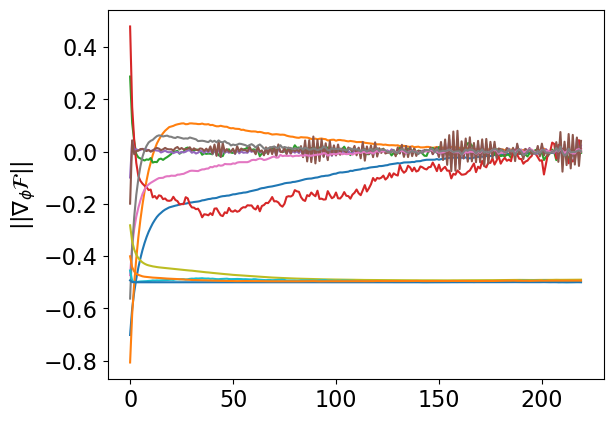

In [58]:
plt.plot(grad_total[:,],'-')
plt.ylabel(r'$||\nabla_{\phi}\mathcal{F}||$')

In [ ]:
# !! something wrong with the first iteration. taking things far.!!

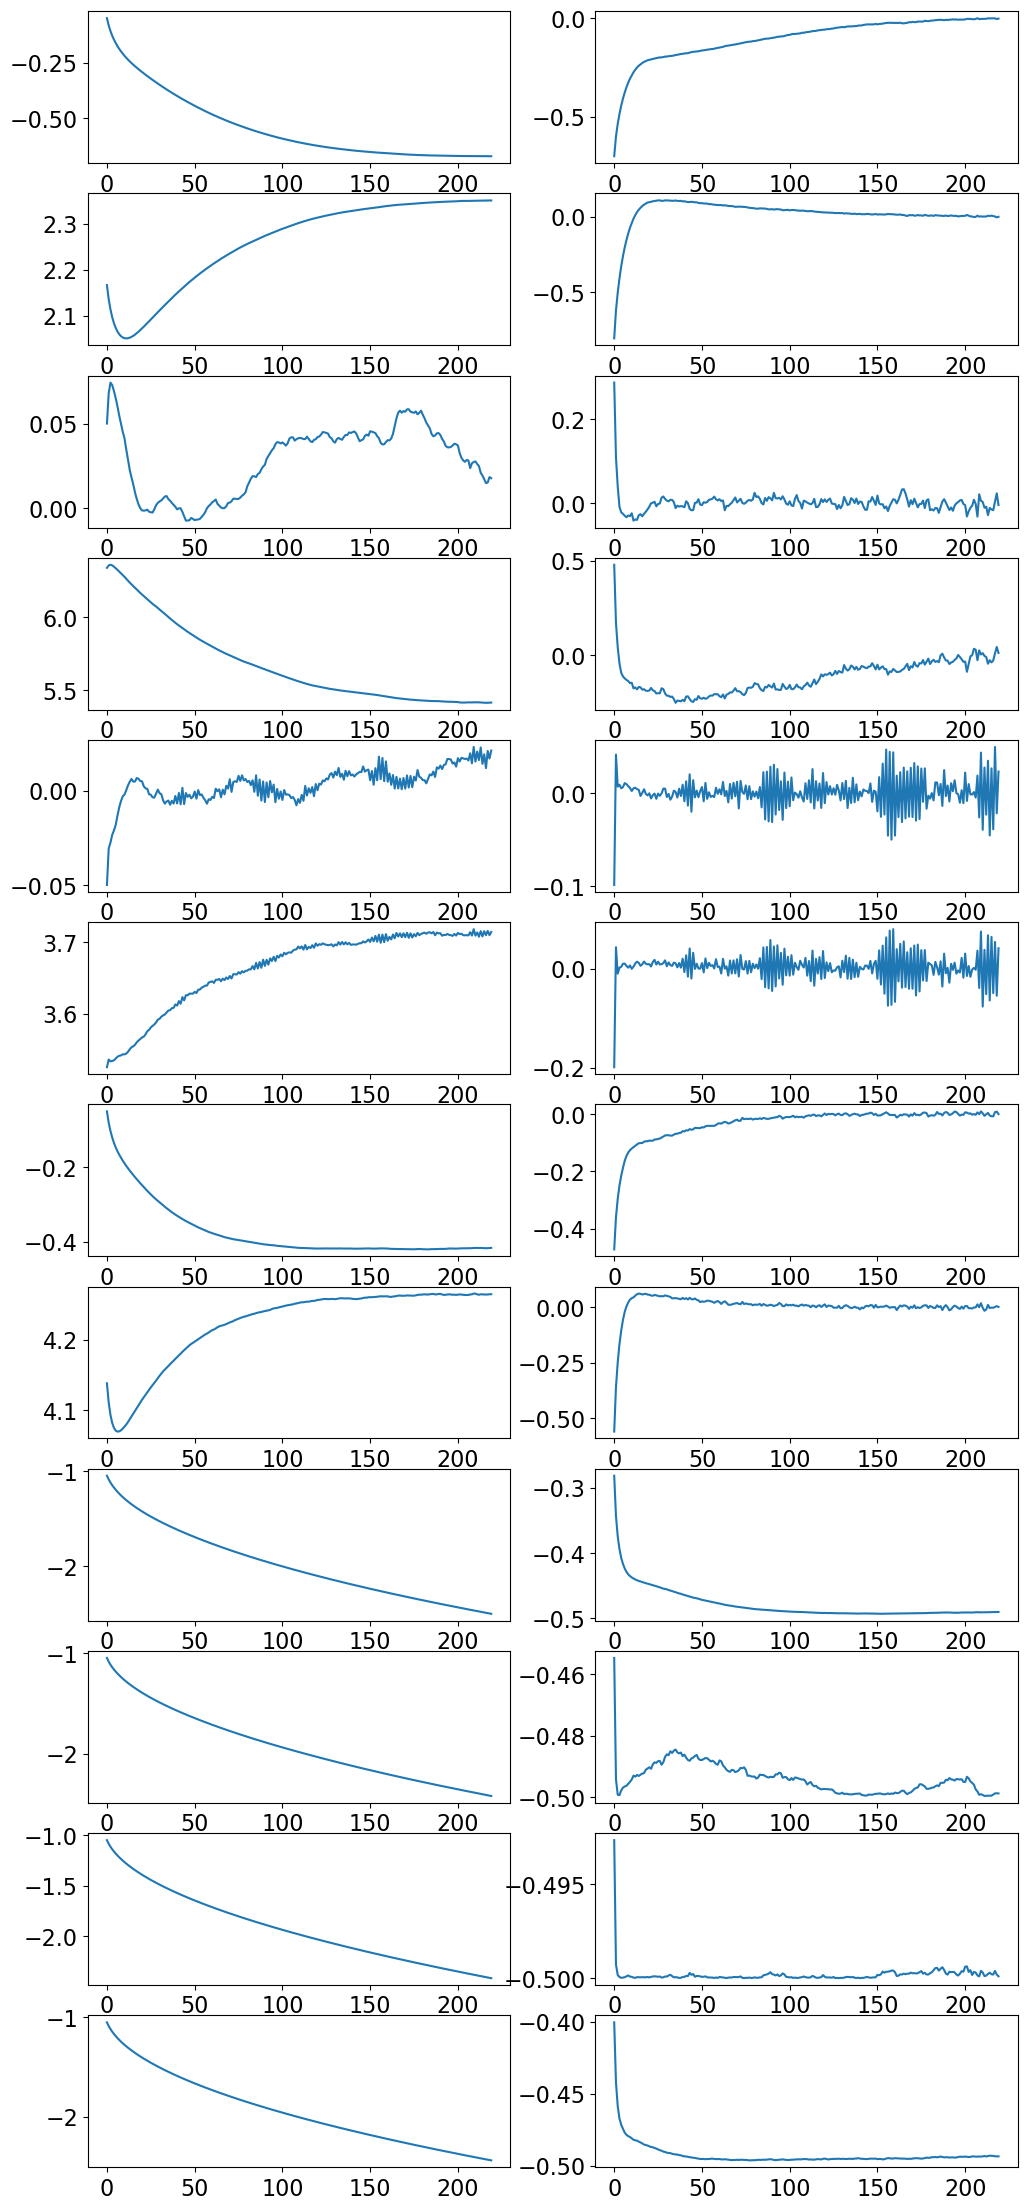

In [43]:
fig, ax = plt.subplots(12,2,figsize = [12,28])
for i in range(parameter_array.shape[1]):
    ax[i,0].plot(parameter_array[:,i])
    ax[i,1].plot(grad_total[:,i])
plt.savefig('Results/convergance_'+date+'pdf')

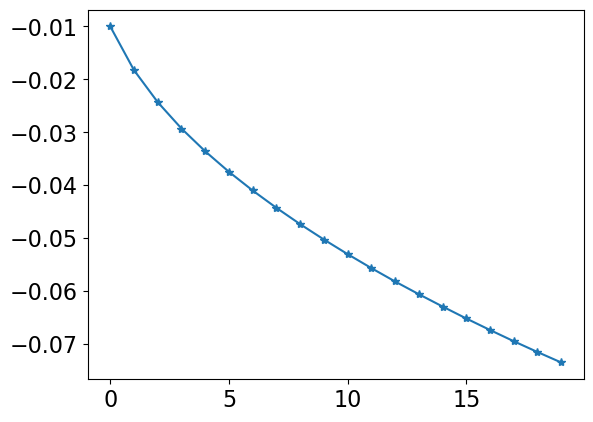

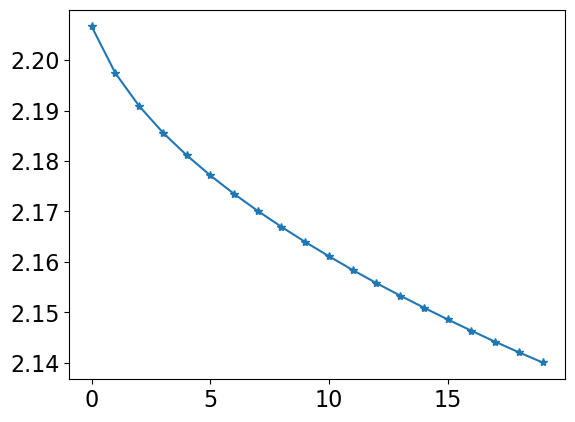

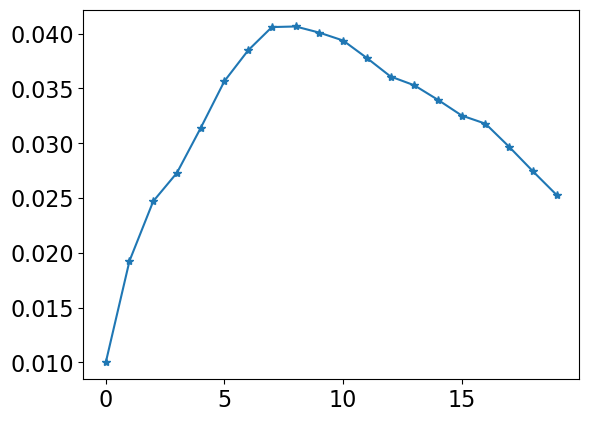

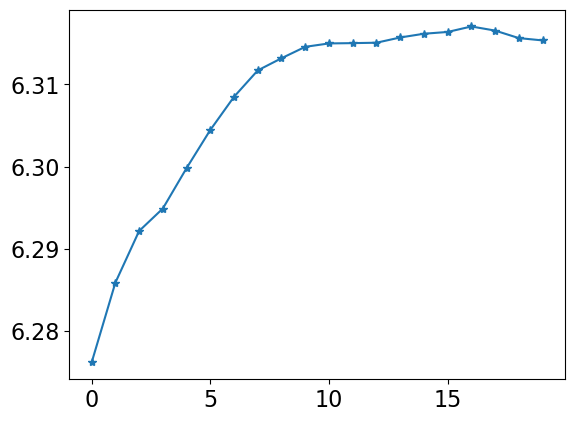

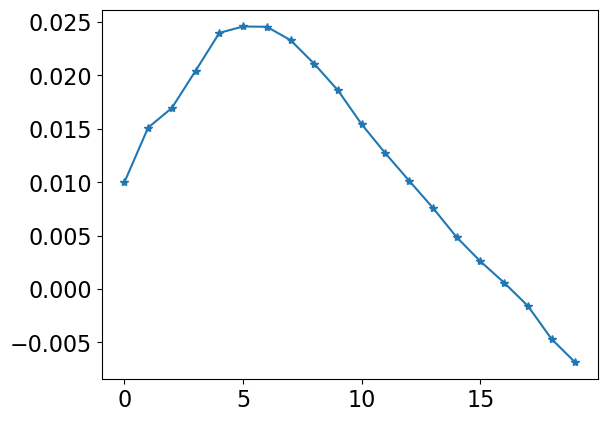

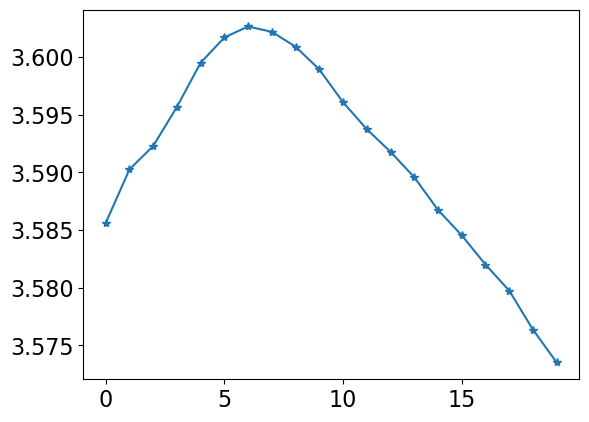

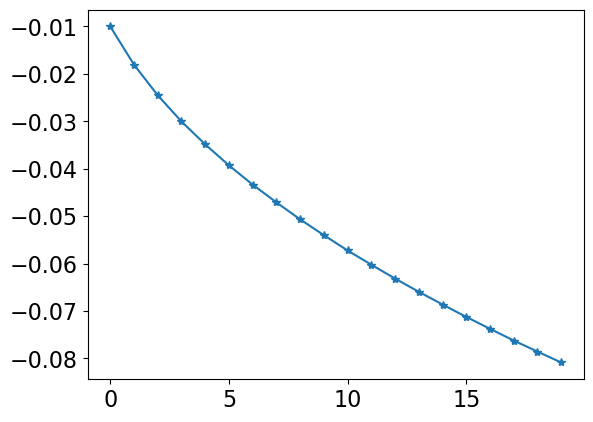

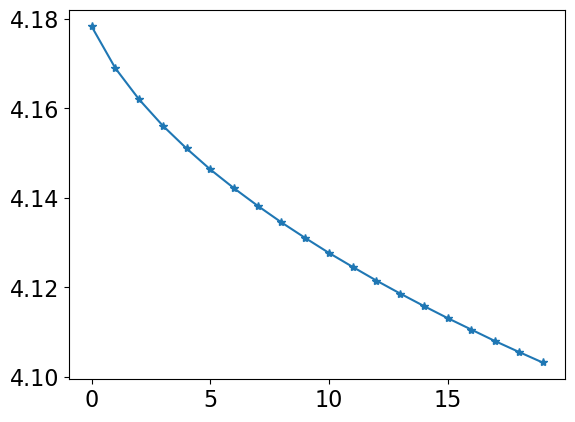

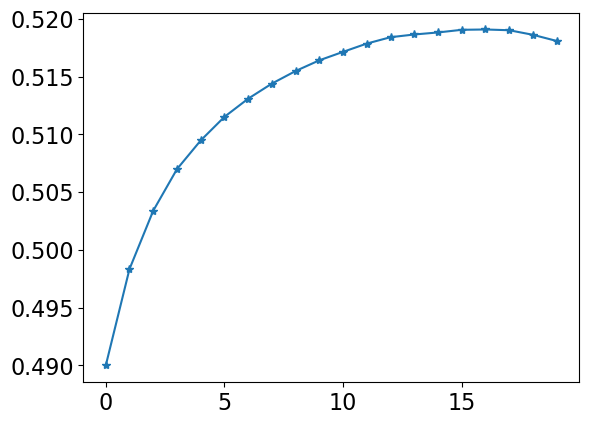

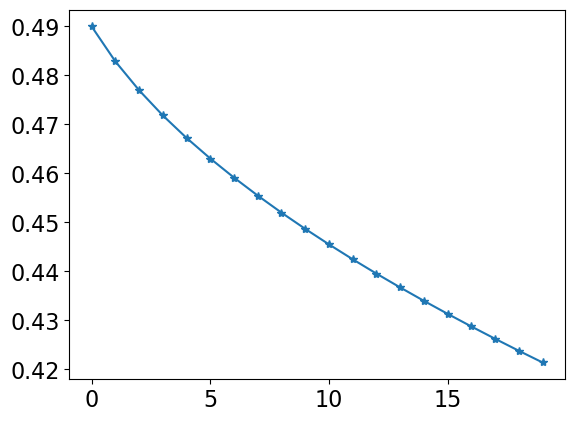

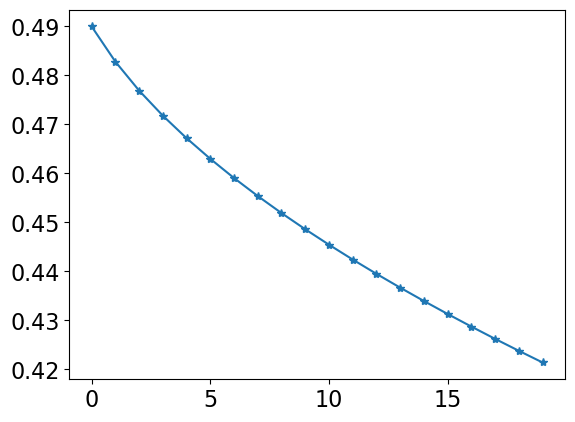

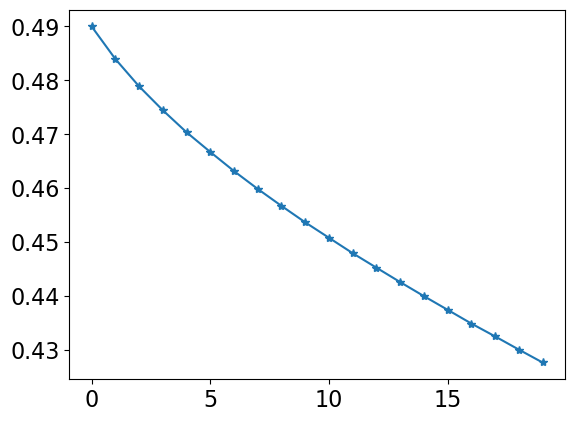

In [26]:
for i in range(parameter_array.shape[1]):
    plt.figure()
    plt.plot(parameter_array[:,i],'*-')

In [110]:
np.save('./Results/q_b_EM' + date + '.npy',q_b_N[-1])
np.save('./Results/phi_mean_inferred_' + date + '.npy',parameters[-1][0])
np.save('./Results/grad_' + date + '.npy',parameters[-1][0])
#np.save('./Results/phi_sd_inferred_' + date + '.npy',parameters[-1][1])

In [ ]:
plt.plot(q_b_N[-1][:,0])

In [ ]:
for i in range(q_b_N[-1].shape[1]):
    plt.figure()
    sns.kdeplot(q_b_N[0][:,i])
    plt.ticklabel_format(style='sci', scilimits=(0,0))
    if i ==0:
        plt.xlabel('B_1')
    if i ==1:
        plt.xlabel('B_2')
    if i ==2:
        plt.xlabel('\eta')
    if i ==3:
        plt.xlabel('Q_pot')

In [40]:
# Getting the p(b|phi,x) for an unseen flow and also getting a graph
#phi_mean = np.load('Results/phi_mean_inferred_26_09_2022_14:14.npy')
#phi_sd = np.load('Results/phi_sd_inferred_26_09_2022_14:14.npy')
phi_mean = np.hstack((np.array([-0.7,0.045,0.009,-0.4]).reshape(-1,1), np.array([2.35, 6.25, 3.55, 4.24]).reshape(-1,1)))
phi_sd = np.array([-3.5,-3.8,-3.4,-3.8])
parameters = [phi_mean,phi_sd]

In [22]:
parameters

[array([[-0.7  ,  2.35 ],
        [ 0.015,  6.2  ],
        [ 0.009,  3.55 ],
        [-0.4  ,  4.24 ]]),
 array([-2.5, -2.8, -2.4, -2.8])]

In [41]:
# getting b samples for unseen x's
x_test = np.linspace(0,1,21)
#b_samples_pred = []
b_pred_mean = []
b_pred_sd = []
for i in range(x_test.shape[0]):
    p_b_x = Prior_(x_test[i])
    b_ = p_b_x.sample(phi = parameters,samples=10000) # N x dim(b)
    b_pred_mean.append(np.mean(b_,axis=0))
    b_pred_sd.append(np.std(b_,axis=0))
    #b_pred_sd.append(0.75*np.std(b_,axis=0))
    #b_samples_pred.append(b_)
b_samples_mean = np.vstack(b_pred_mean) #dim(x_test) x dim(b)
b_samples_sd = np.vstack(b_pred_sd)
    

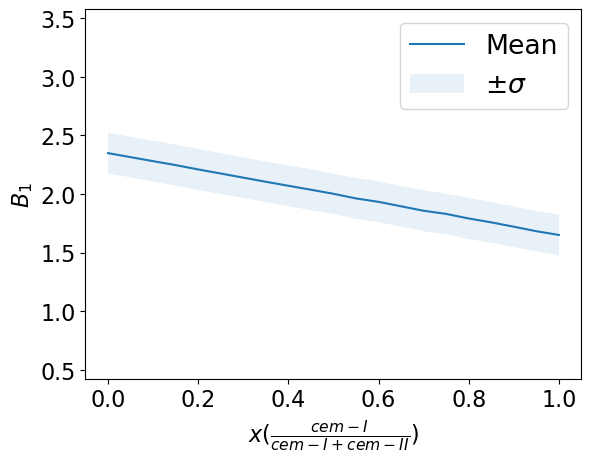

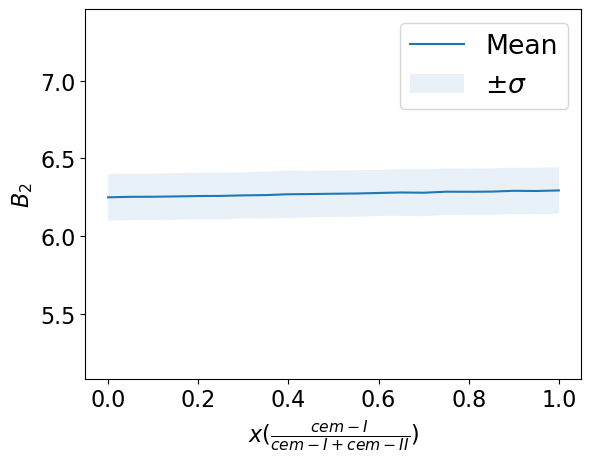

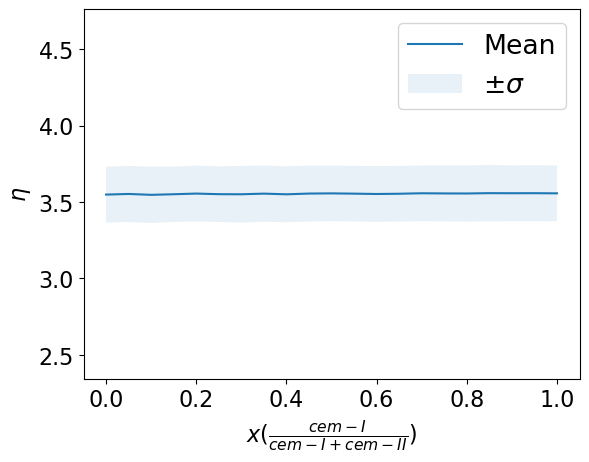

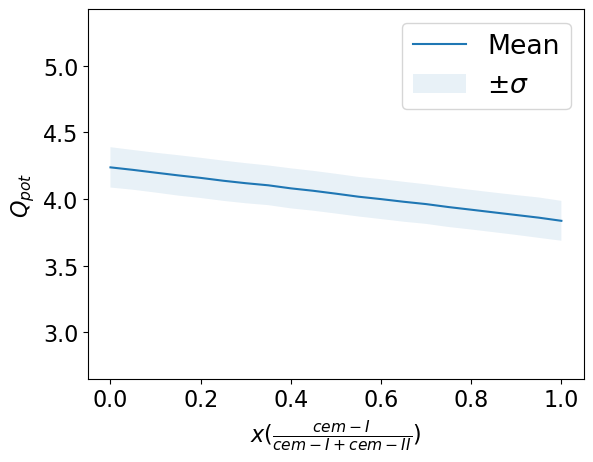

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i in range(b_samples_mean.shape[1]):
    plt.figure()
    plt.plot(x_test,b_samples_mean[:,i], label = 'Mean')
    plt.fill_between(x_test,b_samples_mean[:,i]-b_samples_sd[:,i],b_samples_mean[:,i]+b_samples_sd[:,i],alpha=0.1,label='$\pm \sigma$')
    b, t  = plt.ylim()
    plt.ylim(bottom = b-1, top = t+1)
    #plotting the observed dataset
    #plt.plot(hydration_data.keys(),b_opt[:,i], '*', label='obs')
    if i ==0:
        plt.ylabel('$B_1$')
    if i ==1:
        plt.ylabel('$B_2$')
    if i ==2:
        plt.ylabel('$\eta$')
    if i ==3:
        plt.ylabel('$Q_{pot}$')
    plt.xlabel(r'$x(\frac{cem-I}{cem-I + cem-II})$')
    plt.legend()

In [ ]:
# Forward propagating the uncertainity

In [45]:
hydration_data_test

{20: {'heat': [1.1803874092010231,
   2.596852300242129,
   4.316845382220714,
   10.683959732344151,
   17.956619234485135,
   26.410732177149097,
   35.00633654981577,
   42.8166634859672,
   50.49964813511617,
   58.88301536277872,
   66.94802687293505,
   74.16408980307499,
   82.85065295217196,
   91.03694283090212,
   99.85994414464461,
   107.90979585872925,
   115.44421450637536,
   123.21209401352596,
   131.07699621553556,
   139.2678340330873,
   147.98724340700633,
   156.33523777716815,
   164.577113574828,
   172.4298879399802,
   180.29230944808722,
   187.64343237959338,
   194.184195302902,
   200.5513096530255,
   206.80265828769214,
   212.64882691826003,
   215.1956726583094,
   220.73244552058114,
   227.10653753026637,
   234.9337271436921,
   239.14648910411626,
   246.93704600484264,
   253.31113801452787,
   257.8553388041365,
   262.51815980629533,
   269.31614463435875,
   273.1416464891041,
   276.6828087167071,
   280.776950464581,
   282.3486682808717,
   

In [44]:
p_b_x = Prior_(0.5)
b_sample_pred  = p_b_x.sample(phi=parameters,samples=1000)


In [45]:
ratio = 0.5
inp_obs = {
    'T_rxn' : list(hydration_data_test.keys())[0], # selecting the first temp value i.e 20
    'time_list' : hydration_data_test[20]['time']
}
y_samples = []
for i in range(b_sample_pred.shape[0]):

    Q_y = forward_model(inp_latents=b_sample_pred[i,:], inp_obs = inp_obs)
    y_samples.append(Q_y)
Y_pred = np.vstack(y_samples)
Y_pred_mean = np.mean(Y_pred, axis=0)
Y_pred_sd = np.std(Y_pred, axis=0)

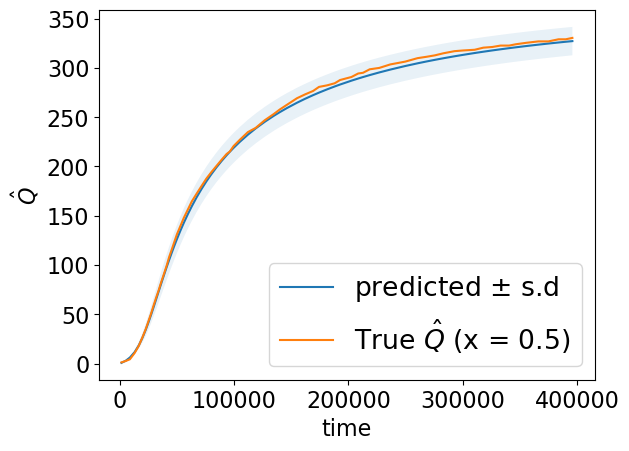

In [46]:
plt.plot(inp_obs['time_list'],Y_pred_mean, label = 'predicted $\pm$ s.d')
plt.fill_between(inp_obs['time_list'],Y_pred_mean - Y_pred_sd, Y_pred_mean + Y_pred_sd, alpha=0.1)
plt.plot(inp_obs['time_list'],hydration_data_test[20]['heat'], '-', label = 'True $\hat{Q}$ (x = ' + str(ratio)+')')
plt.xlabel('time')
plt.ylabel('$\hat{Q}$')
plt.legend()

## misc

### Performing deter opt to find the starting phi

In [ ]:
for i, v in enumerate(hydration_data):
    print (i,v)

In [ ]:
# def summation_posterior(phi, hydration_data :dict):
#     assert phi.ndim == 1

#     # prescibing values
#     sigma_prior = 1
#     sigma_lkl = 1
#     for i,ratio in enumerate(hydration_data):
#         pr = Prior_(x = ratio,sigma=sigma_prior)
#         # solver input
#         inp_obs = {
#         'T_rxn' : list(hydration_data[ratio].keys())[0], # selecting the first temp value i.e 20
#         'time_list' : hydration_data[ratio][20]['time']
#         }
#         lkl_tmp = likelihood(obs= hydration_data[ratio][20]['heat'],sigma=sigma_lkl,solver=forward_model, inp_obs = inp_obs)
#         pos = posterior(prior=pr, likelihood=lkl_tmp)

#     return logeval # this retruns sum of all the log values



In [ ]:
from scipy.optimize import minimize
res  = minimize(summation_posterior, phi_init = np.random.rand(8) ,args=hydration_data, method='Nelder-Mead')

In [ ]:
# def sum_of_squares(params, hydration_data:dict):

#     # solve for all 5 data points
#     Q_pred = []
#     Q_exp = []
#     for i,r in enumerate(hydration_data):
#         # linear relation between b and phis
#         b = params[0:4]*r + params[4:8]
#         #b =params
#         inp_obs = {
#         'T_rxn' : list(hydration_data[r].keys())[0], # selecting the first temp value i.e 20
#         'time_list' : hydration_data[r][20]['time']
#         }
#         tmp = forward_model(inp_latents=b, inp_obs=inp_obs)
#         Q_pred.append(tmp)
#         Q_exp.append(hydration_data[r][20]['heat'])
#     Q_pred = np.stack(Q_pred)
#     Q_exp = np.stack(Q_exp)
#     # normalisation
#     Q_pred = (Q_pred- np.mean(Q_pred))/(np.std(Q_pred) + 1e-07)
#     Q_exp = (Q_exp- np.mean(Q_exp))/(np.std(Q_exp) + 1e-07)
#     assert Q_exp.shape == Q_pred.shape
#     obj = np.sqrt(((Q_pred - Q_exp) ** 2).sum())
#     obj = np.sqrt(np.mean((Q_pred - Q_exp) ** 2)) # RMS
#     print(obj)
#     return obj

In [ ]:
def opt_hydration(params, hydration_data:dict, ratio_c1_c2 :int):

    # solve for all 5 data points
    Q_pred = []
    Q_exp = []
    b =params
    inp_obs = {
    'T_rxn' : list(hydration_data[ratio_c1_c2].keys())[0], # selecting the first temp value i.e 20
    'time_list' : hydration_data[ratio_c1_c2][20]['time']
    }
    Q_pred = forward_model(inp_latents=b, inp_obs=inp_obs)
    Q_exp = hydration_data[ratio_c1_c2][20]['heat']
    # normalisation
    #Q_pred = (Q_pred- np.mean(Q_pred))/(np.std(Q_pred) + 1e-07)
    #Q_exp = (Q_exp- np.mean(Q_exp))/(np.std(Q_exp) + 1e-07)
    #assert Q_exp.shape == Q_pred.shape
    obj = np.sqrt(np.mean((Q_pred - Q_exp) ** 2)) # RMS
    print(obj)
    return obj

In [ ]:
sum_of_squares(params=np.random.rand(8), hydration_data=hydration_data)

In [ ]:
x_init = np.random.normal(0.5,1,4)*inp_latents_test
print(x_init)

In [ ]:
from scipy.optimize import minimize
res  = minimize(opt_hydration, x0 = x_init ,args=(hydration_data,1), method='Nelder-Mead', options = {'maxiter': 200} )

In [ ]:
b_opt = []
x_init = inp_latents
for i,v in enumerate(hydration_data):
    res = minimize(opt_hydration, x0 = x_init ,args=(hydration_data,v), method='Nelder-Mead', options = {'maxiter': 300} )
    x_init = res.x
    b_opt.append(res.x)
b_opt = np.stack(b_opt)
np.save('./Results/b_opt_deterministic' + date + '.npy',b_opt)





In [ ]:
b_opt

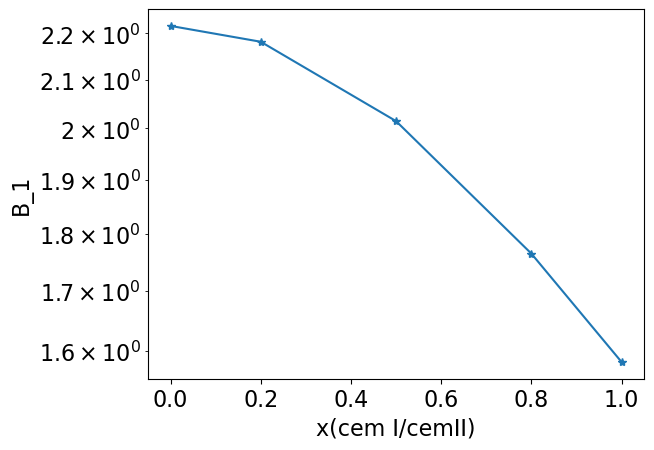

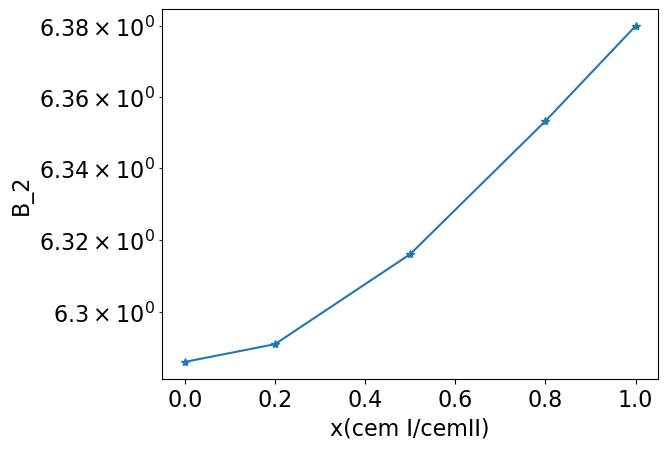

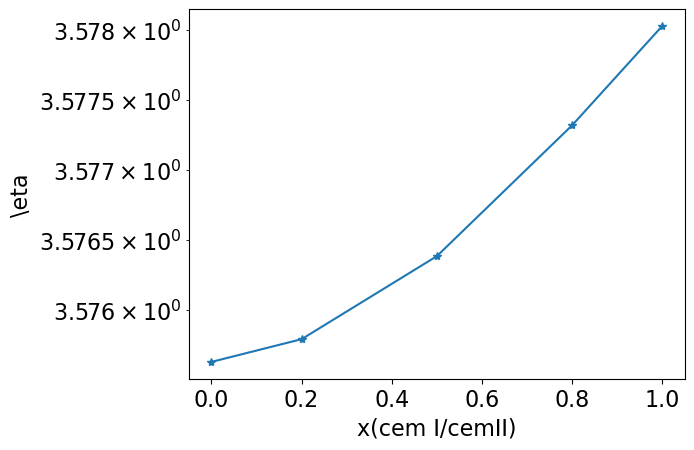

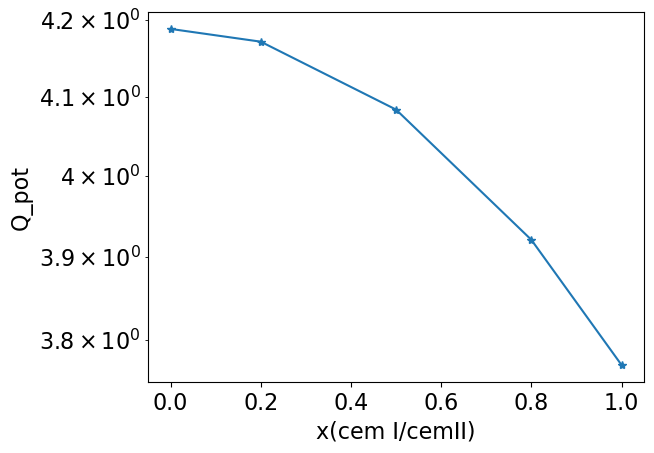

In [20]:
for i in range(b_opt.shape[1]):
    plt.figure()
    plt.semilogy(hydration_data.keys(),b_opt[:,i], '-*')
    if i ==0:
        plt.ylabel('B_1')
    if i ==1:
        plt.ylabel('B_2')
    if i ==2:
        plt.ylabel('\eta')
    if i ==3:
        plt.ylabel('Q_pot')
    plt.xlabel('x(cem I/cemII)')

In [ ]:
print(res)
print(inp_latents_test)


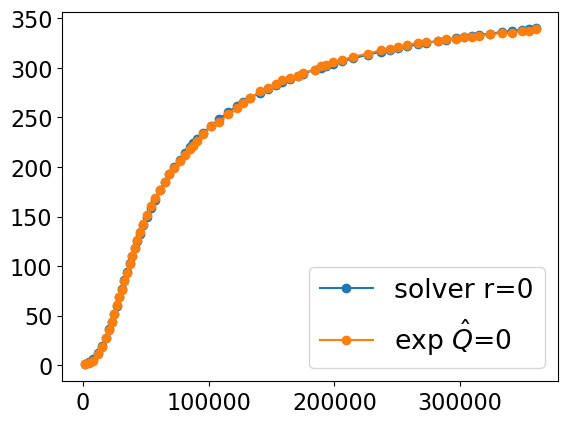

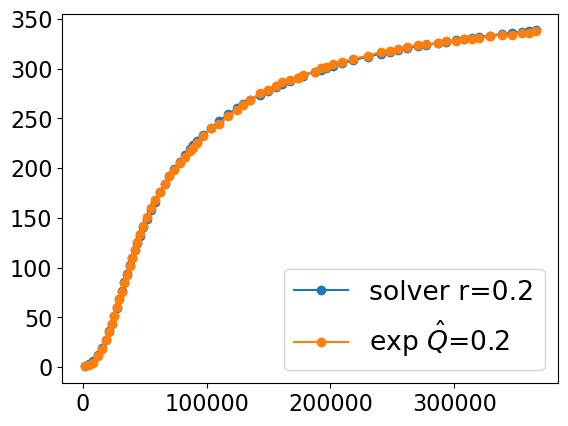

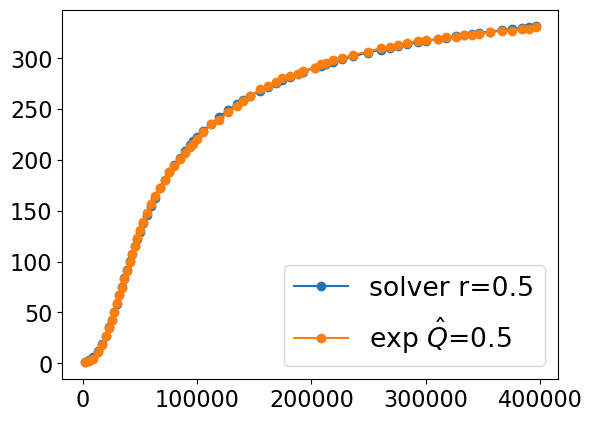

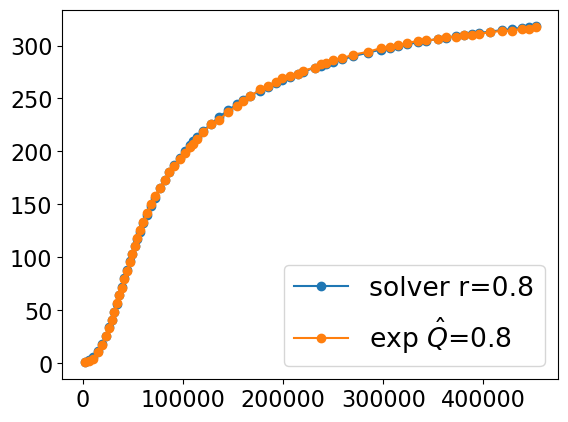

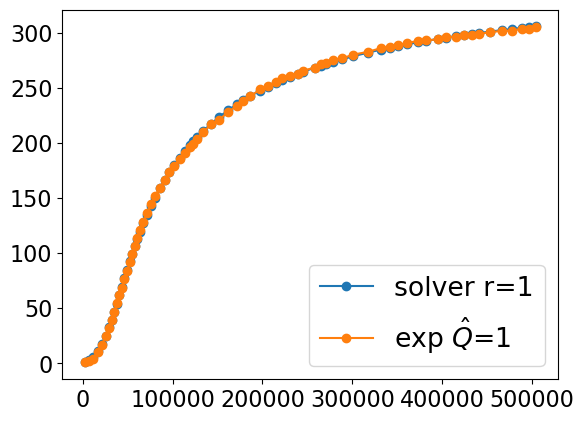

In [21]:

for i,v in enumerate(hydration_data):
    inp_obs = {
        'T_rxn': list(hydration_data[v].keys())[0],  # selecting the first temp value i.e 20
        'time_list': hydration_data[v][20]['time']
    }

    inp_latents = b_opt[i,:]
    Q_y = forward_model(inp_latents=inp_latents, inp_obs=inp_obs)

    plt.figure()
    plt.plot(inp_obs['time_list'], Q_y, '-o', label='solver r=' + str(v))
    plt.plot(inp_obs['time_list'], hydration_data[v][20]['heat'], '-o', label='exp $\hat{Q}$=' + str(v))

    plt.legend()

In [ ]:
# finding a linear relation

In [ ]:
def chk_1(a,b):
    print(a,b)


In [ ]:
def chk_2(**kwargs):
    chk_1(**kwargs)

In [ ]:
chk_2(a=2, b=3)


In [ ]:
dst = th.distributions.MultivariateNormal(th.tensor([2.2800, 6.2545, 3.5509, 4.2000]),th.tensor([[0.0302, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0224, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0334, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0224]])

In [72]:
dst = th.distributions.MultivariateNormal(th.tensor([1.0,1.5,1.3,2.4]),th.tensor([[0.302, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.224, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.334, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.224]]))

In [73]:
samples = dst.sample([100,])

In [74]:
for i in range(samples.shape[0]):
    print(dst.log_prob(samples[i,:]))

tensor(-2.5536)
tensor(-3.3031)
tensor(-2.8727)
tensor(-4.6066)
tensor(-1.5447)
tensor(-4.5923)
tensor(-4.3356)
tensor(-1.4152)
tensor(-2.7353)
tensor(-4.6281)
tensor(-4.6326)
tensor(-6.5747)
tensor(-1.4050)
tensor(-2.8829)
tensor(-2.4486)
tensor(-3.8877)
tensor(-1.7953)
tensor(-2.2325)
tensor(-2.2365)
tensor(-3.8644)
tensor(-3.6214)
tensor(-2.1024)
tensor(-2.0449)
tensor(-3.5078)
tensor(-2.3080)
tensor(-2.7197)
tensor(-4.6367)
tensor(-2.2071)
tensor(-2.4822)
tensor(-2.9280)
tensor(-1.9429)
tensor(-2.3738)
tensor(-3.6737)
tensor(-2.3538)
tensor(-4.6039)
tensor(-5.4974)
tensor(-4.7617)
tensor(-3.4076)
tensor(-3.6359)
tensor(-5.7930)
tensor(-2.4478)
tensor(-1.4530)
tensor(-2.7675)
tensor(-3.0341)
tensor(-2.0034)
tensor(-3.2609)
tensor(-1.9021)
tensor(-3.1353)
tensor(-1.8652)
tensor(-1.7469)
tensor(-3.4950)
tensor(-2.5810)
tensor(-1.9761)
tensor(-1.7233)
tensor(-6.2742)
tensor(-6.4222)
tensor(-4.9025)
tensor(-6.2779)
tensor(-5.2819)
tensor(-1.5425)
tensor(-4.2717)
tensor(-1.3393)
tensor(-

In [ ]:
q_b = E_step(100,0.000000001,x_init = 0.90*b_opt,phi = phi_test, obs_data = hydration_data)